# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definitions
PAST_HISTORY = int(60 / 5) * 6 #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15
STEP = 1
BATCH_SIZE = 256 #128 #32
TRAIN_SPLIT_RATIO = 0.995 #0.8 #0.9891 # 1-(60/5*24)/50977

#LIST_SEEDS = [1,2,3,4,5]
LIST_SEEDS = [1]
MODE_TRAIN_AE = False #  True
MODE_AUTO_SELECT = 0 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = False # False

EPOCHS_AE = 30#30
PATIENCE_AE = 0#10
LIST_UNITS_AE = [512]
LIST_UNITS_ENC_AE = [32]
LIST_DROPOUT_AE = [0.2]

EPOCHS_PRED = 10#30
PATIENCE_PRED = 0#10
LIST_UNITS_PRED = [256]#ROUND 64 = 512
LIST_DROPOUT_PRED = [0.1]#ROUND 64 = 0.5

MODE_TRAIN_LSTM = False

# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"
path_save_auto_select = "data/list_auto_select.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")

In [2]:
PAST_HISTORY

72

In [3]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [4]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [5]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

## Load raw features

In [6]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_71839/3998402900.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
97913  1701905100000   2230.78   2231.45  2228.87    2229.26    482.0144   
97914  1701905400000   2229.26   2233.71  2228.81    2232.90    896.4471   
97915  1701905700000   2232.91   2232.91  2230.32    2232.48    937.7980   
97916  1701906000000   2232.49   2233.89  2229.43    2233.89    661.5802   
97917  1701906300000   2233.89   2236.20  2233.00    2235.04    724.8447   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1757.507196       1757.050424   
1      2023-01-01 00:05:00       1757.507196       1757.050424   
2      2023-01-01 00:10:00       1757.507196       1757.050424   
3      2023-01-01 00:15:00       1757.507196       1757.050424   
4      2023-01-01 00:20:00       1757.507196       1757.050424   
...                    ...               ...               ...   
97913  2023-12-06 23:25:00       2259.635000       2267.950000   
97914  2023-12-06 23:30:00       2258.777500       2267.950000   
97915  2023-12-06 23:35:00       2258.450000       2267.950000   
97916  2023-12-06 23:40:00       2255.000000       2263.500000   
97917  2023-12-06 23:45:00       2250.300000       2257.700000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0                 NaN  ...   NaN         NaN            NaN           NaN   
1                 NaN  ...   NaN         NaN            NaN           NaN   
2                 NaN  ...   NaN         NaN            NaN           NaN   
3                 NaN  ...   NaN         NaN            NaN           NaN   
4                 NaN  ...   NaN         NaN            NaN           NaN   
...               ...  ...   ...         ...            ...           ...   
97913        2239.875  ...   NaN         NaN            NaN           NaN   
97914        2238.665  ...   NaN         NaN            NaN           NaN   
97915        2238.665  ...   NaN         NaN            NaN           NaN   
97916        2238.665  ...   NaN         NaN            NaN           NaN   
97917        2238.665  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   NaN         0.0               NaN         0.0      0.0   
1                   NaN         0.0               NaN         0.0      0.0   
2                   NaN         0.0               NaN         0.0      0.0   
3                   NaN         0.0               NaN         0.0      0.0   
4                   NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
97913               NaN         0.0               NaN         0.0      0.0   
97914               NaN         0.0               NaN         0.0      0.0   
97915               NaN         0.0               NaN         0.0      0.0   
97916               NaN         0.0               NaN         0.0      0.0   
97917               NaN         0.0               NaN         0.0      0.0   

       date  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
97913   NaN  
97914   NaN  
97915   NaN  
97916   NaN  
97917   NaN  

[97918 rows x 135 columns]

### drop nan

In [7]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_ETH        1
vwap_z_score_BTC        1
ichi_tenkan_ETH         8
ichi_tenkan_BTC         8
rsi_h_ETH              13
                    ...  
Actual              97876
Event               97876
Country             97876
keep                97876
date                97876
Length: 65, dtype: int64

on 97918 samples


#### Cheat Backward Filling

In [8]:
df_feat = df_feat_raw.copy()

In [9]:
df_feat = df_feat.bfill(axis ='rows')

In [10]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
97913  1701905100000   2230.78   2231.45  2228.87    2229.26    482.0144   
97914  1701905400000   2229.26   2233.71  2228.81    2232.90    896.4471   
97915  1701905700000   2232.91   2232.91  2230.32    2232.48    937.7980   
97916  1701906000000   2232.49   2233.89  2229.43    2233.89    661.5802   
97917  1701906300000   2233.89   2236.20  2233.00    2235.04    724.8447   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1757.507196       1757.050424   
1      2023-01-01 00:05:00       1757.507196       1757.050424   
2      2023-01-01 00:10:00       1757.507196       1757.050424   
3      2023-01-01 00:15:00       1757.507196       1757.050424   
4      2023-01-01 00:20:00       1757.507196       1757.050424   
...                    ...               ...               ...   
97913  2023-12-06 23:25:00       2259.635000       2267.950000   
97914  2023-12-06 23:30:00       2258.777500       2267.950000   
97915  2023-12-06 23:35:00       2258.450000       2267.950000   
97916  2023-12-06 23:40:00       2255.000000       2263.500000   
97917  2023-12-06 23:45:00       2250.300000       2257.700000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...   1.0         0.0            0.0           0.0   
1            1194.710  ...   1.0         0.0            0.0           0.0   
2            1194.710  ...   1.0         0.0            0.0           0.0   
3            1194.710  ...   1.0         0.0            0.0           0.0   
4            1194.710  ...   1.0         0.0            0.0           0.0   
...               ...  ...   ...         ...            ...           ...   
97913        2239.875  ...   NaN         NaN            NaN           NaN   
97914        2238.665  ...   NaN         NaN            NaN           NaN   
97915        2238.665  ...   NaN         NaN            NaN           NaN   
97916        2238.665  ...   NaN         NaN            NaN           NaN   
97917        2238.665  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
97913               NaN         0.0               NaN         0.0      0.0   
97914               NaN         0.0               NaN         0.0      0.0   
97915               NaN         0.0               NaN         0.0      0.0   
97916               NaN         0.0               NaN         0.0      0.0   
97917               NaN         0.0               NaN         0.0      0.0   

                      date  
0      2023-01-02 05:00:00  
1      2023-01-02 05:00:00  
2      2023-01-02 05:00:00  
3      2023-01-02 05:00:00  
4      2023-01-02 05:00:00  
...                    ...  
97913                  NaN  
97914                  NaN  
97915                  NaN  
97916                  NaN  
97917                  NaN  

[97918 rows x 135 columns]

In [11]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       3681
delta_event_real    3681
delta_event_pred    3681
Previous_num        3681
Actual_num          3681
Event               3681
Date                3681
Previous            3681
Consensus           3681
Actual              3681
Country             3681
Time (ET)           3681
keep                3681
date                3681
dtype: int64

on 97918 samples


In [12]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [13]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [14]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [15]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1196.13   1196.32  1195.65    1196.32    334.5592   
1       1196.31   1196.69  1194.90    1195.38    682.3876   
2       1195.38   1195.81  1194.55    1194.55    228.9387   
3       1194.55   1195.98  1194.31    1195.98    601.8903   
4       1195.98   1196.37  1195.97    1196.06    144.8048   
...         ...       ...      ...        ...         ...   
97913   2230.78   2231.45  2228.87    2229.26    482.0144   
97914   2229.26   2233.71  2228.81    2232.90    896.4471   
97915   2232.91   2232.91  2230.32    2232.48    937.7980   
97916   2232.49   2233.89  2229.43    2233.89    661.5802   
97917   2233.89   2236.20  2233.00    2235.04    724.8447   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1757.507196       1757.050424   
1      2023-01-01 00:05:00       1757.507196       1757.050424   
2      2023-01-01 00:10:00       1757.507196       1757.050424   
3      2023-01-01 00:15:00       1757.507196       1757.050424   
4      2023-01-01 00:20:00       1757.507196       1757.050424   
...                    ...               ...               ...   
97913  2023-12-06 23:25:00       2259.635000       2267.950000   
97914  2023-12-06 23:30:00       2258.777500       2267.950000   
97915  2023-12-06 23:35:00       2258.450000       2267.950000   
97916  2023-12-06 23:40:00       2255.000000       2263.500000   
97917  2023-12-06 23:45:00       2250.300000       2257.700000   

       ichi_kijun_ETH  ichi_tenkan_ETH  ...   vwap_m_ETH  vwap_3m_ETH  \
0            1194.710         1194.710  ...  1196.096667  1196.096667   
1            1194.710         1194.710  ...  1195.801420  1195.801420   
2            1194.710         1194.710  ...  1195.648641  1195.648641   
3            1194.710         1194.710  ...  1195.575250  1195.575250   
4            1194.710         1194.710  ...  1195.615807  1195.615807   
...               ...              ...  ...          ...          ...   
97913        2239.875         2233.720  ...  2102.367694  1942.248173   
97914        2238.665         2231.245  ...  2102.410141  1942.264283   
97915        2238.665         2229.065  ...  2102.446091  1942.281069   
97916        2238.665         2227.645  ...  2102.468573  1942.292989   
97917        2238.665         2228.470  ...  2102.497549  1942.307107   

       vwap_6m_ETH   vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH  \
0      1196.096667  1196.096667   1196.096667         -0.634018  0.000187   
1      1195.801420  1195.801420   1195.801420         -0.634018 -0.000353   
2      1195.648641  1195.648641   1195.648641         -1.240604 -0.000920   
3      1195.575250  1195.575250   1195.575250          0.521593  0.000338   
4      1195.615807  1195.615807   1195.615807          0.626856  0.000371   
...            ...          ...           ...               ...       ...   
97913  1826.541617  2054.957975   1754.447517          2.609558  0.212991   
97914  1826.556560  2054.993193   1754.450898          2.629466  0.214273   
97915  1826.570300  2055.024631   1754.454436          2.627061  0.214123   
97916  1826.580886  2055.059613   1754.456934          2.634717  0.214618   
97917  1826.591727  2055.149556   1754.459684          2.640942  0.215021   

         supply_ETH  act_addr_ETH  market_dom_ETH  
0      1.204522e+08      484572.0       17.831243  
1      1.204522e+08      484572.0       17.831243  
2      1.204522e+08      484572.0       17.831243  
3      1.204522e+08      484572.0       17.831243  
4      1.204522e+08      484572.0       17.831243  
...             ...           ...             ...  
97913  1.202303e+08      478541.0       16.588010  
97914  1.202303e+08      478541.0       16.588010  
97915  1.202303e+08      478541.0       16.588010  
97916  1.202303e+08      478541.0       16.588010  
97917  1.202303e+08      478541.0       16.588010  

[97918 rows x 46 columns]

In [16]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [17]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [18]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [19]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [20]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

#### add special indices

In [21]:
df_feat[["fvx", "spx", "dxy"]]

fvx          spx         dxy
0      3.910  3823.179932  103.494003
1      3.910  3823.179932  103.494003
2      3.910  3823.179932  103.494003
3      3.910  3823.179932  103.494003
4      3.910  3823.179932  103.494003
...      ...          ...         ...
97913  4.121  4549.339844  104.167999
97914  4.121  4549.339844  104.167999
97915  4.121  4549.339844  104.167999
97916  4.121  4549.339844  104.167999
97917  4.121  4549.339844  104.167999

[97918 rows x 3 columns]

In [22]:
list_price_dep_special = ["fvx", "spx", "dxy"]

### Not proportional to the Price 

In [23]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB) - set(list_price_dep_special)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [24]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    #'dxy',
    #'spx',
    #'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    #'month_cos',
    #'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [25]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +  
    list_price_dep_special +  
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  102


In [26]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [27]:
df_feat.shape[0]

97918

In [28]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

97428

In [29]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
97913  1701905100000   2230.78   2231.45  2228.87    2229.26    482.0144   
97914  1701905400000   2229.26   2233.71  2228.81    2232.90    896.4471   
97915  1701905700000   2232.91   2232.91  2230.32    2232.48    937.7980   
97916  1701906000000   2232.49   2233.89  2229.43    2233.89    661.5802   
97917  1701906300000   2233.89   2236.20  2233.00    2235.04    724.8447   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1757.507196       1757.050424   
1      2023-01-01 00:05:00       1757.507196       1757.050424   
2      2023-01-01 00:10:00       1757.507196       1757.050424   
3      2023-01-01 00:15:00       1757.507196       1757.050424   
4      2023-01-01 00:20:00       1757.507196       1757.050424   
...                    ...               ...               ...   
97913  2023-12-06 23:25:00       2259.635000       2267.950000   
97914  2023-12-06 23:30:00       2258.777500       2267.950000   
97915  2023-12-06 23:35:00       2258.450000       2267.950000   
97916  2023-12-06 23:40:00       2255.000000       2263.500000   
97917  2023-12-06 23:45:00       2250.300000       2257.700000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
97913        2239.875  ...         NaN            NaN           NaN   
97914        2238.665  ...         NaN            NaN           NaN   
97915        2238.665  ...         NaN            NaN           NaN   
97916        2238.665  ...         NaN            NaN           NaN   
97917        2238.665  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
97913               NaN         0.0               NaN         0.0      0.0   
97914               NaN         0.0               NaN         0.0      0.0   
97915               NaN         0.0               NaN         0.0      0.0   
97916               NaN         0.0               NaN         0.0      0.0   
97917               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
97913                  NaN  False  
97914                  NaN  False  
97915                  NaN  False  
97916                  NaN  False  
97917                  NaN  False  

[97918 rows x 136 columns]

In [30]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
97424  1701758400000   2228.02   2230.84  2226.38    2228.92    880.5754   
97425  1701758700000   2228.93   2229.99  2227.14    2229.94    874.7971   
97426  1701759000000   2229.94   2231.90  2229.63    2230.14    475.5288   
97427  1701759300000   2230.15   2231.33  2229.32    2230.09    639.6569   
97428  1701759600000   2230.10   2231.24  2223.10    2224.91   1504.4913   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1757.507196       1757.050424   
1      2023-01-01 00:05:00       1757.507196       1757.050424   
2      2023-01-01 00:10:00       1757.507196       1757.050424   
3      2023-01-01 00:15:00       1757.507196       1757.050424   
4      2023-01-01 00:20:00       1757.507196       1757.050424   
...                    ...               ...               ...   
97424  2023-12-05 06:40:00       2229.120000       2238.145000   
97425  2023-12-05 06:45:00       2229.120000       2238.145000   
97426  2023-12-05 06:50:00       2228.887500       2238.145000   
97427  2023-12-05 06:55:00       2228.767500       2238.145000   
97428  2023-12-05 07:00:00       2228.767500       2238.145000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0             1194.71  ...         0.0            0.0           0.0   
1             1194.71  ...         0.0            0.0           0.0   
2             1194.71  ...         0.0            0.0           0.0   
3             1194.71  ...         0.0            0.0           0.0   
4             1194.71  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
97424         2230.16  ...         NaN            NaN           NaN   
97425         2230.16  ...         NaN            NaN           NaN   
97426         2230.16  ...         NaN            NaN           NaN   
97427         2230.16  ...         NaN            NaN           NaN   
97428         2230.16  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
97424               NaN         0.0               NaN         0.0      0.0   
97425               NaN         0.0               NaN         0.0      0.0   
97426               NaN         0.0               NaN         0.0      0.0   
97427               NaN         0.0               NaN         0.0      0.0   
97428               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
97424                  NaN   True  
97425                  NaN   True  
97426                  NaN   True  
97427                  NaN   True  
97428                  NaN   True  

[97429 rows x 136 columns]

In [31]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
97429  1701759900000   2224.92   2224.92  2219.51    2220.76   1688.8640   
97430  1701760200000   2220.76   2221.41  2217.64    2218.44   2473.7447   
97431  1701760500000   2218.44   2220.25  2213.52    2214.99   2873.8562   
97432  1701760800000   2214.98   2215.05  2202.39    2208.27   5671.8916   
97433  1701761100000   2208.27   2211.60  2207.87    2209.78   2545.0002   
...              ...       ...       ...      ...        ...         ...   
97913  1701905100000   2230.78   2231.45  2228.87    2229.26    482.0144   
97914  1701905400000   2229.26   2233.71  2228.81    2232.90    896.4471   
97915  1701905700000   2232.91   2232.91  2230.32    2232.48    937.7980   
97916  1701906000000   2232.49   2233.89  2229.43    2233.89    661.5802   
97917  1701906300000   2233.89   2236.20  2233.00    2235.04    724.8447   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
97429  2023-12-05 07:05:00         2228.7675          2238.145   
97430  2023-12-05 07:10:00         2228.1575          2238.145   
97431  2023-12-05 07:15:00         2227.5375          2237.925   
97432  2023-12-05 07:20:00         2227.5375          2237.925   
97433  2023-12-05 07:25:00         2227.5375          2237.495   
...                    ...               ...               ...   
97913  2023-12-06 23:25:00         2259.6350          2267.950   
97914  2023-12-06 23:30:00         2258.7775          2267.950   
97915  2023-12-06 23:35:00         2258.4500          2267.950   
97916  2023-12-06 23:40:00         2255.0000          2263.500   
97917  2023-12-06 23:45:00         2250.3000          2257.700   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
97429        2228.750  ...         NaN            NaN           NaN   
97430        2227.815  ...         NaN            NaN           NaN   
97431        2225.755  ...         NaN            NaN           NaN   
97432        2220.190  ...         NaN            NaN           NaN   
97433        2220.190  ...         NaN            NaN           NaN   
...               ...  ...         ...            ...           ...   
97913        2239.875  ...         NaN            NaN           NaN   
97914        2238.665  ...         NaN            NaN           NaN   
97915        2238.665  ...         NaN            NaN           NaN   
97916        2238.665  ...         NaN            NaN           NaN   
97917        2238.665  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
97429               NaN         0.0               NaN         0.0      0.0   
97430               NaN         0.0               NaN         0.0      0.0   
97431               NaN         0.0               NaN         0.0      0.0   
97432               NaN         0.0               NaN         0.0      0.0   
97433               NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
97913               NaN         0.0               NaN         0.0      0.0   
97914               NaN         0.0               NaN         0.0      0.0   
97915               NaN         0.0               NaN         0.0      0.0   
97916               NaN         0.0               NaN         0.0      0.0   
97917               NaN         0.0               NaN         0.0      0.0   

       date  train  
97429   NaN  False  
97430   NaN  False  
97431   NaN  False  
97432   NaN  False  
97433   NaN  False  
...     ...    ...  
97913   NaN  False  
97914   NaN  False  
97915   NaN  False  
97916   NaN  False  
97917   NaN  False  

[489 rows x 136 columns]

In [32]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [33]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [34]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
        or (col in list_price_dep_special)
    ) 
    for col in list_col_select ]

In [35]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(97342, 72, 102) (97342, 15)
(402, 72, 102) (402, 15)


In [36]:
X_train

array([[[1.00149011, 1.00133106, 1.00149011, ..., 0.        ,
         0.        , 0.        ],
        [1.0007032 , 1.00148174, 1.00179986, ..., 0.        ,
         0.        , 0.        ],
        [1.00000837, 1.0007032 , 1.00106317, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99983257, 0.99962329, 0.99984094, ..., 0.        ,
         0.        , 0.        ],
        [0.99977397, 0.99984094, 0.99987443, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 0.99978234, 1.00010883, ..., 0.        ,
         0.        , 0.        ]],

       [[1.00024266, 1.00102084, 1.00133881, ..., 0.        ,
         0.        , 0.        ],
        [0.99954815, 1.00024266, 1.00060247, ..., 0.        ,
         0.        , 0.        ],
        [1.00074471, 0.99954815, 1.00074471, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99931386, 0.9993808 , 0.99941427, ..., 0.        ,
         0.        , 0.        ],
        [0.9

In [37]:
seq_y

array([1.00031357, 1.00103029, 1.00107956, 1.00180972, 1.00151407,
       1.00240997, 1.00159022, 1.00193067, 1.00152303, 0.99909514,
       0.99804246, 0.99844561, 0.99890252, 0.99899211, 0.99896971])

In [38]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00124641, 1.00088773, 1.00120157, ..., 0.99892845, 0.99933196,
        0.99978928],
       [0.99964177, 0.99995522, 1.00067168, ..., 0.99808794, 0.99854468,
        0.99863424],
       [1.00031357, 1.00103029, 1.00107956, ..., 0.99890252, 0.99899211,
        0.99896971]])

In [39]:
seq_y

array([1.00031357, 1.00103029, 1.00107956, 1.00180972, 1.00151407,
       1.00240997, 1.00159022, 1.00193067, 1.00152303, 0.99909514,
       0.99804246, 0.99844561, 0.99890252, 0.99899211, 0.99896971])

In [40]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00124641, 1.00088773, 1.00120157, ..., 0.99892845, 0.99933196,
        0.99978928],
       [0.99964177, 0.99995522, 1.00067168, ..., 0.99808794, 0.99854468,
        0.99863424],
       [1.00031357, 1.00103029, 1.00107956, ..., 0.99890252, 0.99899211,
        0.99896971]])

In [41]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [42]:
X_train.shape

(97342, 72, 102)

In [43]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(97342, 72, 102) (97342, 15)
(402, 72, 102) (402, 15)


## Standardization

In [44]:
path_scaler

'data/scaler.bin'

In [45]:
if MODE_TRAIN_AE:
    scaler = StandardScaler()
    X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)
    
    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca = scaler.transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

Load standardization from disk...


In [46]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00124641, 1.00088773, 1.00120157, ..., 0.99892845, 0.99933196,
        0.99978928],
       [0.99964177, 0.99995522, 1.00067168, ..., 0.99808794, 0.99854468,
        0.99863424],
       [1.00031357, 1.00103029, 1.00107956, ..., 0.99890252, 0.99899211,
        0.99896971]])

In [47]:
np.mean(y_train_sca)

2.777535750557516e-05

In [48]:
np.std(y_train_sca)

0.999969997469507

In [49]:
np.mean(y_test_sca)

0.05349392517492396

In [50]:
np.std(y_test_sca)

1.273507364607409

### Check unscaling

In [51]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       1757.507196       1757.050424   
1    1195.38   1196.31   1196.69  1194.90       1757.507196       1757.050424   
2    1194.55   1195.38   1195.81  1194.55       1757.507196       1757.050424   
3    1195.98   1194.55   1195.98  1194.31       1757.507196       1757.050424   
4    1196.06   1195.98   1196.37  1195.97       1757.507196       1757.050424   
5    1196.61   1196.06   1196.70  1196.06       1757.507196       1757.050424   
6    1194.36   1196.62   1196.62  1193.72       1757.507196       1757.050424   
7    1194.22   1194.37   1194.43  1192.72       1757.507196       1757.050424   
8    1193.64   1194.22   1194.22  1193.02       1757.507196       1757.050424   
9    1194.64   1193.64   1195.06  1193.63       1757.507196       1757.050424   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           1758.773512   
1         1194.71          1194.71           1758.773512   
2         1194.71          1194.71           1758.773512   
3         1194.71          1194.71           1758.773512   
4         1194.71          1194.71           1758.773512   
5         1194.71          1194.71           1758.773512   
6         1194.71          1194.71           1758.773512   
7         1194.71          1194.71           1758.773512   
8         1194.71          1194.71           1758.773512   
9         1194.71          1194.71           1758.773512   

   ichi_cloud_b_day_ETH  ...    supply_ETH  hour_cos  hour_sin  weekday_cos  \
0           1751.175131  ...  1.204522e+08       1.0       0.0      0.62349   
1           1751.175131  ...  1.204522e+08       1.0       0.0      0.62349   
2           1751.175131  ...  1.204522e+08       1.0       0.0      0.62349   
3           1751.175131  ...  1.204522e+08       1.0       0.0      0.62349   
4           1751.175131  ...  1.204522e+08       1.0       0.0      0.62349   
5           1751.175131  ...  1.204522e+08       1.0       0.0      0.62349   
6           1751.175131  ...  1.204522e+08       1.0       0.0      0.62349   
7           1751.175131  ...  1.204522e+08       1.0       0.0      0.62349   
8           1751.175131  ...  1.204522e+08       1.0       0.0      0.62349   
9           1751.175131  ...  1.204522e+08       1.0       0.0      0.62349   

   weekday_sin  day_in_month_cos  day_in_month_sin  day_off  event_pred  \
0    -0.781831           0.97953          0.201299      0.0         0.0   
1    -0.781831           0.97953          0.201299      0.0         0.0   
2    -0.781831           0.97953          0.201299      0.0         0.0   
3    -0.781831           0.97953          0.201299      0.0         0.0   
4    -0.781831           0.97953          0.201299      0.0         0.0   
5    -0.781831           0.97953          0.201299      0.0         0.0   
6    -0.781831           0.97953          0.201299      0.0         0.0   
7    -0.781831           0.97953          0.201299      0.0         0.0   
8    -0.781831           0.97953          0.201299      0.0         0.0   
9    -0.781831           0.97953          0.201299      0.0         0.0   

   event_real  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  
7         0.0  
8         0.0  
9         0.0  

[10 rows x 102 columns]

In [52]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [53]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [54]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [55]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

## Check Inputs TRAIN/TEST 

In [56]:
X_train.reshape(-1, X_train.shape[-1]).shape

(7008624, 102)

In [57]:
X_train[:,-1,:].shape

(97342, 102)

In [58]:
X_test[:,-1,:].shape

(402, 102)

In [59]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca[:,-1,:], np.ones((X_train_sca.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0       0.023538 -0.002167 -0.056418  0.092302         -0.031949   
1       0.023538 -0.030177 -0.068531  0.064201         -0.065225   
2       0.023538  0.033873 -0.046333  0.100345         -0.058750   
3       0.023538  0.116013  0.023358  0.107365          0.010911   
4       0.023538 -0.056210 -0.066513  0.039087         -0.031388   
...          ...       ...       ...       ...               ...   
97739   0.023538 -0.037792 -0.035246  0.023438          0.663903   
97740   0.023538 -0.116823 -0.068470 -0.021723          0.560016   
97741   0.023538 -0.050944 -0.069006  0.043838          0.505472   
97742   0.023538 -0.001596 -0.046545  0.040129          0.486666   
97743   0.023538 -0.019616 -0.069540  0.044946          0.455213   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0              0.029747       -0.136910        -0.029124   
1             -0.007746       -0.168321        -0.062158   
2             -0.001613       -0.153764        -0.027619   
3              0.060449       -0.068292         0.062221   
4              0.005884       -0.143439        -0.016767   
...                 ...             ...              ...   
97739          0.642992        0.037933        -0.184775   
97740          0.546439       -0.094221        -0.388706   
97741          0.529498       -0.164907        -0.469018   
97742          0.511685       -0.189278        -0.313804   
97743          0.481892       -0.264408        -0.302696   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
0                  9.267102              8.628015  ...  0.366143  1.366071   
1                  9.253858              8.615622  ...  0.000112  1.414258   
2                  9.256024              8.617649  ...  0.000112  1.414258   
3                  9.277947              8.638163  ...  0.000112  1.414258   
4                  9.258672              8.620127  ...  0.000112  1.414258   
...                     ...                   ...  ...       ...       ...   
97739             -0.321736             -0.752333  ...  1.224876 -0.707030   
97740             -0.344309             -0.772976  ...  1.224876 -0.707030   
97741             -0.356383             -0.784017  ...  1.224876 -0.707030   
97742             -0.360177             -0.787824  ...  1.224876 -0.707030   
97743             -0.361463             -0.794191  ...  1.224876 -0.707030   

       weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin   day_off  \
0         0.874058    -1.104389          1.367907          0.277280 -0.053229   
1         0.874058    -1.104389          1.367907          0.277280 -0.053229   
2         0.874058    -1.104389          1.367907          0.277280 -0.053229   
3         0.874058    -1.104389          1.367907          0.277280 -0.053229   
4         0.874058    -1.104389          1.367907          0.277280 -0.053229   
...            ...          ...               ...               ...       ...   
97739    -0.321027     1.382932          0.476028          1.321526 -0.053229   
97740    -0.321027     1.382932          0.476028          1.321526 -0.053229   
97741    -0.321027     1.382932          0.476028          1.321526 -0.053229   
97742    -0.321027     1.382932          0.476028          1.321526 -0.053229   
97743    -0.321027     1.382932          0.476028          1.321526 -0.053229   

       event_pred  event_real  TRAIN  
0       -0.002206   -0.000735    1.0  
1       -0.002206   -0.000735    1.0  
2       -0.002206   -0.000735    1.0  
3       -0.002206   -0.000735    1.0  
4       -0.002206   -0.000735    1.0  
...           ...         ...    ...  
97739   -0.002206   -0.000735    0.0  
97740   -0.002206   -0.000735    0.0  
97741   -0.002206   -0.000735    0.0  
97742   -0.002206   -0.000735    0.0  
97743   -0.002206   -0.000735    0.0  

[97744 rows x 103 columns]

In [60]:
df[df["TRAIN"] == 1].describe()

Close_ETH      Open_ETH      High_ETH       Low_ETH  \
count  9.734200e+04  97342.000000  97342.000000  97342.000000   
mean   2.353782e-02      0.023222      0.023472      0.023225   
std    8.281612e-15      0.172837      0.134894      0.133905   
min    2.353782e-02     -5.771862     -0.069540     -5.716000   
25%    2.353782e-02     -0.042563     -0.052693     -0.006095   
50%    2.353782e-02      0.023865     -0.013647      0.061348   
75%    2.353782e-02      0.087616      0.052459      0.101348   
max    2.353782e-02     11.274226     11.511523      0.119423   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count      97342.000000      97342.000000    97342.000000     97342.000000   
mean           0.014697          0.013949        0.021823         0.022901   
std            0.639775          0.690144        0.368347         0.236603   
min           -5.962141         -6.148140       -4.764951        -3.978486   
25%           -0.208990         -0.233913       -0.133312        -0.078787   
50%            0.026768          0.031807        0.033658         0.027598   
75%            0.256528          0.295838        0.191374         0.131452   
max            9.998455         10.224125        6.656158         6.221033   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
count          97342.000000          97342.000000  ...  97342.000000   
mean               0.000075              0.000048  ...      0.000104   
std                0.973391              0.977369  ...      1.000029   
min               -3.632659             -3.100199  ...     -1.414123   
25%               -0.399966             -0.451075  ...     -0.999903   
50%                0.018878             -0.007655  ...      0.000112   
75%                0.327384              0.419288  ...      1.000127   
max                9.296524              8.655546  ...      1.414347   

           hour_sin   weekday_cos   weekday_sin  day_in_month_cos  \
count  97342.000000  97342.000000  97342.000000      97342.000000   
mean       0.000038      0.000076      0.000890         -0.000170   
std        0.999981      1.000000      1.000011          0.999744   
min       -1.414126     -1.279411     -1.377786         -1.424616   
25%       -0.999918     -1.279411     -1.104389         -0.957859   
50%        0.000066     -0.321027      0.002573         -0.085367   
75%        1.000051      0.874058      1.109535          0.958010   
max        1.414258      1.405921      1.382932          1.396784   

       day_in_month_sin       day_off    event_pred    event_real    TRAIN  
count      97342.000000  97342.000000  9.734200e+04  9.734200e+04  97342.0  
mean           0.000432     -0.000004 -1.813021e-07 -6.043392e-08      1.0  
std            1.000268      0.999964  9.999640e-01  9.999640e-01      0.0  
min           -1.426088     -0.053229 -7.157641e+01 -7.157479e+01      1.0  
25%           -1.035861     -0.053229 -2.206039e-03 -7.353448e-04      1.0  
50%           -0.008149     -0.053229 -2.206039e-03 -7.353448e-04      1.0  
75%            1.019563     -0.053229 -2.206039e-03 -7.353448e-04      1.0  
max            1.409790     18.786746  7.157200e+01  7.157332e+01      1.0  

[8 rows x 103 columns]

In [61]:
df[df["TRAIN"] == 0].describe()

Close_ETH    Open_ETH    High_ETH     Low_ETH  ichi_cloud_a_ETH  \
count  4.020000e+02  402.000000  402.000000  402.000000        402.000000   
mean   2.353782e-02    0.018367    0.073863   -0.049844         -0.144428   
std    5.558032e-17    0.223296    0.145976    0.165759          0.794096   
min    2.353782e-02   -1.371116   -0.069540   -1.374724         -2.984878   
25%    2.353782e-02   -0.099615   -0.035438   -0.106635         -0.508749   
50%    2.353782e-02    0.018772    0.033613   -0.009082         -0.096562   
75%    2.353782e-02    0.136531    0.131289    0.063969          0.458841   
max    2.353782e-02    0.893158    0.931722    0.119423          1.399448   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count        402.000000      402.000000       402.000000   
mean          -0.192197       -0.046144        -0.017133   
std            0.786329        0.472857         0.304929   
min           -2.953129       -1.779710        -1.310545   
25%           -0.525083       -0.334198        -0.202027   
50%           -0.124324       -0.032861        -0.001297   
75%            0.327758        0.280444         0.176652   
max            1.179792        1.138915         0.911888   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...    hour_cos  \
count            402.000000            402.000000  ...  402.000000   
mean              -0.782294             -1.080949  ...   -0.058946   
std                0.266678              0.229555  ...    0.967318   
min               -1.341563             -1.578968  ...   -1.414123   
25%               -0.996089             -1.264456  ...   -0.999903   
50%               -0.765880             -1.068309  ...    0.000112   
75%               -0.553092             -0.880625  ...    1.000127   
max               -0.274326             -0.699376  ...    1.414347   

         hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
count  402.000000   402.000000   402.000000        402.000000   
mean    -0.299106     0.071389     1.293159          0.560175   
std      0.987955     0.561930     0.128552          0.120497   
min     -1.414126    -0.321027     1.109535          0.476028   
25%     -1.224660    -0.321027     1.109535          0.476028   
50%     -0.707030    -0.321027     1.382932          0.476028   
75%      0.707162     0.874058     1.382932          0.732294   
max      1.414258     0.874058     1.382932          0.732294   

       day_in_month_sin       day_off    event_pred    event_real  TRAIN  
count        402.000000  4.020000e+02  4.020000e+02  4.020000e+02  402.0  
mean           1.280038 -5.322902e-02 -2.206039e-03 -7.353448e-04    0.0  
std            0.059410  5.141180e-16  4.776434e-18  1.085553e-18    0.0  
min            1.195177 -5.322902e-02 -2.206039e-03 -7.353448e-04    0.0  
25%            1.195177 -5.322902e-02 -2.206039e-03 -7.353448e-04    0.0  
50%            1.321526 -5.322902e-02 -2.206039e-03 -7.353448e-04    0.0  
75%            1.321526 -5.322902e-02 -2.206039e-03 -7.353448e-04    0.0  
max            1.321526 -5.322902e-02 -2.206039e-03 -7.353448e-04    0.0  

[8 rows x 103 columns]

Text(0.5, 1.0, 'Features scaled boxplot')

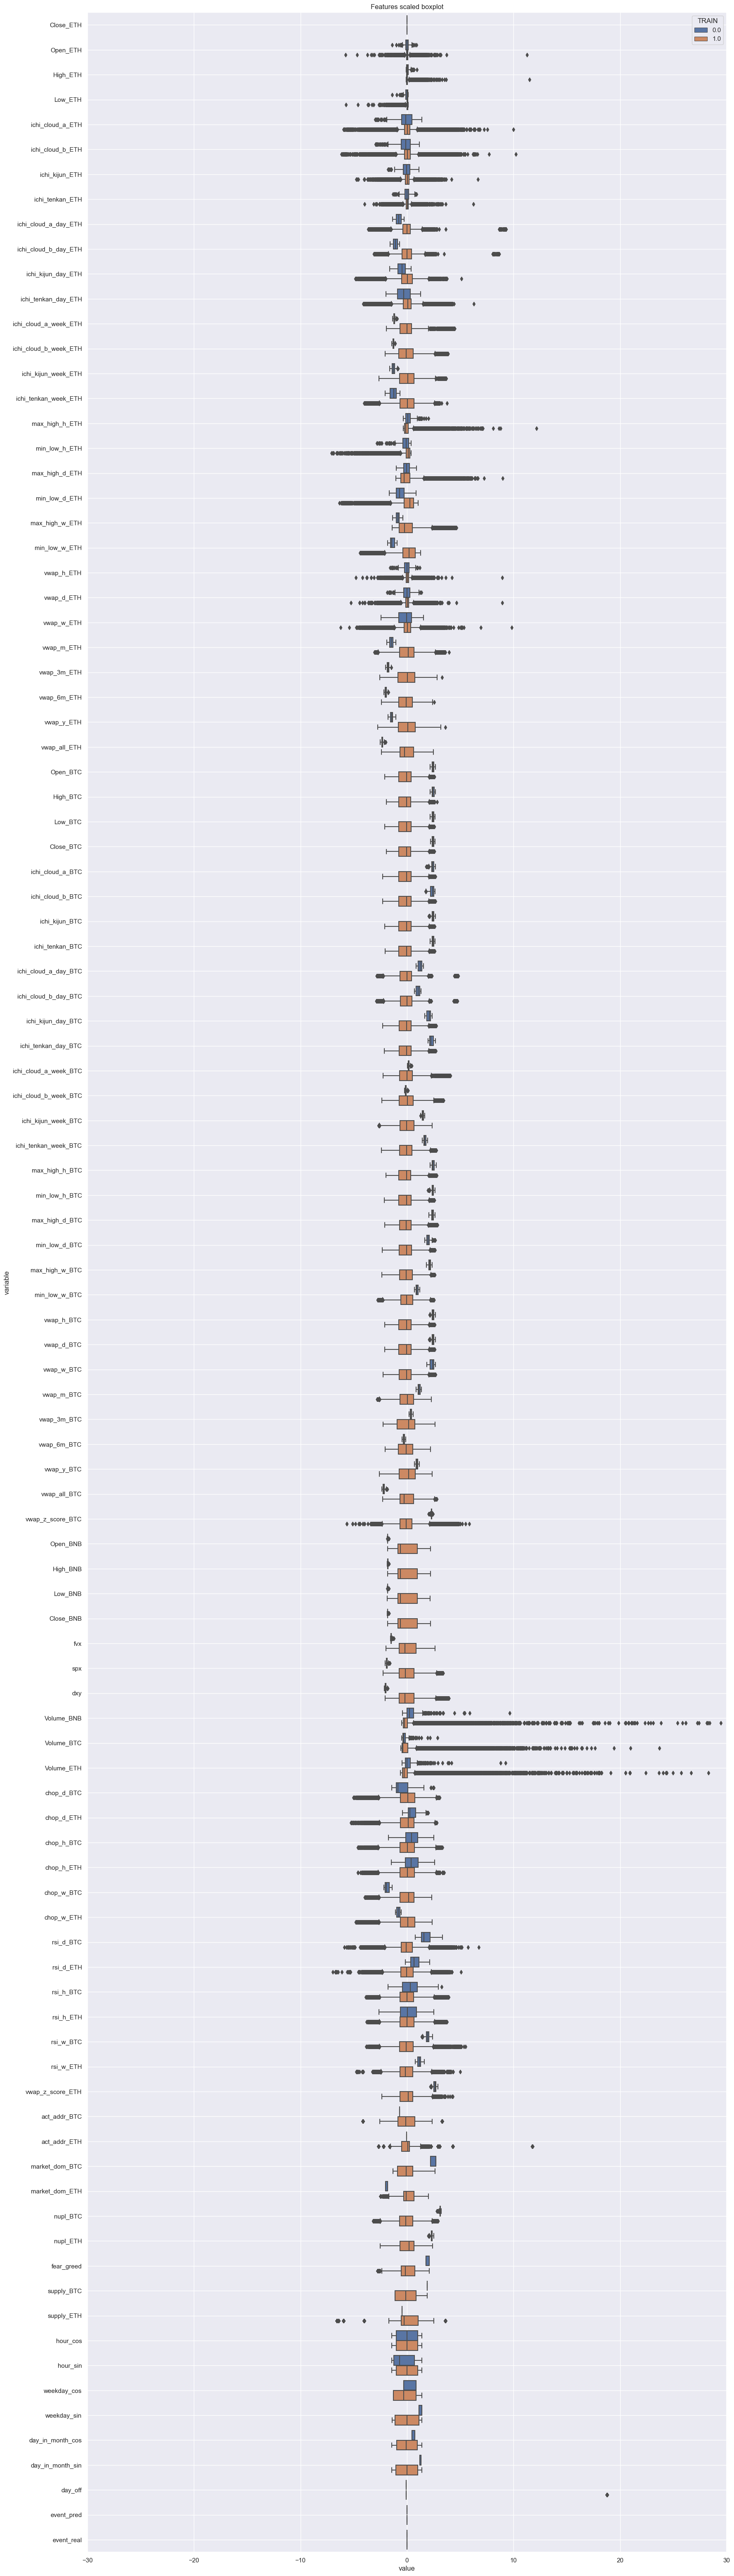

In [62]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim([-30,30])
ax.yaxis.grid(True)
plt.title("Features scaled boxplot")

<Axes: >

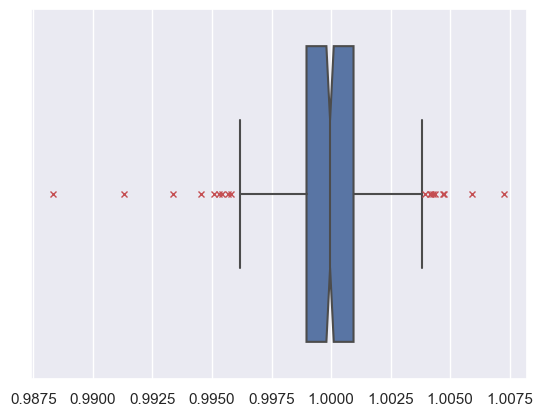

In [63]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


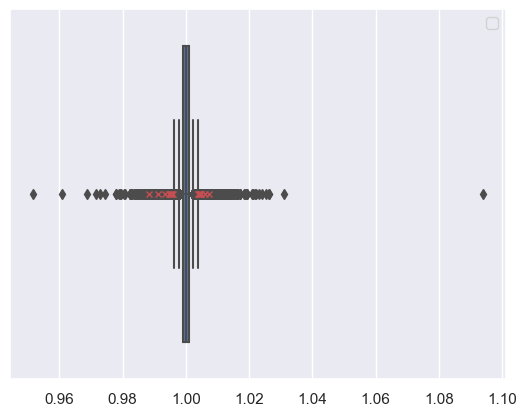

In [64]:
ax = sns.boxplot(
    x=X_train[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

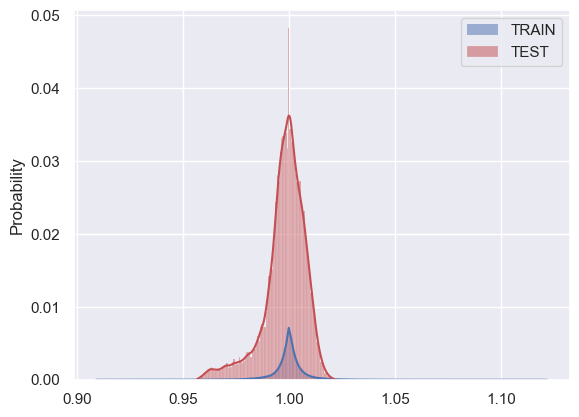

In [65]:

ax = sns.histplot(x=X_train.reshape(-1, X_train.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [66]:
X_train_sca.shape

(97342, 72, 102)

In [67]:
X_train_sca[:,-1,:].shape

(97342, 102)

In [68]:
y_train_sca[:,0][:, np.newaxis]

array([[ 0.10151008],
       [-0.03401831],
       [-0.20760989],
       ...,
       [ 0.3003439 ],
       [-0.10559121],
       [ 0.06435729]])

In [69]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(97342, 103)

In [70]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [71]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [72]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (16, 16*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

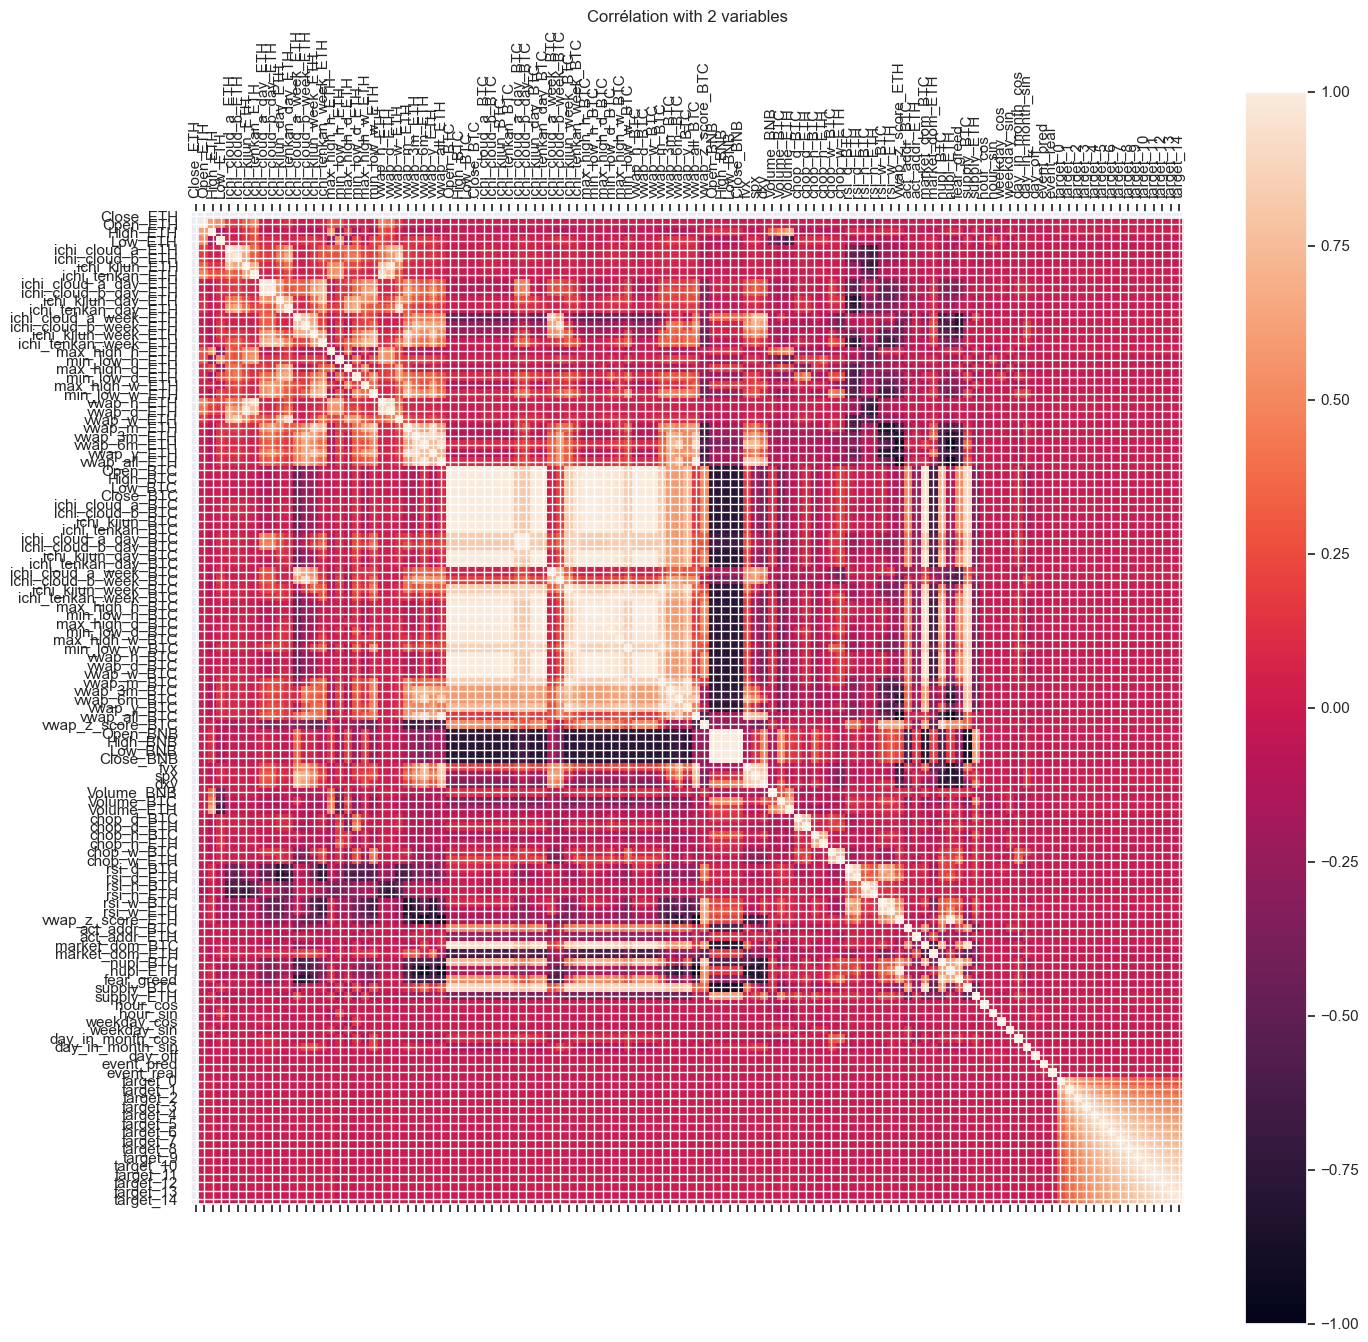

In [73]:

nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


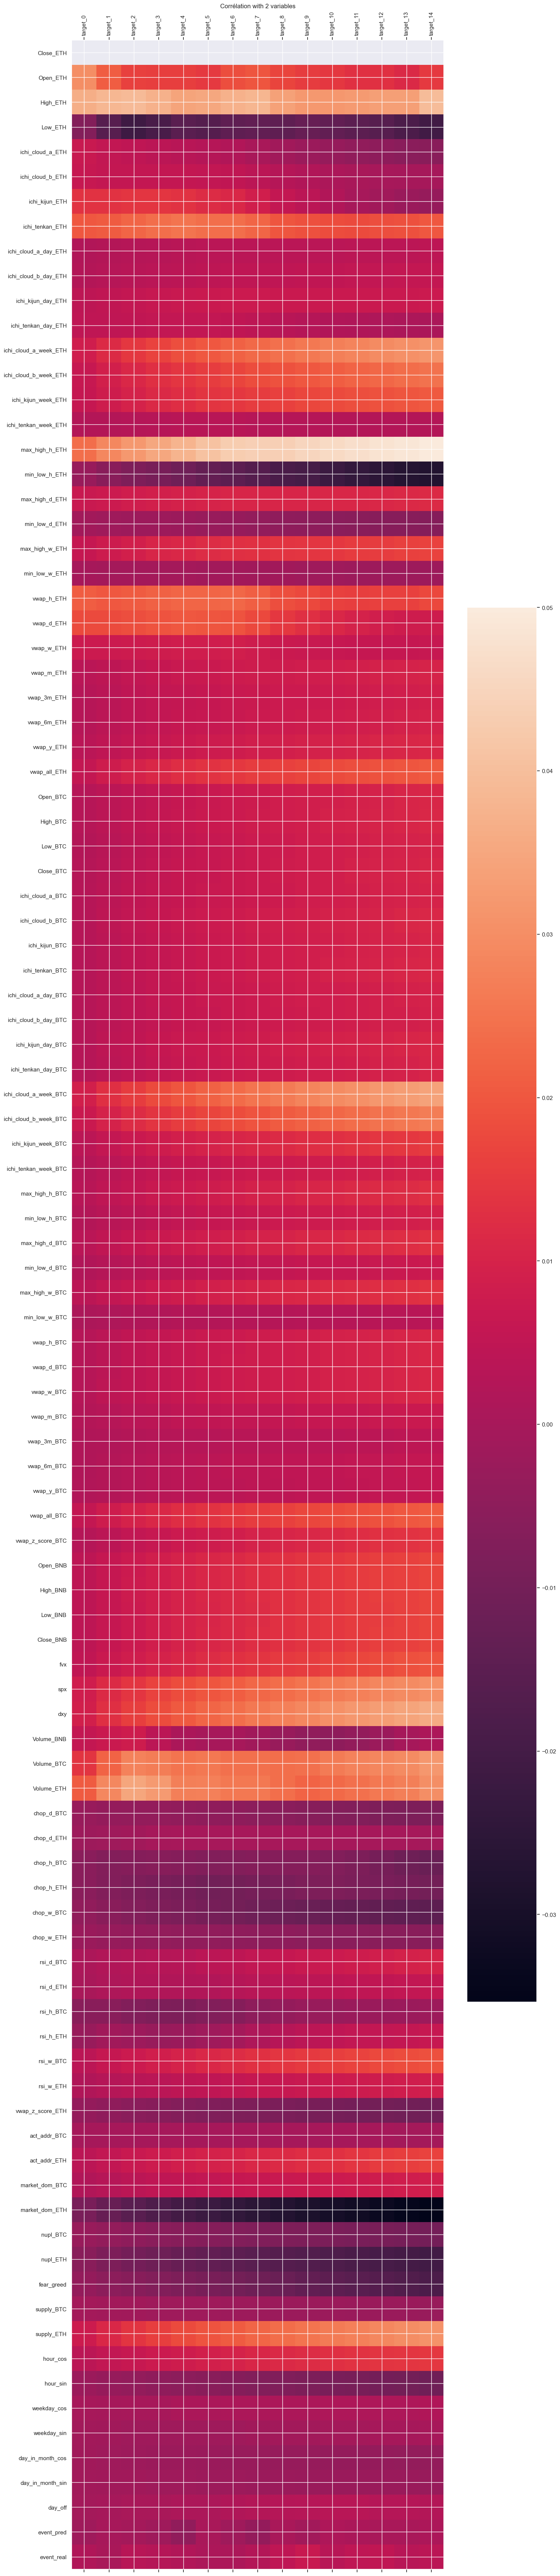

In [74]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(corr_matrix_targets)


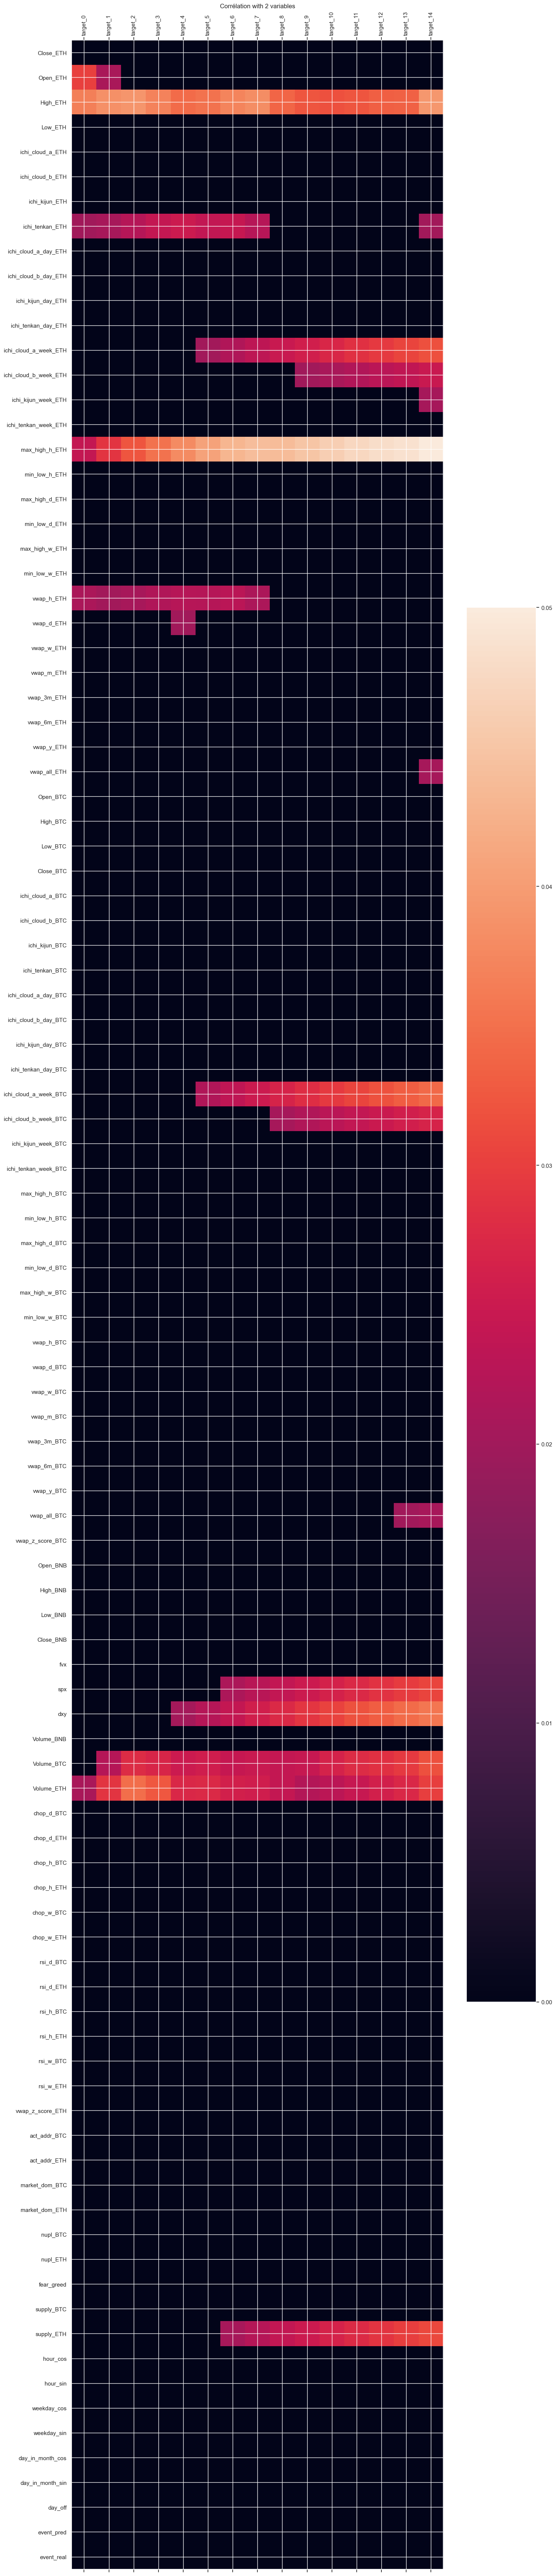

In [75]:
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0))

In [76]:
list_ichi_level=["lower", "neutral", "higher"]
df["ichi_cloud_a_week_cat"] = "neutral"
df.loc[df["ichi_cloud_a_week_ETH"] >= 1.05, "ichi_cloud_a_week_cat"] = "lower"
df.loc[df["ichi_cloud_a_week_ETH"] <= 0.95, "ichi_cloud_a_week_cat"] = "higher"

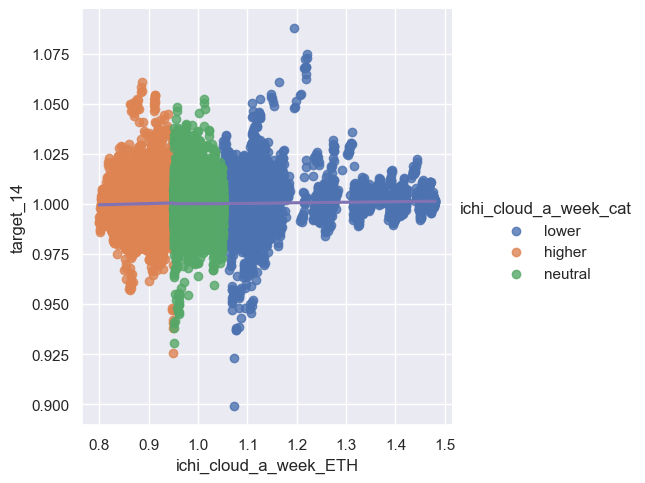

In [77]:
sns.lmplot(x="ichi_cloud_a_week_ETH", y="target_14",
            hue="ichi_cloud_a_week_cat", data=df,
           line_kws={"color": "C4"})

<Axes: xlabel='target_14', ylabel='ichi_cloud_a_week_cat'>

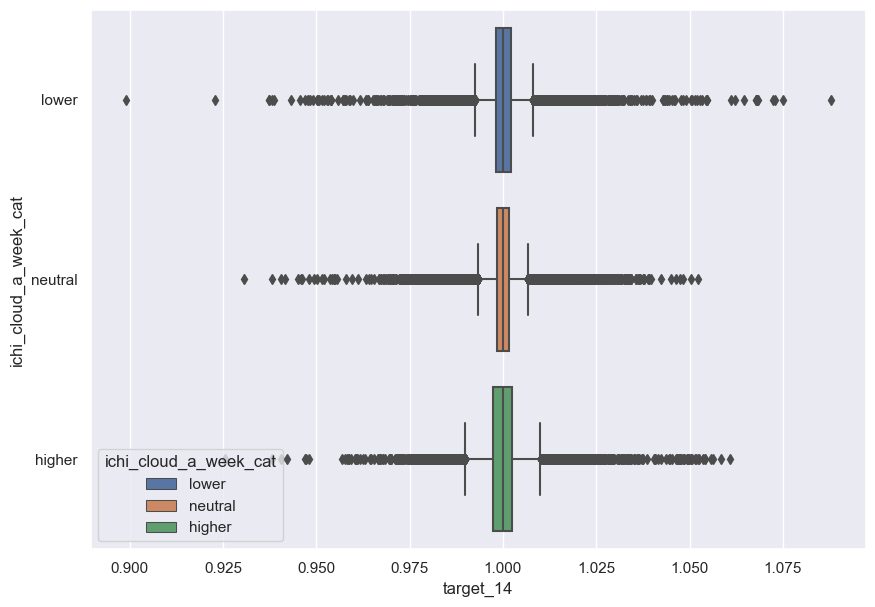

In [78]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="ichi_cloud_a_week_cat", 
    hue="ichi_cloud_a_week_cat", dodge=False, 
    order=list_ichi_level, hue_order=list_ichi_level)

In [79]:
"""df["vwap_all_ETH_under"] = df["vwap_all_ETH"] >= 1.05
df["vwap_all_ETH_above"] = df["vwap_all_ETH"] <= 0.95
df["vwap_all_ETH_neutral"] = ((df["vwap_all_ETH"] > 0.95) & (df["vwap_all_ETH"] < 1.05))
"""
list_vwap_level=["lower", "neutral", "higher"]
df["vwap_all_ETH_cat"] = "neutral"
df.loc[df["vwap_all_ETH"] >= 1.05, "vwap_all_ETH_cat"] = "lower"
df.loc[df["vwap_all_ETH"] <= 0.95, "vwap_all_ETH_cat"] = "higher"


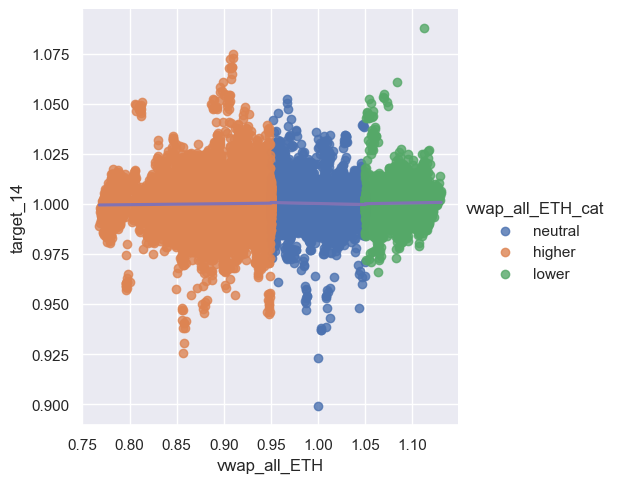

In [80]:
sns.lmplot(x="vwap_all_ETH", y="target_14", hue="vwap_all_ETH_cat", data=df,
           line_kws={"color": "C4"})

<Axes: xlabel='target_14', ylabel='vwap_all_ETH_cat'>

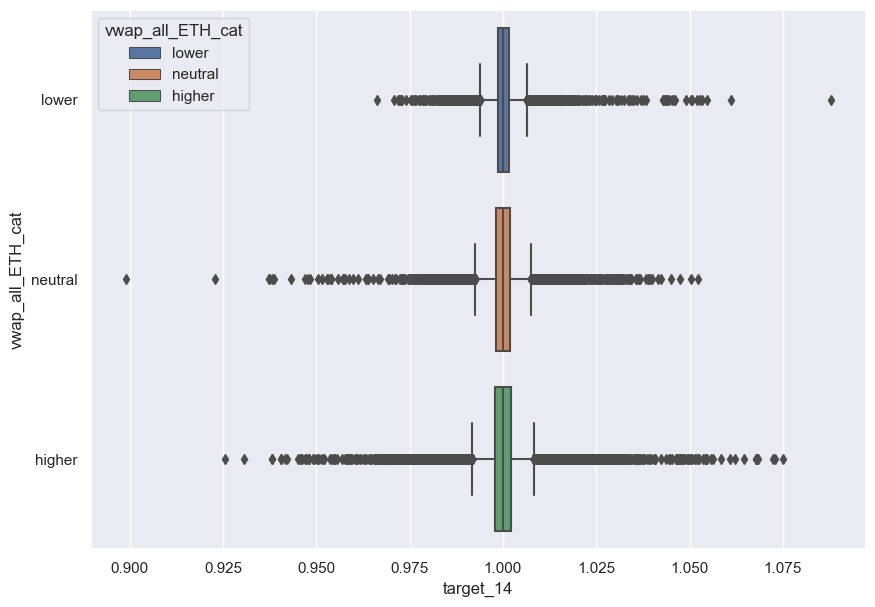

In [81]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="vwap_all_ETH_cat", 
    hue="vwap_all_ETH_cat", dodge=False, 
    order=list_vwap_level, hue_order=list_vwap_level)

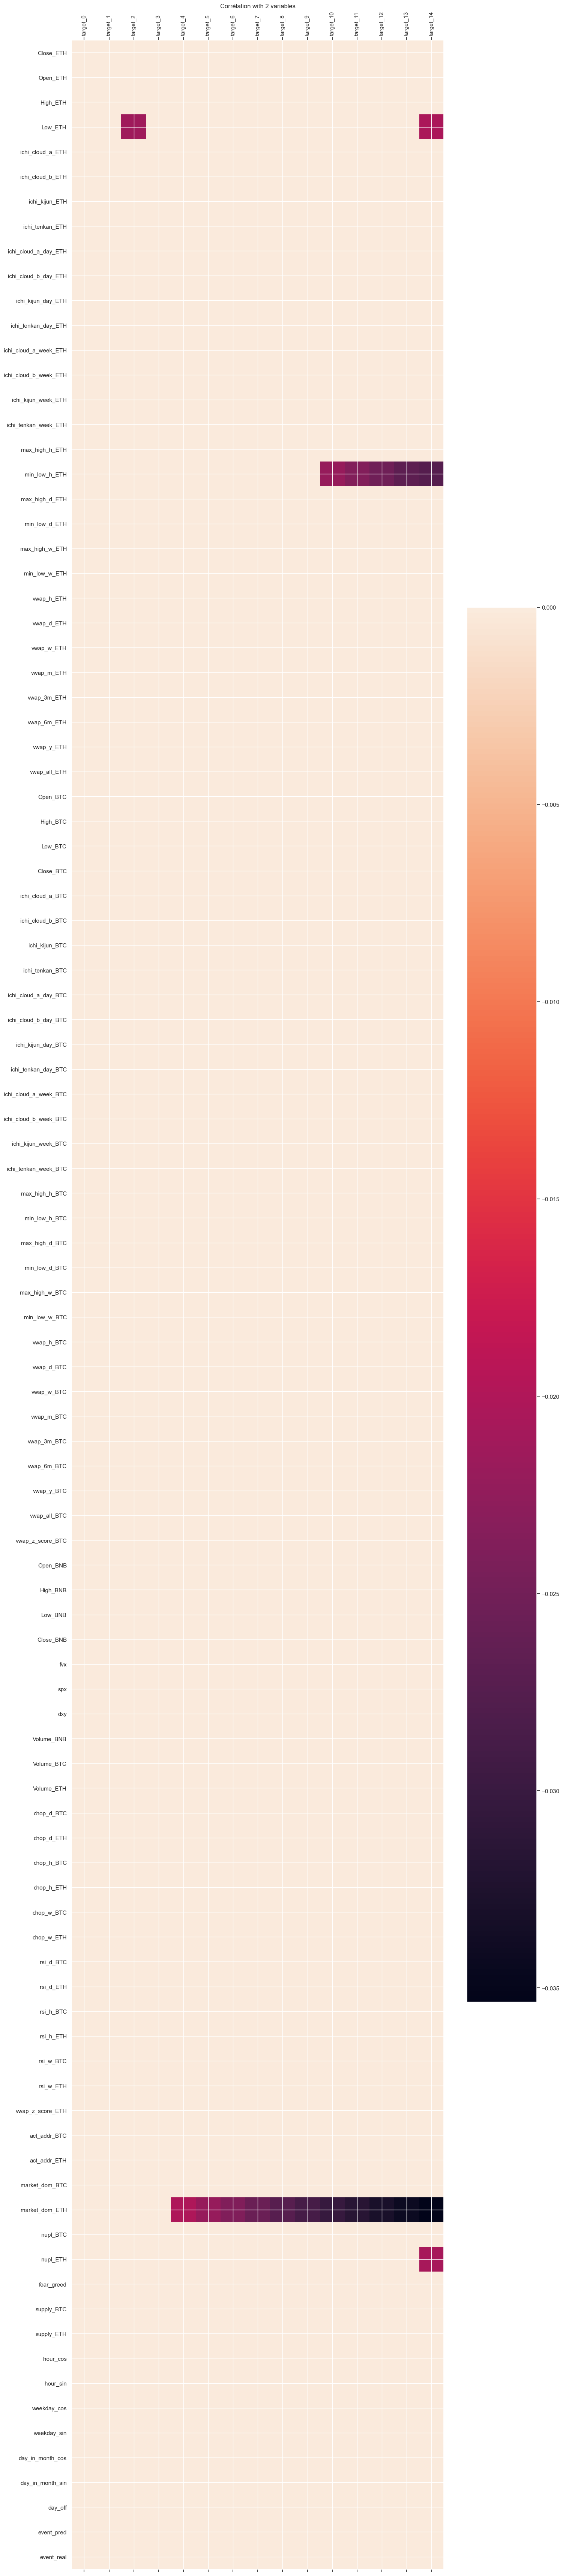

In [82]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.02, 0))

Text(0.5, 1.0, 'Net Unrealized Profit/Loss impact : ETH price = f(NUPL)')

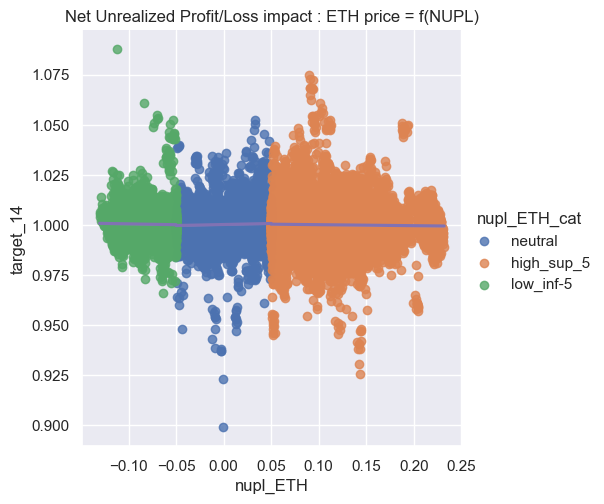

In [83]:
list_nupl_level=["low_inf-5", "neutral", "high_sup_5"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] <= -0.05, "nupl_ETH_cat"] = "low_inf-5"
df.loc[df["nupl_ETH"] >= 0.05, "nupl_ETH_cat"] = "high_sup_5"

sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})
plt.title("Net Unrealized Profit/Loss impact : ETH price = f(NUPL)")

(0.98, 1.02)

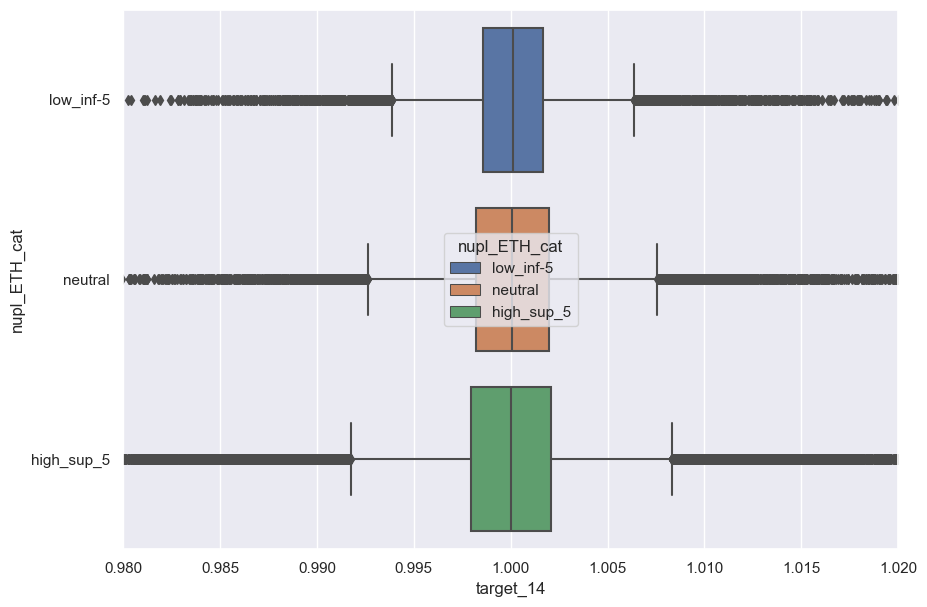

In [84]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_nupl_level, hue_order=list_nupl_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])

In [85]:
df["target_14"].describe()

count    97342.000000
mean         1.000111
std          0.005386
min          0.899006
25%          0.998116
50%          1.000042
75%          1.002003
max          1.087790
Name: target_14, dtype: float64

In [86]:
df["target_1"].describe()

count    97342.000000
mean         1.000015
std          0.002008
min          0.907143
25%          0.999264
50%          1.000005
75%          1.000765
max          1.053076
Name: target_1, dtype: float64

<Axes: xlabel='target_14'>

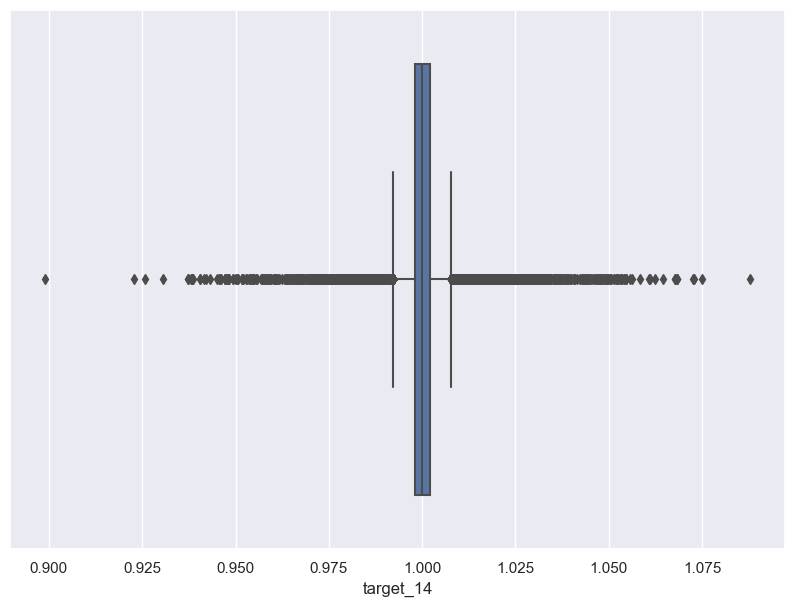

In [87]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

In [88]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00124641, 1.00088773, 1.00120157, ..., 0.99892845, 0.99933196,
        0.99978928],
       [0.99964177, 0.99995522, 1.00067168, ..., 0.99808794, 0.99854468,
        0.99863424],
       [1.00031357, 1.00103029, 1.00107956, ..., 0.99890252, 0.99899211,
        0.99896971]])

In [89]:
y_train_sca

array([[ 0.10151008,  0.08245017, -0.11026674, ..., -0.04249815,
         0.02315266, -0.05096923],
       [-0.03401831, -0.22664652, -0.05730304, ..., -0.09328853,
        -0.1673763 , -0.31766865],
       [-0.20760989, -0.03825365, -0.15891997, ..., -0.14833521,
        -0.29863887, -0.37061527],
       ...,
       [ 0.3003439 ,  0.2096069 ,  0.28900177, ..., -0.28604394,
        -0.18396482, -0.06827515],
       [-0.10559121, -0.02629517,  0.15495291, ..., -0.49867299,
        -0.38312734, -0.36047133],
       [ 0.06435729,  0.24567032,  0.25813559, ..., -0.29260275,
        -0.26993862, -0.27560466]])

## Autoencoder

### Model creation

### Training

In [90]:
X_train_sca.shape

(97342, 72, 102)

In [91]:
3*3*3*10*35/3600

2.625

In [92]:
#tf.keras.optimizers.AdamW()

In [93]:
#tf.keras.optimizers.legacy.AdamW()

In [94]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5
#epochs = 500 #100 #150 #6 #300
#patience = 0 #30 #20 #40 #3 #100
mse_curr_min = None
if MODE_TRAIN_AE:
    for n_unit_enc in LIST_UNITS_AE: #[32, 64, 128]: #[104]: #
        for encoding_dim in LIST_UNITS_ENC_AE:#[16, 20, 32]:
            for dropout_autoenc in LIST_DROPOUT_AE: #[0.05, 0.15, 0.25]: #[0.25]:
                for seed in LIST_SEEDS:
                    # check already done ? 
                    #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
                    plt_name = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                    path_jpg = os.path.join(path_data,
                        f"output_MSE autoencoder - {plt_name}.jpg")
                    if (MODE_TRAIN_AE == False):
                        print(f"BE CAREFUL ! training inactivated => no training done...")
                        continue
                    print(f"Training: {plt_name} ...")
                    # Init
                    tf.keras.backend.clear_session()
                    np.random.seed(seed)
                    random.seed(seed)
                    tf.random.set_seed(seed)
                    # Input dimension
                    input_dim = X_train.shape[-1]
                    # Reduced encoded input dimension
                    # 64/8/0.5
                    # Définir l'encodeur
                    encoder_inputs = keras.Input(shape=(None, input_dim))
                    encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
                    #encoder = layers.LayerNormalization()(encoder)
                    #encoder = layers.Dense(encoding_dim, activation='relu')
                    encoder = layers.Dropout(dropout_autoenc)(encoder)
                    encoder_outputs = layers.Dense(encoding_dim)(encoder)
                    encoder_model = keras.Model(encoder_inputs, encoder_outputs)
                    print(encoder_model.summary())
                    # Définir le décodeur
                    decoder_inputs = keras.Input(shape=(None, encoding_dim))
                    decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
                    #decoder = layers.LayerNormalization()(decoder)
                    #decoder = layers.Dense(n_unit_enc, activation='relu')
                    decoder = layers.Dropout(dropout_autoenc)(decoder)
                    decoder_outputs = layers.Dense(input_dim)(decoder)
                    decoder_model = keras.Model(decoder_inputs, decoder_outputs)
                    print(decoder_model.summary())
                    # Define complete autoencoder 
                    autoencoder_inputs = keras.Input(shape=(None, input_dim))
                    encoded = encoder_model(autoencoder_inputs)
                    decoded = decoder_model(encoded)
                    autoencoder = keras.Model(autoencoder_inputs, decoded)
                    # Compile : autoencoder
                    optim = tf.keras.optimizers.legacy.Adam()
                    #optim = tf.keras.optimizers.AdamW()
                    #optim = tf.keras.optimizers.Adam()
                    autoencoder.compile(optimizer=optim, loss="mse")
                    # earlystop 
                    es = EarlyStopping(patience=PATIENCE_AE, verbose=2, min_delta=0.001, 
                                    monitor='val_loss', mode='auto', restore_best_weights=True)
                    # Train
                    if PATIENCE_AE == 0:
                        autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                        epochs=EPOCHS_AE, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                        verbose=1)
                    else:
                        autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                            epochs=EPOCHS_AE, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                            verbose=1, callbacks=[es])

                    plot_train_history(
                        autoenc_step_history,f"MSE autoencoder - {plt_name}",
                        saveFolder=path_data)
                    #autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                    #encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                                # save the best
                    mse_curr = np.min(autoenc_step_history.history['val_loss'])
                    print("MSE TEST : ", mse_curr)

                    if mse_curr_min == None:
                        seed_min = seed
                        autoenc_step_history_min = autoenc_step_history
                        mse_curr_min = mse_curr
                        n_unit_enc_min = n_unit_enc
                        encoding_dim_min = encoding_dim
                        dropout_autoenc_min = dropout_autoenc
                        print("Save autoencoder: ", path_mdl_autoencoder)
                        autoencoder.save(path_mdl_autoencoder)
                        print("Save encoder: ", path_mdl_encoder)
                        encoder_model.save(path_mdl_encoder)
                    else:
                        if mse_curr < mse_curr_min:
                            seed_min = seed
                            autoenc_step_history_min = autoenc_step_history
                            mse_curr_min = mse_curr
                            n_unit_enc_min = n_unit_enc
                            encoding_dim_min = encoding_dim
                            dropout_autoenc_min = dropout_autoenc
                            print("Save autoencoder: ", path_mdl_autoencoder)
                            autoencoder.save(path_mdl_autoencoder)
                            print("Save encoder: ", path_mdl_encoder)
                            encoder_model.save(path_mdl_encoder)

    mse_curr = mse_curr_min 
    n_unit_enc = n_unit_enc_min 
    encoding_dim = encoding_dim_min
    dropout_autoenc = dropout_autoenc_min

print("Load models...")
autoencoder = tf.keras.models.load_model(path_mdl_autoencoder)
print(autoencoder.summary())
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print(encoder_model.summary())
n_unit_enc = encoder_model.layers[1].units
dropout_autoenc = encoder_model.layers[2].rate
encoding_dim = encoder_model.layers[3].units
print(f"Model : n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")

if MODE_TRAIN_AE:
    print(f"Best model : seed:{seed} / n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")
    plot_train_history(
        autoenc_step_history_min, 
        f"Best MSE autoencoder - {plt_name}",
        saveFolder=path_data,
    )

Load models...
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 102)]       0         
                                                                 
 model (Functional)          (None, None, 32)          1275936   
                                                                 
 model_1 (Functional)        (None, None, 102)         1168486   
                                                                 
Total params: 2444422 (9.32 MB)
Trainable params: 2444422 (9.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 102)]       0         
                                                    

In [95]:
path_mdl_autoencoder

'data/mdl_autoencoder'

In [96]:
#autoencoder.save(path_mdl_autoencoder)
#encoder_model.save(path_mdl_encoder)


In [97]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

3042/3042 [==============================] - 65s 21ms/step


(97342, 72, 102)

### Results

In [98]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

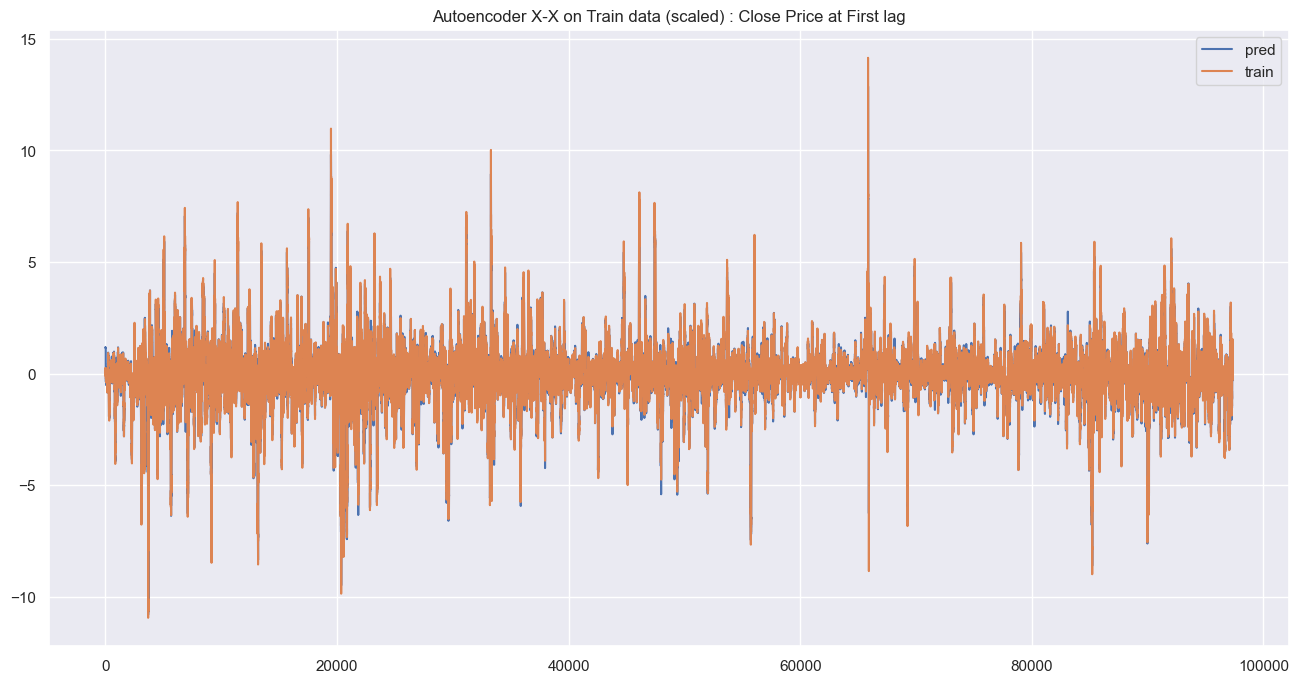

In [99]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

##### MAE TRAIN by lags and by features

In [100]:
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)

mae_ae_train = np.mean(np.abs(X_train_sca_pred - X_train_sca), 0)
print(mae_ae_train.shape)

df_mae_ae_train = pd.DataFrame(mae_ae_train, columns=list_col_select)
df_mae_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_train.index))]
mae_ae_train_feat = np.mean(mae_ae_train, 0)[np.newaxis,:]
print(mae_ae_train_feat.shape)

df_mae_ae_train_feat = pd.DataFrame(mae_ae_train_feat, columns=list_col_select)

(97342, 72, 102)
(97342, 72, 102)
(72, 102)
(1, 102)


In [101]:
df_mae_ae_train

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.082180  0.096493  0.066700  0.072312          0.105605   
lag_1    0.062623  0.062436  0.049920  0.057470          0.092679   
lag_2    0.052935  0.052657  0.044079  0.051428          0.088960   
lag_3    0.048934  0.047445  0.041826  0.048828          0.087767   
lag_4    0.045637  0.042536  0.038580  0.046075          0.086538   
...           ...       ...       ...       ...               ...   
lag_67   0.037023  0.033987  0.030907  0.040177          0.045092   
lag_68   0.036966  0.033950  0.030851  0.040154          0.045083   
lag_69   0.036905  0.033937  0.030823  0.040133          0.045068   
lag_70   0.036843  0.033908  0.030791  0.040110          0.045052   
lag_71   0.036783  0.033910  0.030742  0.040091          0.045053   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.089366        0.101897         0.087416   
lag_1           0.071634        0.088342         0.074594   
lag_2           0.065262        0.082142         0.069181   
lag_3           0.061907        0.078641         0.065034   
lag_4           0.059369        0.074763         0.059137   
...                  ...             ...              ...   
lag_67          0.040574        0.044113         0.041102   
lag_68          0.040556        0.044100         0.041066   
lag_69          0.040536        0.044078         0.041046   
lag_70          0.040512        0.044065         0.041023   
lag_71          0.040483        0.044041         0.041000   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  \
lag_0               0.101263              0.098476  ...    0.097833  0.079686   
lag_1               0.075808              0.071735  ...    0.053836  0.047077   
lag_2               0.065920              0.061474  ...    0.039534  0.042804   
lag_3               0.059576              0.055550  ...    0.032105  0.044492   
lag_4               0.055357              0.051924  ...    0.028598  0.046095   
...                      ...                   ...  ...         ...       ...   
lag_67              0.037641              0.037650  ...    0.020348  0.038155   
lag_68              0.037671              0.037677  ...    0.020351  0.038088   
lag_69              0.037696              0.037703  ...    0.020350  0.038016   
lag_70              0.037727              0.037734  ...    0.020354  0.037947   
lag_71              0.037768              0.037777  ...    0.020353  0.037879   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
lag_0   0.077654     0.079919     0.081674          0.103458   
lag_1   0.046512     0.046213     0.045889          0.056699   
lag_2   0.042189     0.039609     0.039551          0.045391   
lag_3   0.044331     0.037901     0.038477          0.041677   
lag_4   0.045967     0.035560     0.036531          0.039521   
...          ...          ...          ...               ...   
lag_67  0.041881     0.031010     0.034773          0.035324   
lag_68  0.041857     0.031013     0.034753          0.035329   
lag_69  0.041832     0.031006     0.034731          0.035336   
lag_70  0.041804     0.031007     0.034718          0.035344   
lag_71  0.041778     0.031008     0.034698          0.035352   

        day_in_month_sin   day_off  event_pred  event_real  
lag_0           0.098504  0.071246    0.127846    0.118075  
lag_1           0.062954  0.034011    0.078527    0.051203  
lag_2           0.050869  0.022542    0.048081    0.034919  
lag_3           0.046098  0.017775    0.034075    0.025856  
lag_4           0.043561  0.015723    0.029202    0.023873  
...                  ...       ...         ...         ...  
lag_67          0.042404  0.011847    0.020939    0.021157  
lag_68          0.042413  0.011841    0.020941    0.021145  
lag_69          0.042424  0.011838    0.020945    0.021141  
lag_70          0.042436  0.011832    0.020953    0.021140  
lag_71          0.042452  0.01182

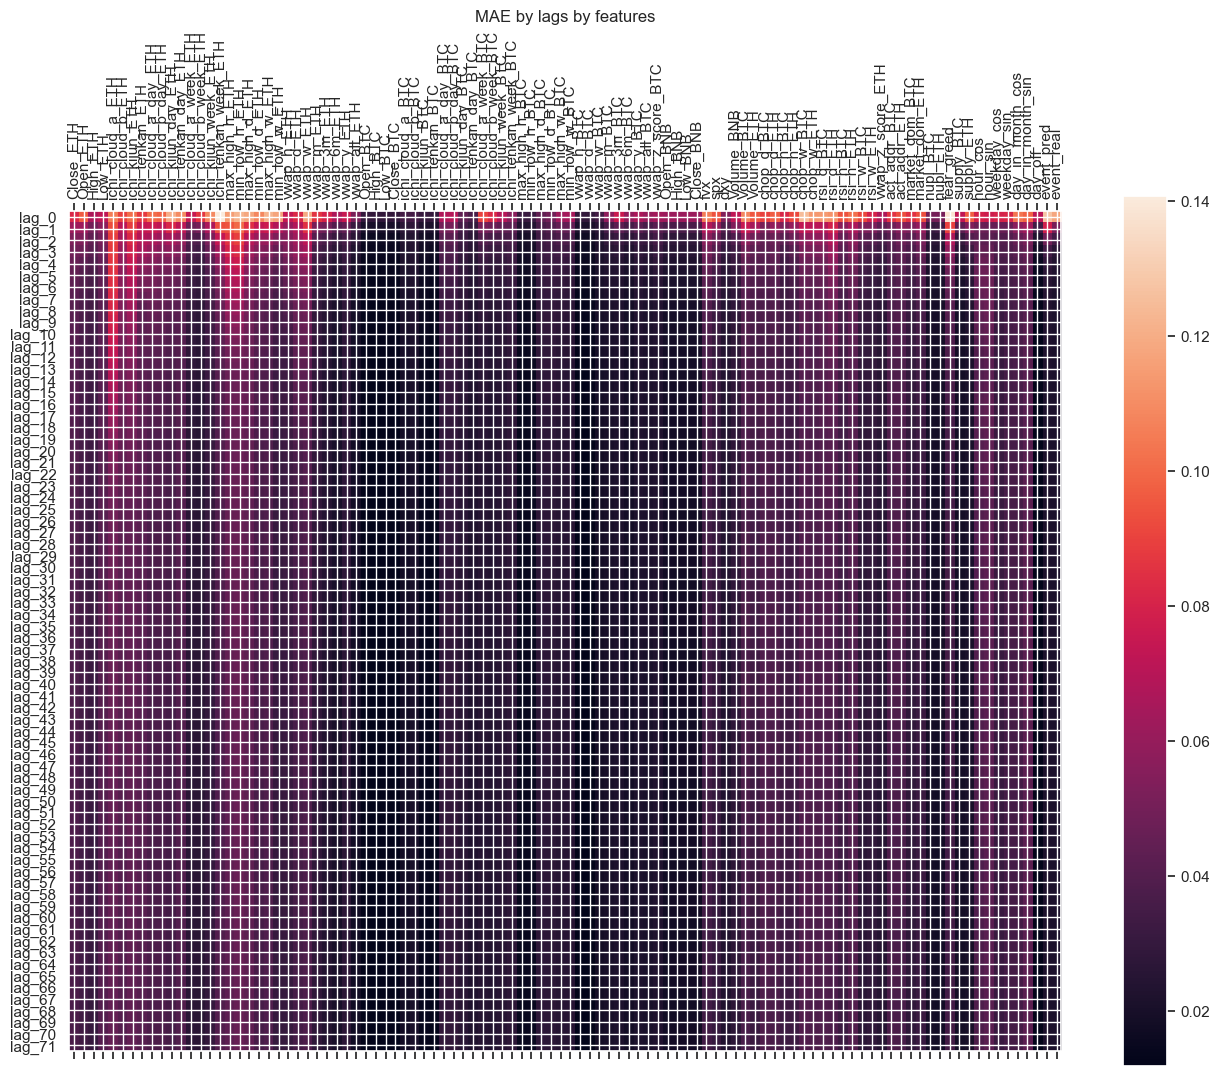

In [102]:
plot_corr(df_mae_ae_train, "MAE by lags by features", aspect=1.2 )

/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<Axes: >

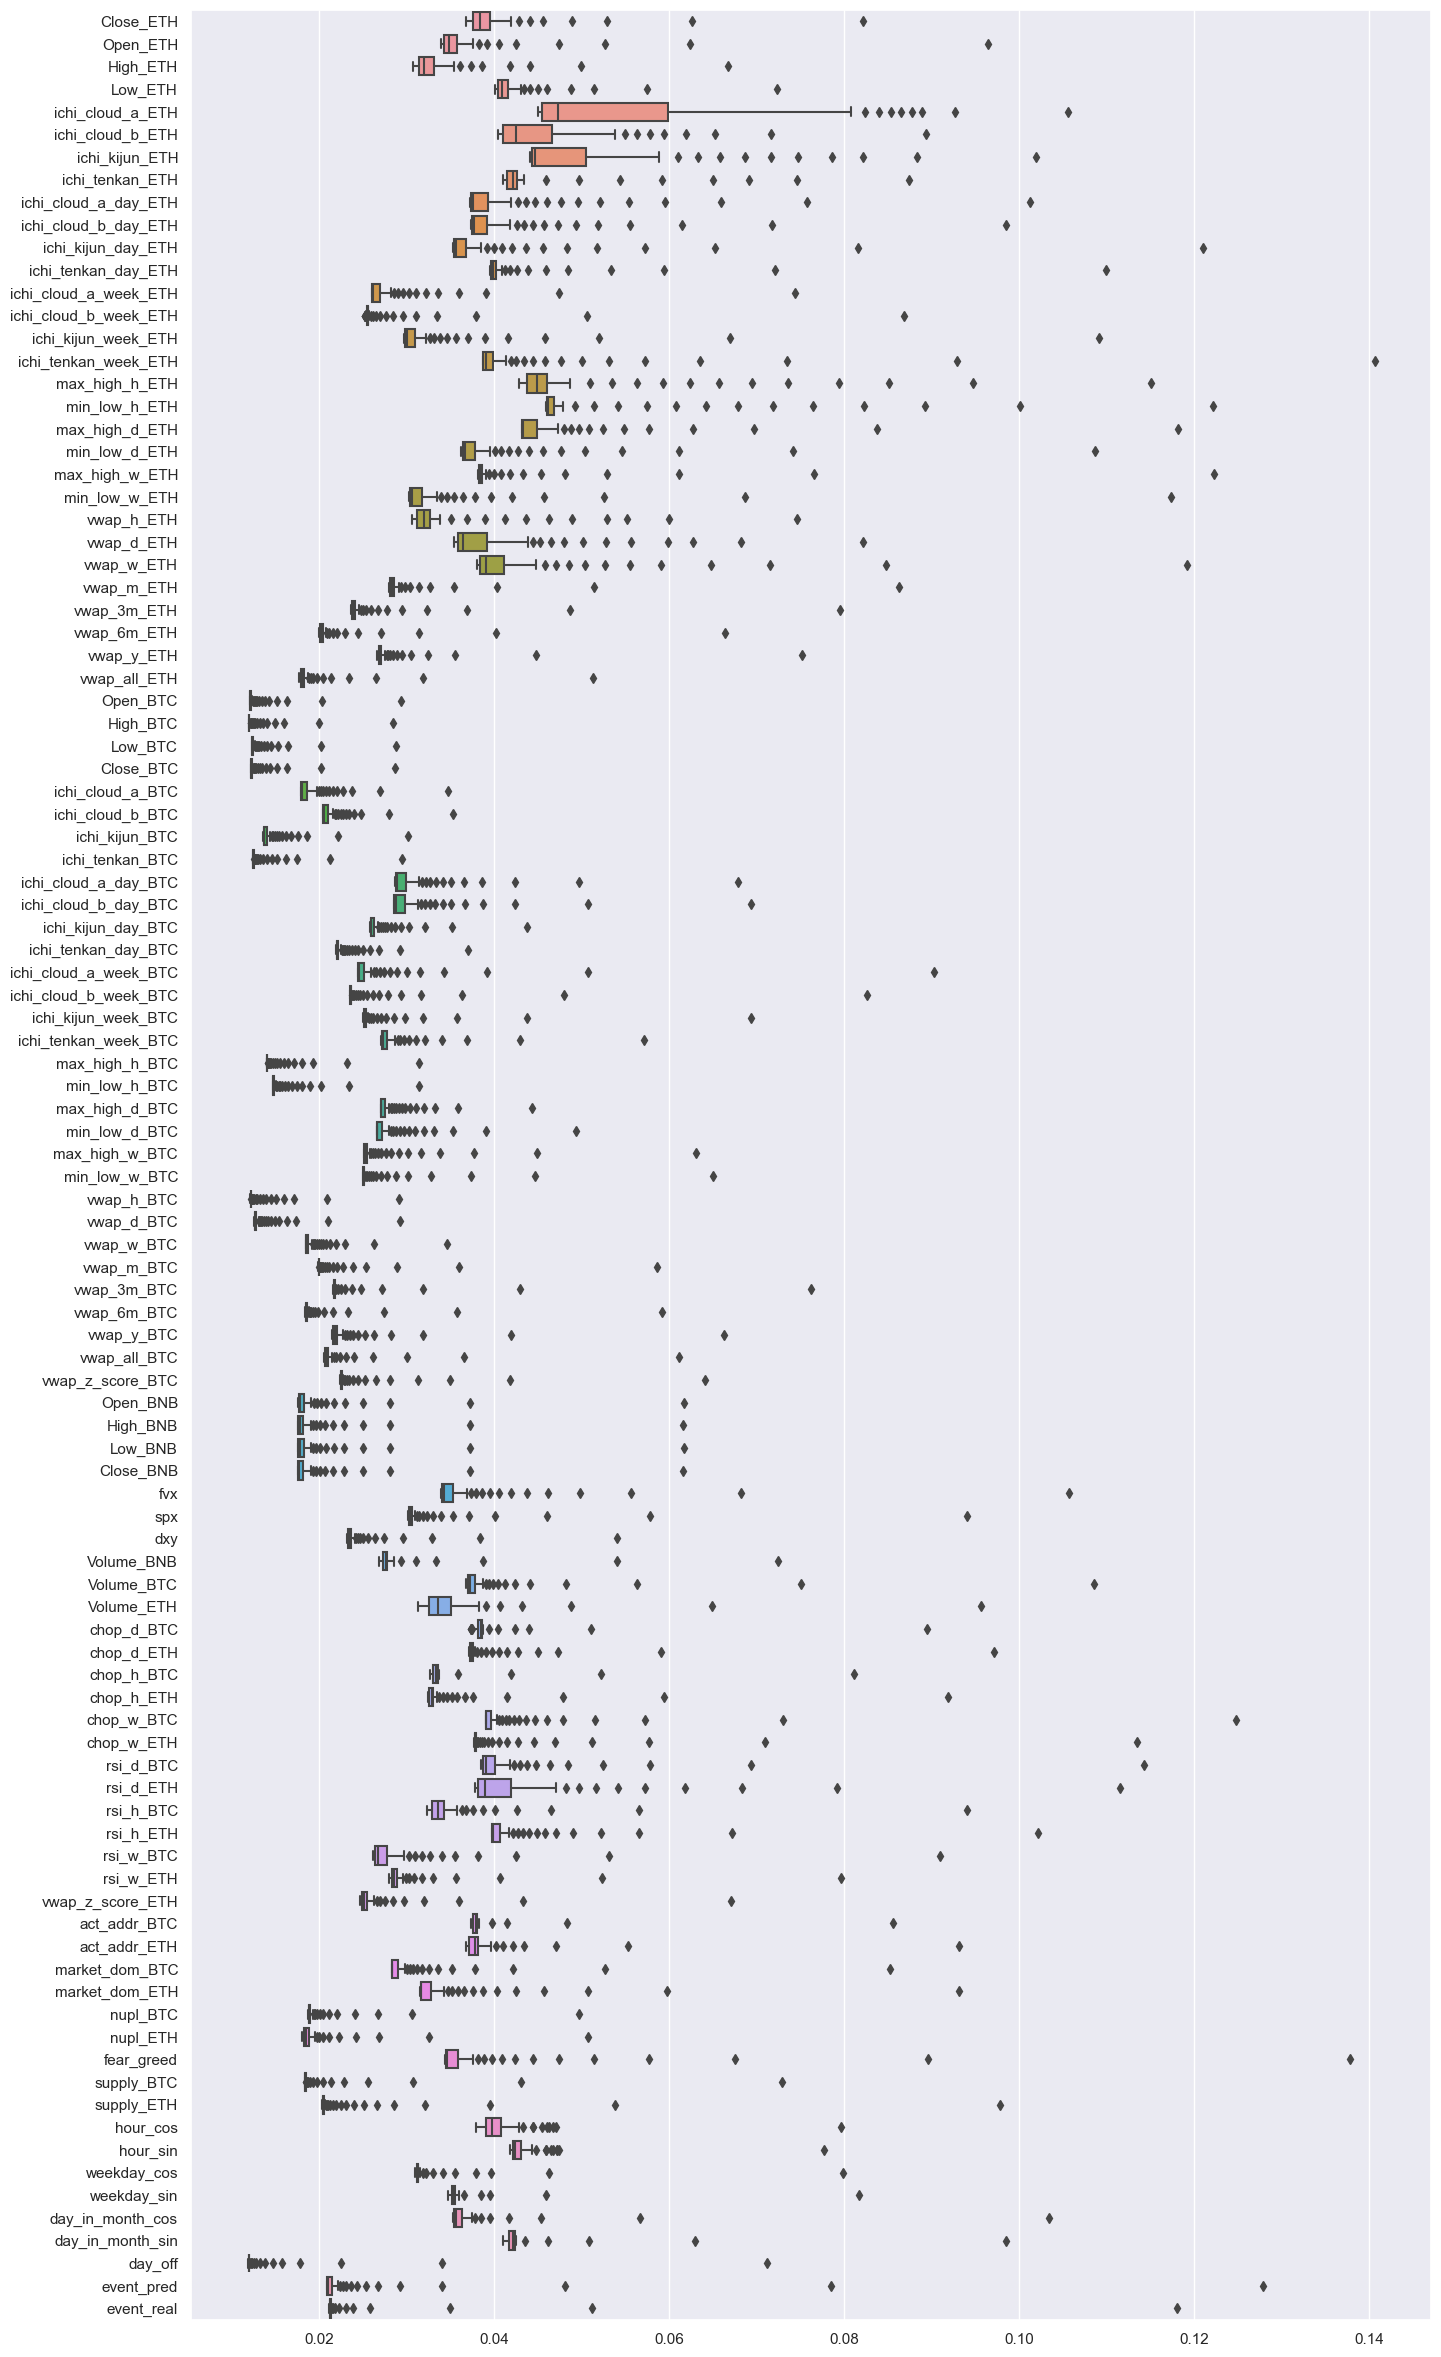

In [103]:
plt.figure(figsize=(16, 30))
sns.boxplot(data=df_mae_ae_train, orient="h")

In [104]:
df_mae_ae_train_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.039961  0.036832  0.033338  0.042067          0.055385   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.045722        0.050167         0.044296              0.041088   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.040692  ...    0.022832  0.040879  0.043389      0.03247   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0     0.036217          0.037327          0.043246  0.013484    0.024321   

   event_real  
0    0.023351  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature')

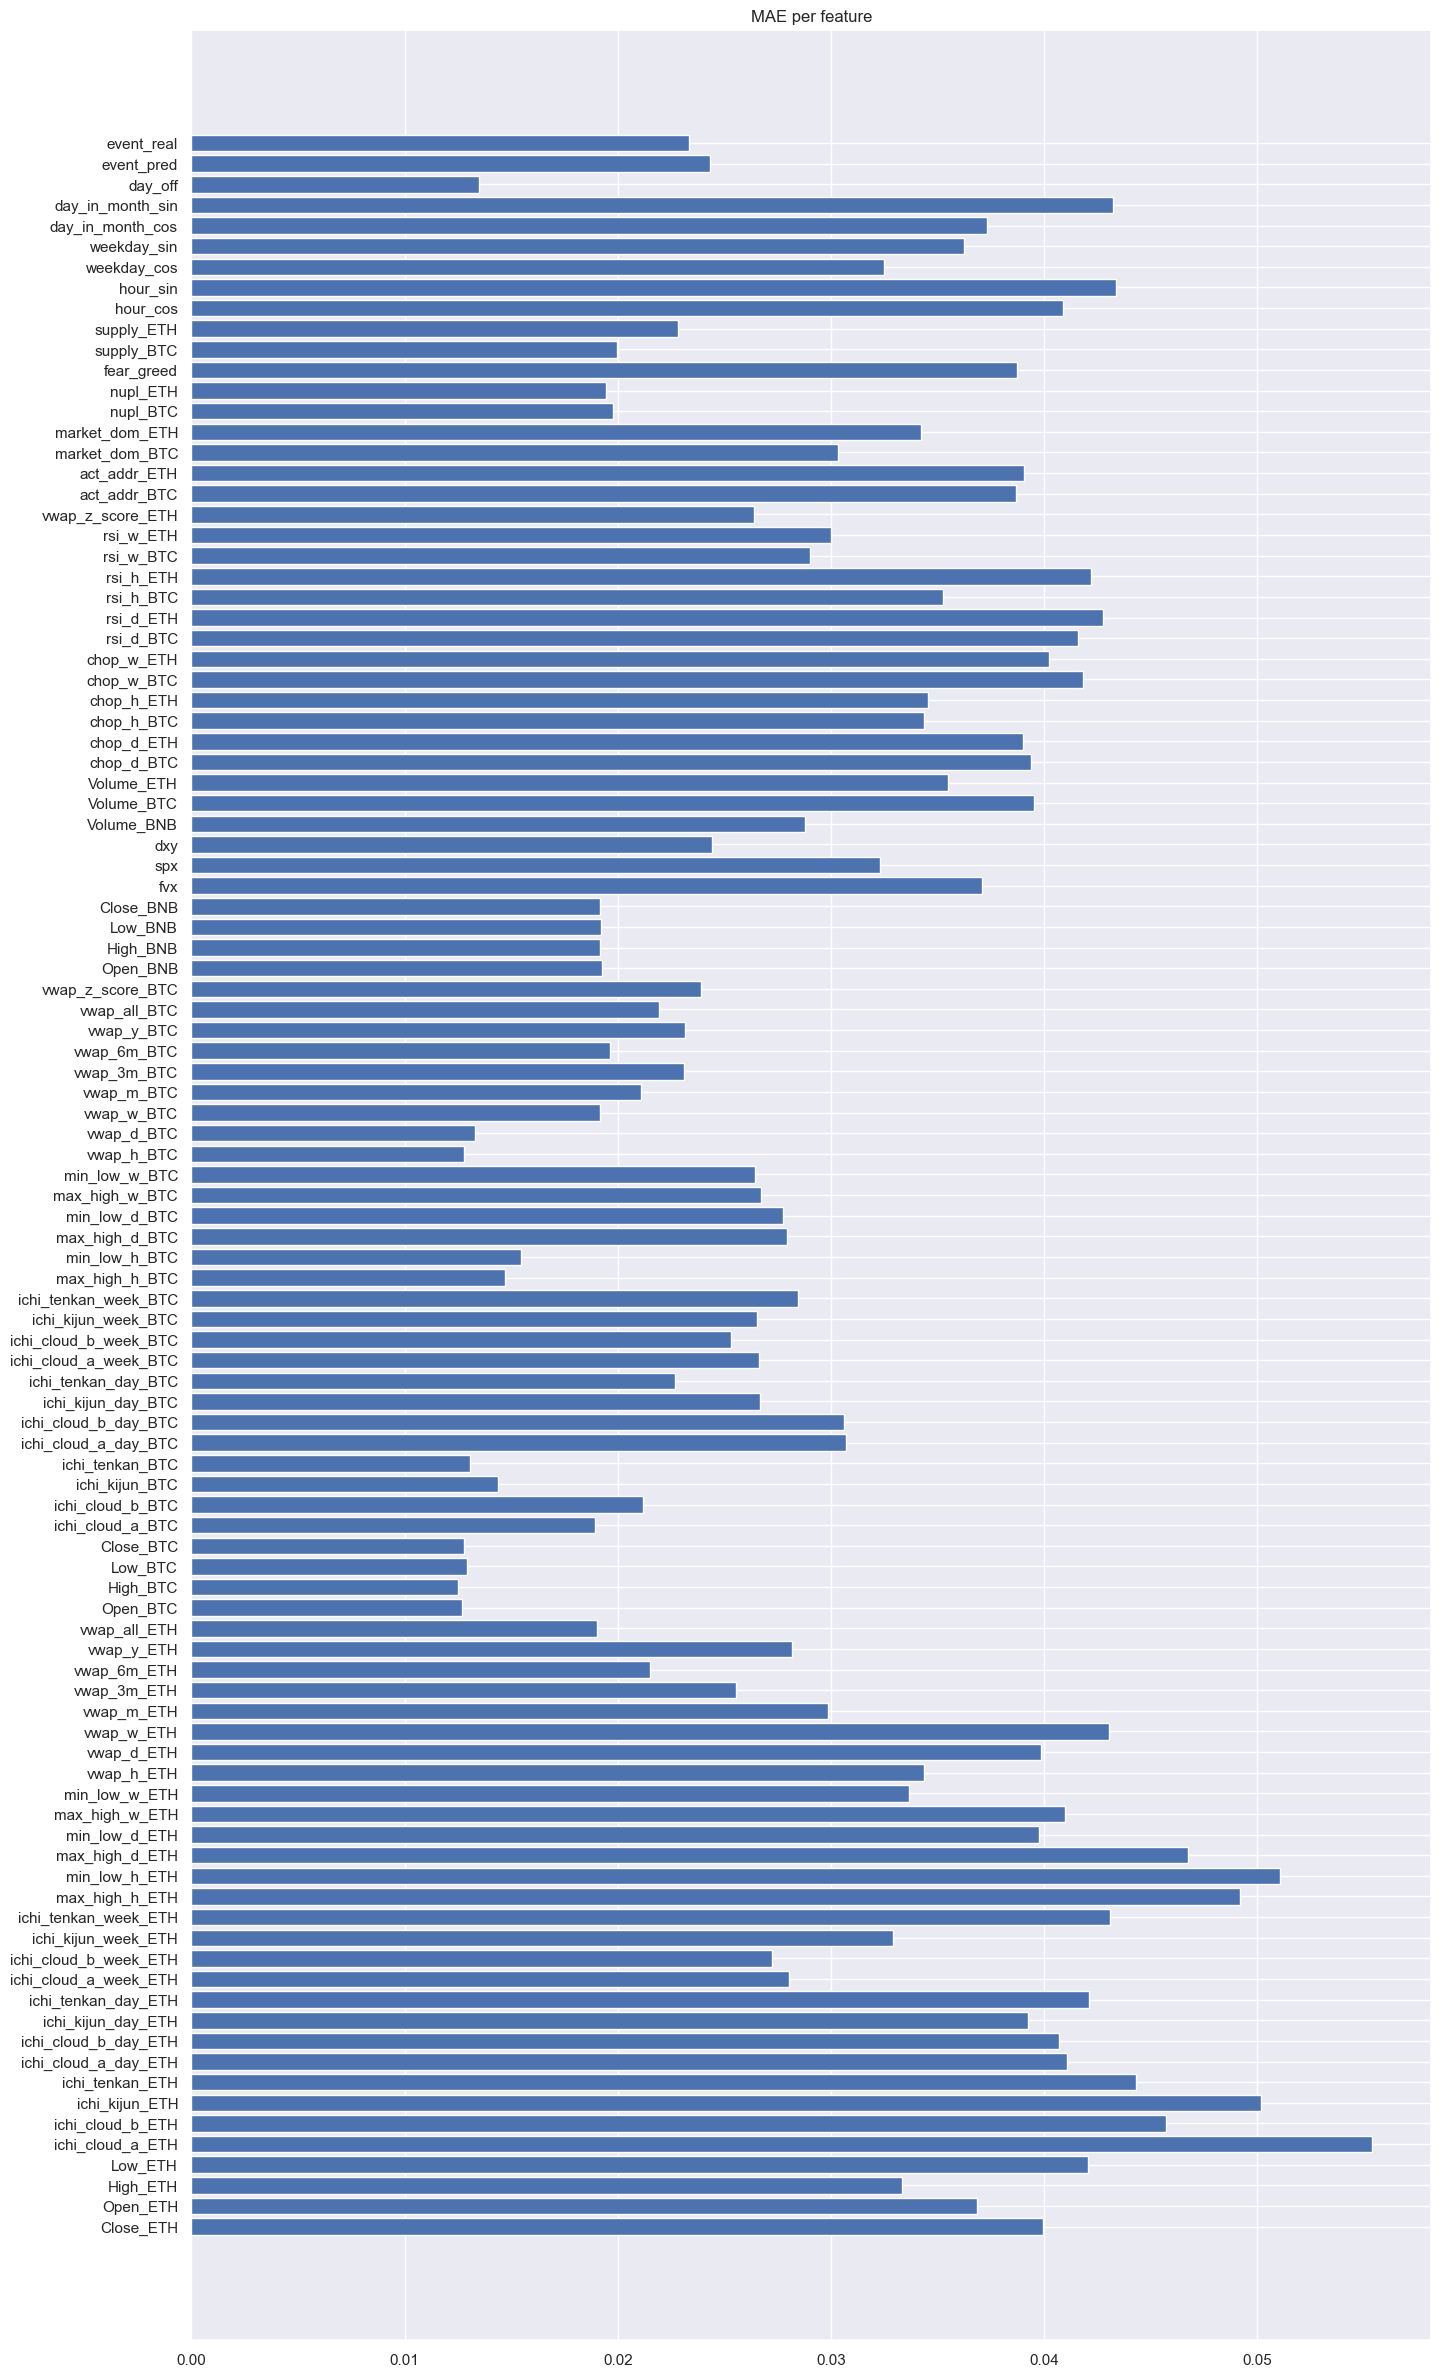

In [105]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_train_feat.columns, df_mae_ae_train_feat.values[0])
plt.title("MAE per feature")

In [106]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(97342,)
(97342,)
[1196.32 1195.38 1194.55 ... 2237.64 2237.26 2240.96]
[1196.32 1195.38 1194.55]


In [107]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([0.99992114, 1.0001105 , 1.0001813 , ..., 0.99998   , 0.9995583 ,
       0.9997727 ], dtype=float32)

[1196.32 1195.38 1194.55 ... 2237.64 2237.26 2240.96]
[1205.98997809 1206.50493215 1206.40737712 ... 2238.72238125 2236.5863964
 2239.09174091]


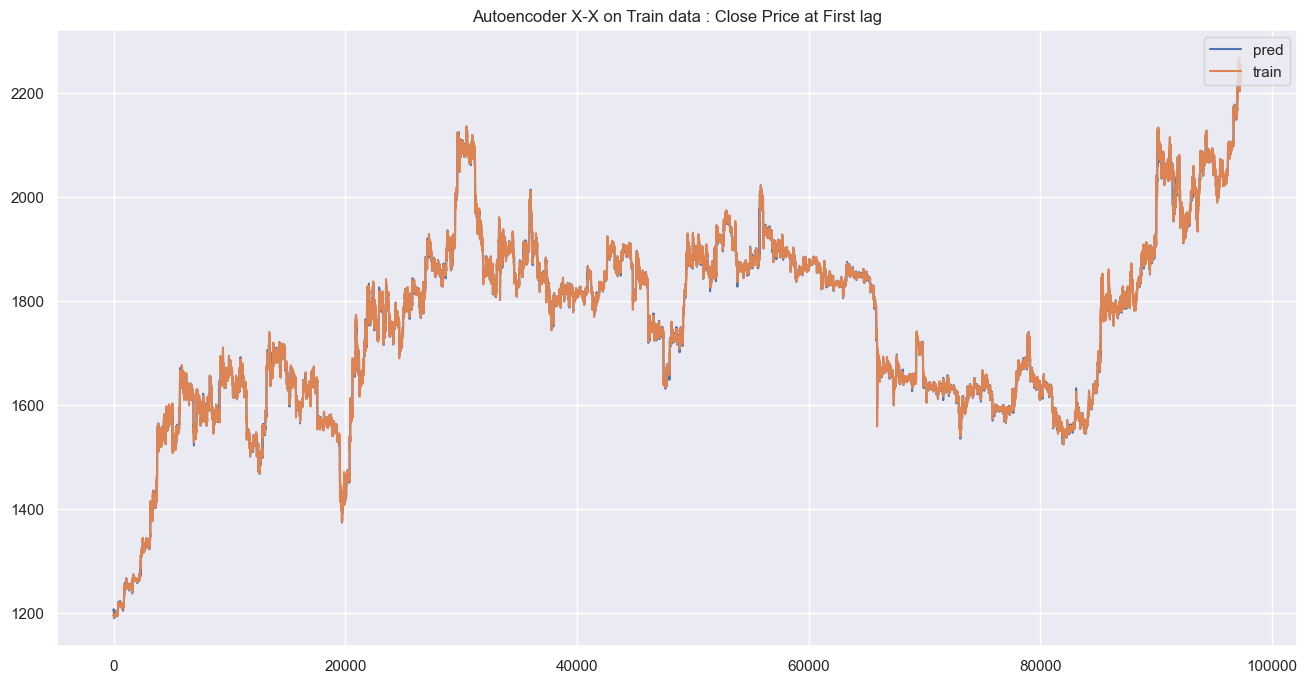

In [108]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### MAE TEST per features

In [109]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

13/13 [==============================] - 1s 36ms/step


(402, 72, 102)

In [110]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-12-05 07:00:00'

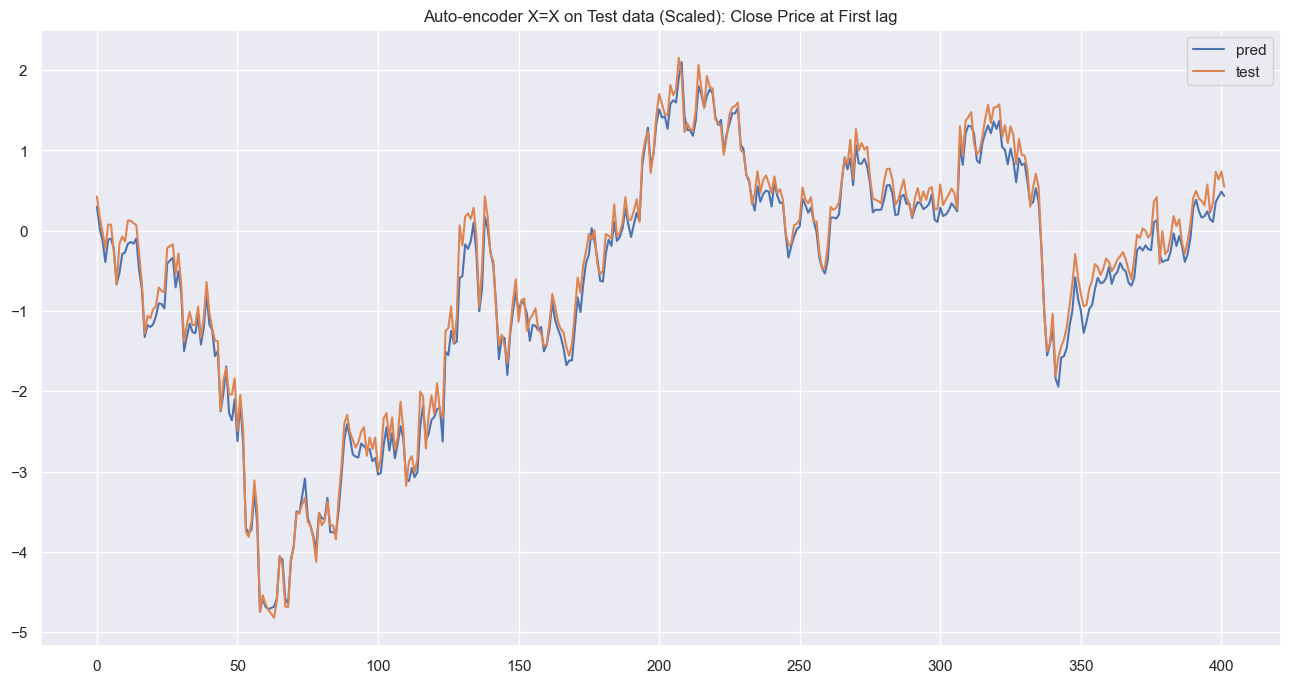

In [111]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [112]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [2220.76 2218.44 2214.99 2208.27 2209.78 2209.56 2203.29 2191.53 2202.91]
X test pred :  [2218.46975308 2215.84128305 2213.07748516 2205.22376119 2206.36860027
 2206.3791707  2203.96950724 2191.56831551 2196.35283953]


[2220.76 2218.44 2214.99 2208.27 2209.78 2209.56 2203.29 2191.53 2202.91
 2201.86 2200.27 2202.59 2205.48 2206.76 2203.93 2202.95 2197.22 2191.51
 2193.32 2193.11 2195.27 2196.64 2201.52 2202.3  2204.96 2207.11 2207.82
 2208.3  2208.5  2209.76 2206.28 2204.31 2208.26 2208.87 2207.42 2206.48
 2206.71 2205.85 2206.65 2209.41 2208.68 2205.4  2202.59 2201.46 2200.19
 2203.19 2197.61 2198.13 2204.53 2205.41 2205.42 2203.4  2203.99 2199.4
 2196.46 2199.58 2200.5  2202.8  2204.86 2205.61 2207.62 2209.67 2209.83
 2207.53 2209.09 2209.26 2209.87 2208.69 2208.53 2211.21 2212.77 2213.43
 2215.85 2215.77 2212.76 2208.8  2208.61 2208.37 2204.13 2206.35 2203.62
 2203.12 2200.71 2203.62 2205.44 2203.1  2208.41 2209.69 2215.33 2213.12
 2213.44 2213.53 2214.21 2214.87 2216.42 2219.45 2211.42 2211.71 2211.84
 2218.64 2215.36 2219.21 2230.2  2230.16 2227.83 2229.48 2228.45 2224.48
 2230.81 2227.03 2221.55 2227.93 2228.13 2228.2  2227.15 2242.   2238.01
 2229.46 2236.22 2242.67 2239.81 2252.15 2241.64 225

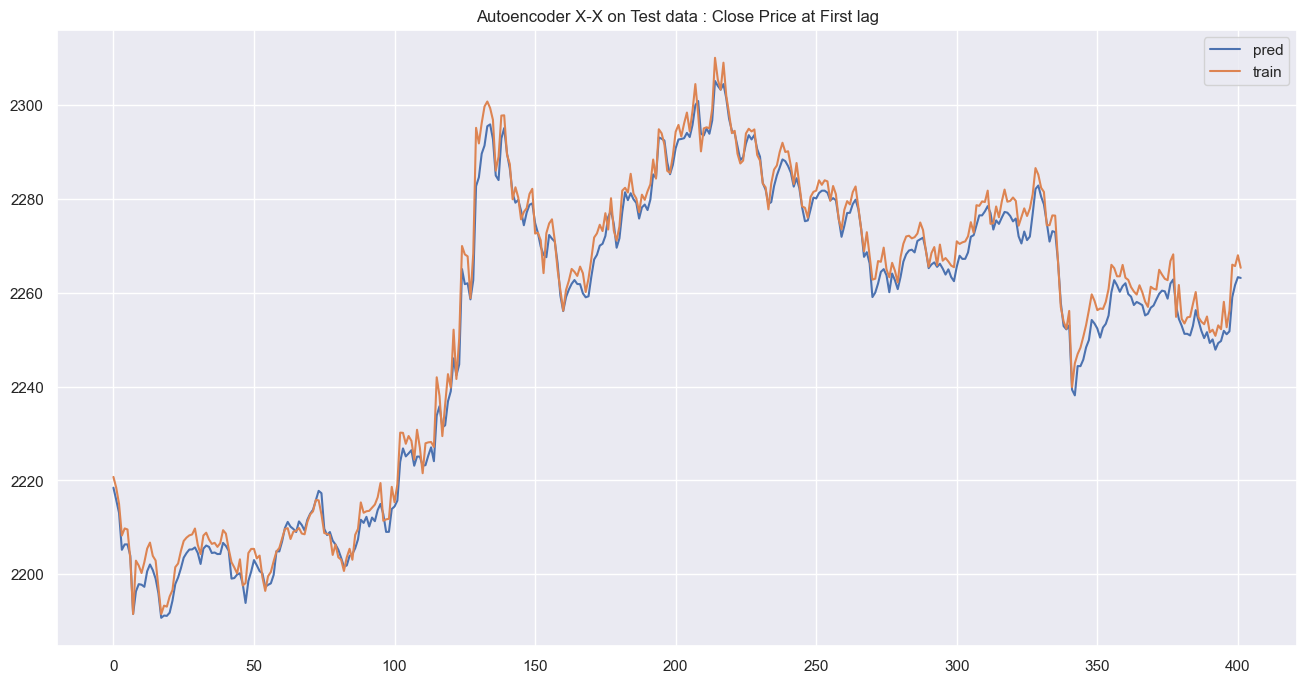

In [113]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [114]:
X_test_sca.shape

(402, 72, 102)

In [115]:
mean_absolute_error(X_test_sca[:,0,:], X_test_sca_pred[:,0,:])

0.17445765902246144

In [116]:
print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mae_ae_test = np.mean(np.abs(X_test_sca_pred - X_test_sca), 0)
print(mae_ae_test.shape)
mae_ae_test_feat = np.mean(mae_ae_test, 0)[np.newaxis,:]
print(mae_ae_test_feat.shape)
df_mae_ae_test = pd.DataFrame(mae_ae_test, columns=list_col_select)
df_mae_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_test.index))]
df_mae_ae_test_feat = pd.DataFrame(mae_ae_test_feat, columns=list_col_select)
df_mae_ae_test["dataset"] = "TEST"
df_mae_ae_train["dataset"] = "TRAIN"
df_mae_ae_comp = pd.concat([df_mae_ae_train, df_mae_ae_test], ignore_index=False)
df_mae_ae_comp

(402, 72, 102)
(402, 72, 102)
(72, 102)
(1, 102)


Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.082180  0.096493  0.066700  0.072312          0.105605   
lag_1    0.062623  0.062436  0.049920  0.057470          0.092679   
lag_2    0.052935  0.052657  0.044079  0.051428          0.088960   
lag_3    0.048934  0.047445  0.041826  0.048828          0.087767   
lag_4    0.045637  0.042536  0.038580  0.046075          0.086538   
...           ...       ...       ...       ...               ...   
lag_67   0.058225  0.058185  0.048202  0.062194          0.102619   
lag_68   0.057791  0.057504  0.047972  0.061963          0.102704   
lag_69   0.057889  0.057056  0.047597  0.061809          0.102661   
lag_70   0.057624  0.057260  0.047090  0.061644          0.102604   
lag_71   0.056812  0.056914  0.047052  0.061518          0.102456   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.089366        0.101897         0.087416   
lag_1           0.071634        0.088342         0.074594   
lag_2           0.065262        0.082142         0.069181   
lag_3           0.061907        0.078641         0.065034   
lag_4           0.059369        0.074763         0.059137   
...                  ...             ...              ...   
lag_67          0.054240        0.080394         0.048252   
lag_68          0.054044        0.080957         0.048717   
lag_69          0.053784        0.081557         0.048724   
lag_70          0.053645        0.082081         0.048429   
lag_71          0.053400        0.082599         0.048107   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
lag_0               0.101263              0.098476  ...  0.079686  0.077654   
lag_1               0.075808              0.071735  ...  0.047077  0.046512   
lag_2               0.065920              0.061474  ...  0.042804  0.042189   
lag_3               0.059576              0.055550  ...  0.044492  0.044331   
lag_4               0.055357              0.051924  ...  0.046095  0.045967   
...                      ...                   ...  ...       ...       ...   
lag_67              0.107313              0.136595  ...  0.059072  0.082238   
lag_68              0.107821              0.136337  ...  0.058886  0.082302   
lag_69              0.108358              0.136048  ...  0.058545  0.082361   
lag_70              0.109007              0.135797  ...  0.058233  0.082489   
lag_71              0.109593              0.135540  ...  0.058023  0.082649   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  \
lag_0      0.079919     0.081674          0.103458          0.098504   
lag_1      0.046213     0.045889          0.056699          0.062954   
lag_2      0.039609     0.039551          0.045391          0.050869   
lag_3      0.037901     0.038477          0.041677          0.046098   
lag_4      0.035560     0.036531          0.039521          0.043561   
...             ...          ...               ...               ...   
lag_67     0.083039     0.123975          0.129828          0.084109   
lag_68     0.083132     0.123735          0.129912          0.084289   
lag_69     0.083261     0.123590          0.129971          0.084473   
lag_70     0.083287     0.123423          0.129973          0.084627   
lag_71     0.083195     0.123243          0.130036          0.084689   

         day_off  event_pred  event_real  dataset  
lag_0   0.071246    0.127846    0.118075    TRAIN  
lag_1   0.034011    0.078527    0.051203    TRAIN  
lag_2   0.022542    0.048081    0.034919    TRAIN  
lag_3   0.017775    0.034075    0.025856    TRAIN  
lag_4   0.015723    0.029202    0.023873    TRAIN  
...          ...         ...         ...      ...  
lag_67  0.024714    0.033518    0.052165     TEST  
lag_68  0.024678    0.033632    0.052270     TEST  
lag_69  0.024705    0.033604    0.052264     TEST  
lag_70  0.024735    0.033682    0.052178     TEST  
lag_71  0.024724    0.033834    0.052179     TEST  

[144 ro

In [117]:
df_mae_ae_test_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.064307  0.062359  0.051432  0.063731          0.114474   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0           0.06221        0.082927         0.054988              0.109771   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.123309  ...    0.015258  0.062799    0.0778     0.079138   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0     0.131834          0.115547          0.100738  0.026897    0.033175   

   event_real  
0    0.057969  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature on TEST')

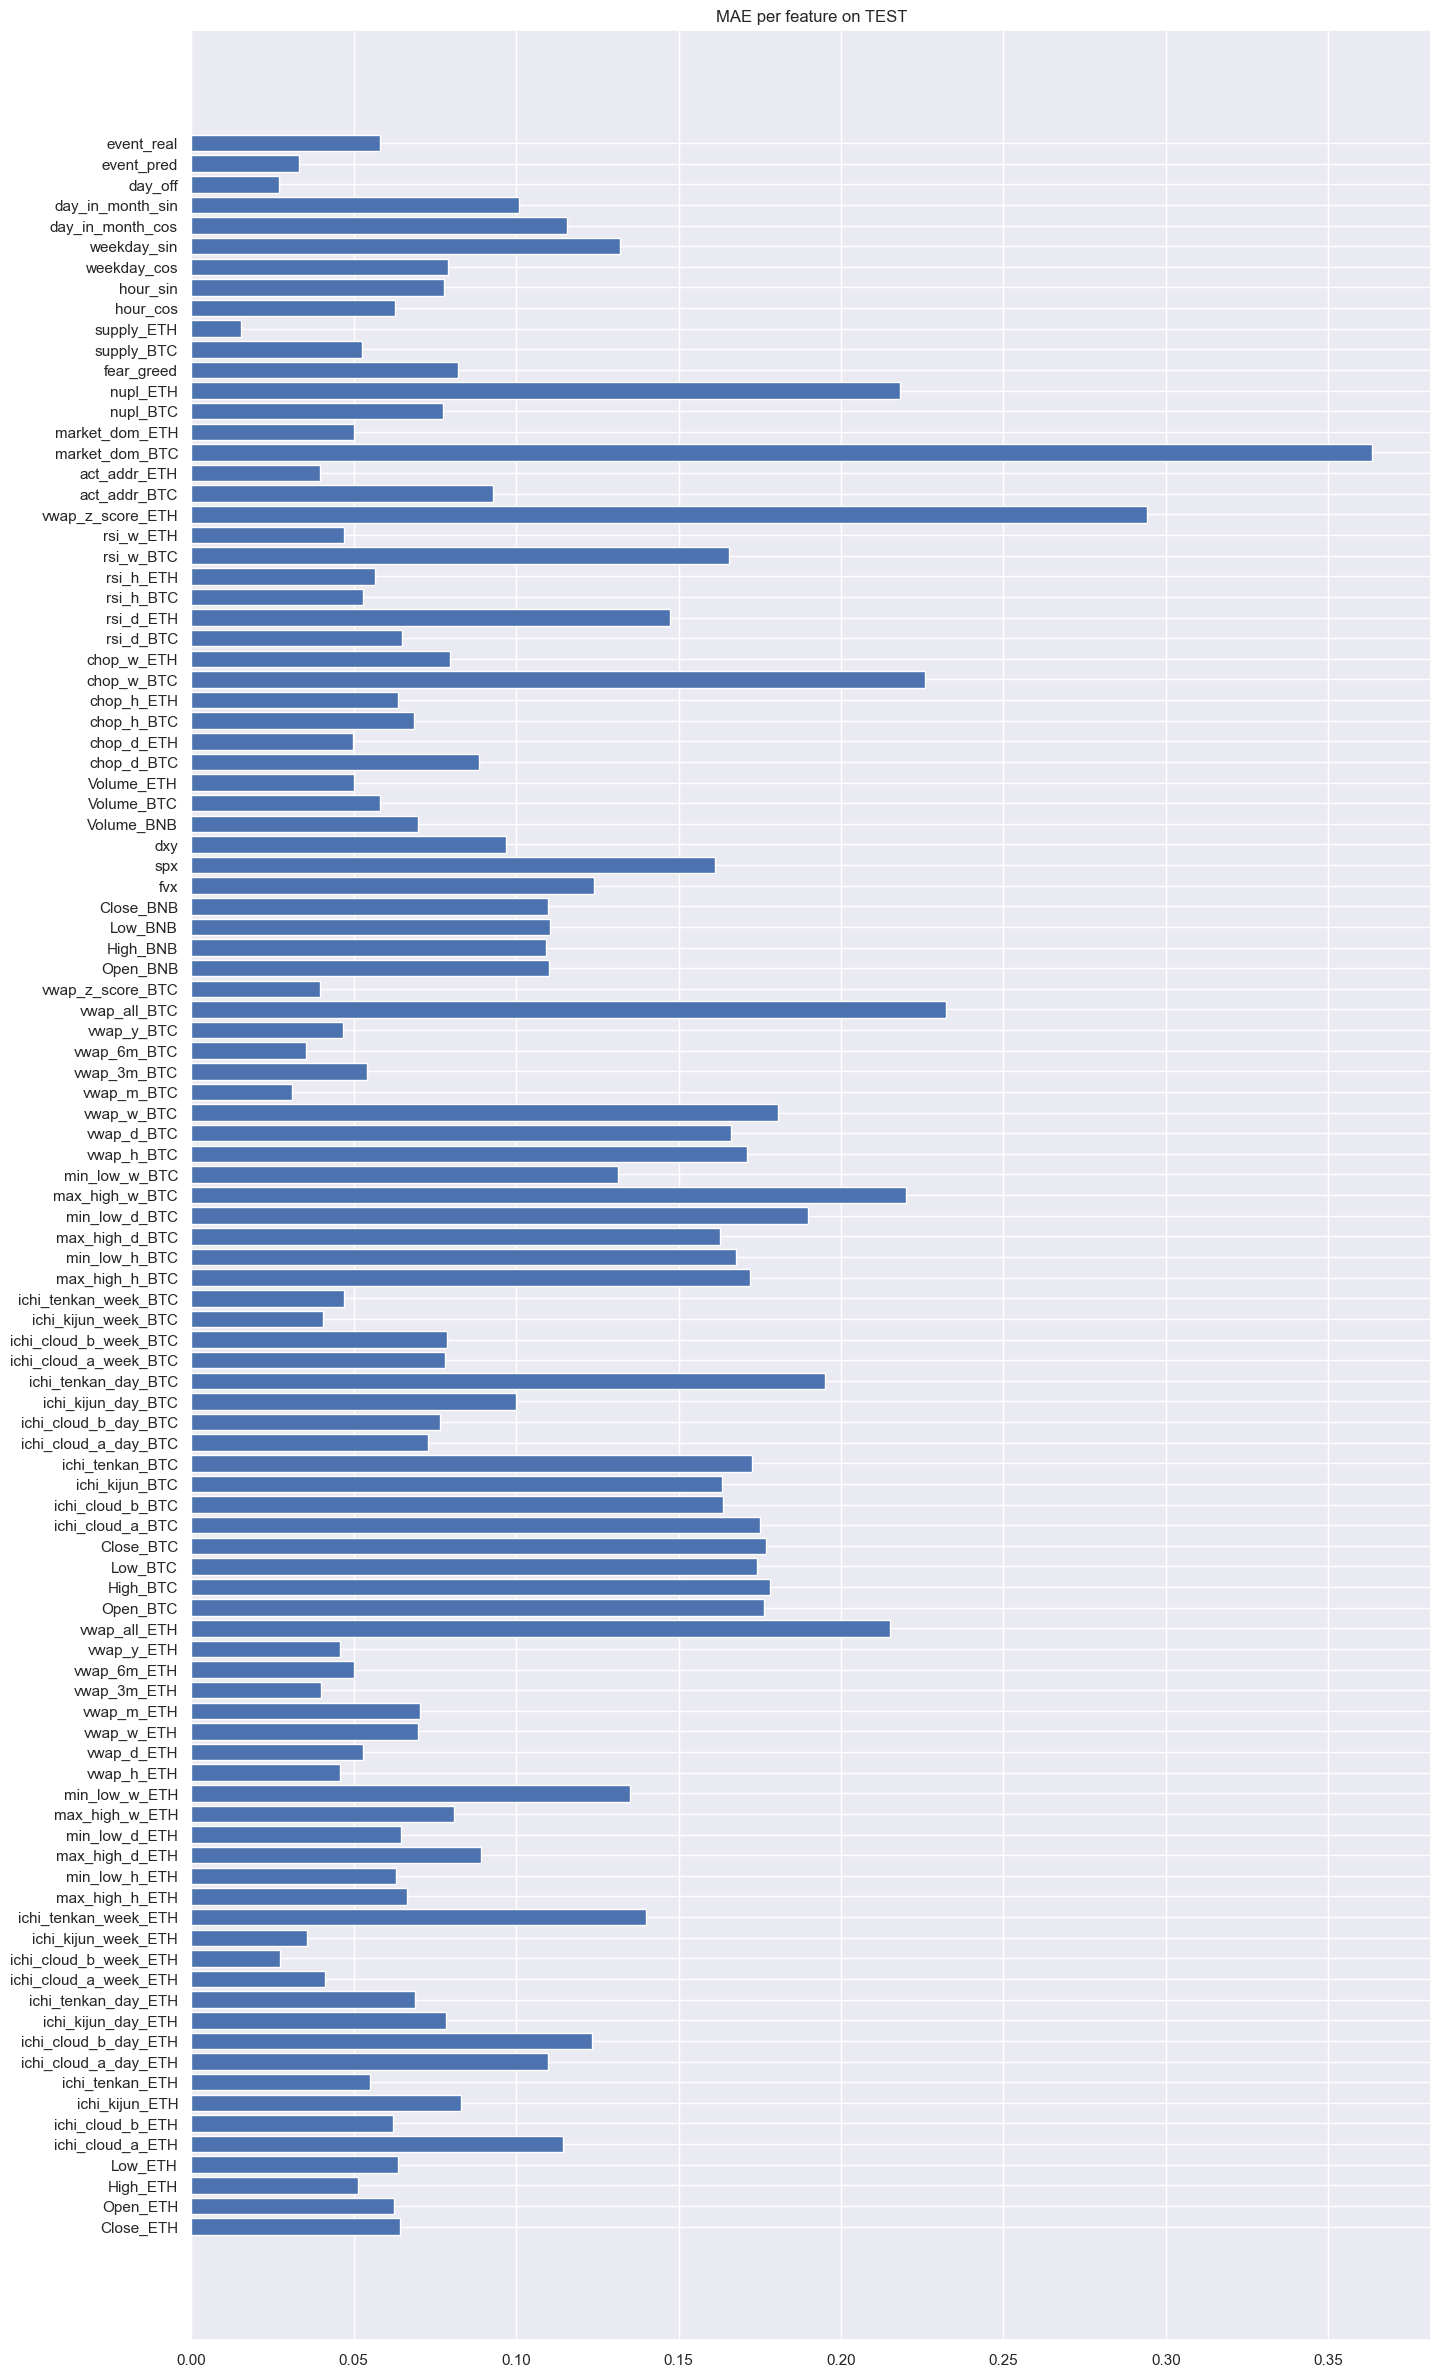

In [118]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_test_feat.columns, df_mae_ae_test_feat.values[0])
plt.title("MAE per feature on TEST")

In [119]:
df_mae_ae_test_feat.values[0]

array([0.06430687, 0.06235902, 0.05143231, 0.0637307 , 0.11447352,
       0.06220961, 0.082927  , 0.05498776, 0.10977061, 0.12330908,
       0.0783263 , 0.06879139, 0.04110537, 0.02742545, 0.03551542,
       0.14010118, 0.06636218, 0.06299599, 0.08929896, 0.06465543,
       0.08078202, 0.13518454, 0.04566241, 0.05280982, 0.06963439,
       0.07054164, 0.03995759, 0.05012029, 0.04563123, 0.21496957,
       0.17632431, 0.1782255 , 0.1740226 , 0.17691171, 0.17520709,
       0.16355723, 0.16332584, 0.17274336, 0.07298123, 0.0766384 ,
       0.0998087 , 0.19499374, 0.07813091, 0.07881657, 0.0404202 ,
       0.04705456, 0.17212223, 0.16770529, 0.16273762, 0.18981398,
       0.220124  , 0.13119392, 0.17107956, 0.16600249, 0.18046316,
       0.03112533, 0.05410114, 0.03531951, 0.04659342, 0.23223221,
       0.03952993, 0.10996111, 0.10912638, 0.11040445, 0.10964825,
       0.12387657, 0.1611931 , 0.09688541, 0.06969385, 0.05816791,
       0.05008571, 0.08865456, 0.04977086, 0.06860918, 0.06376

In [120]:
2/df_mae_ae_test_feat.values[0].sum()

0.19194845092746862

In [121]:
df_comp = df_mae_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MAE")
df_comp

dataset    variable       MAE
0       TRAIN   Close_ETH  0.082180
1       TRAIN   Close_ETH  0.062623
2       TRAIN   Close_ETH  0.052935
3       TRAIN   Close_ETH  0.048934
4       TRAIN   Close_ETH  0.045637
...       ...         ...       ...
14683    TEST  event_real  0.052165
14684    TEST  event_real  0.052270
14685    TEST  event_real  0.052264
14686    TEST  event_real  0.052178
14687    TEST  event_real  0.052179

[14688 rows x 3 columns]

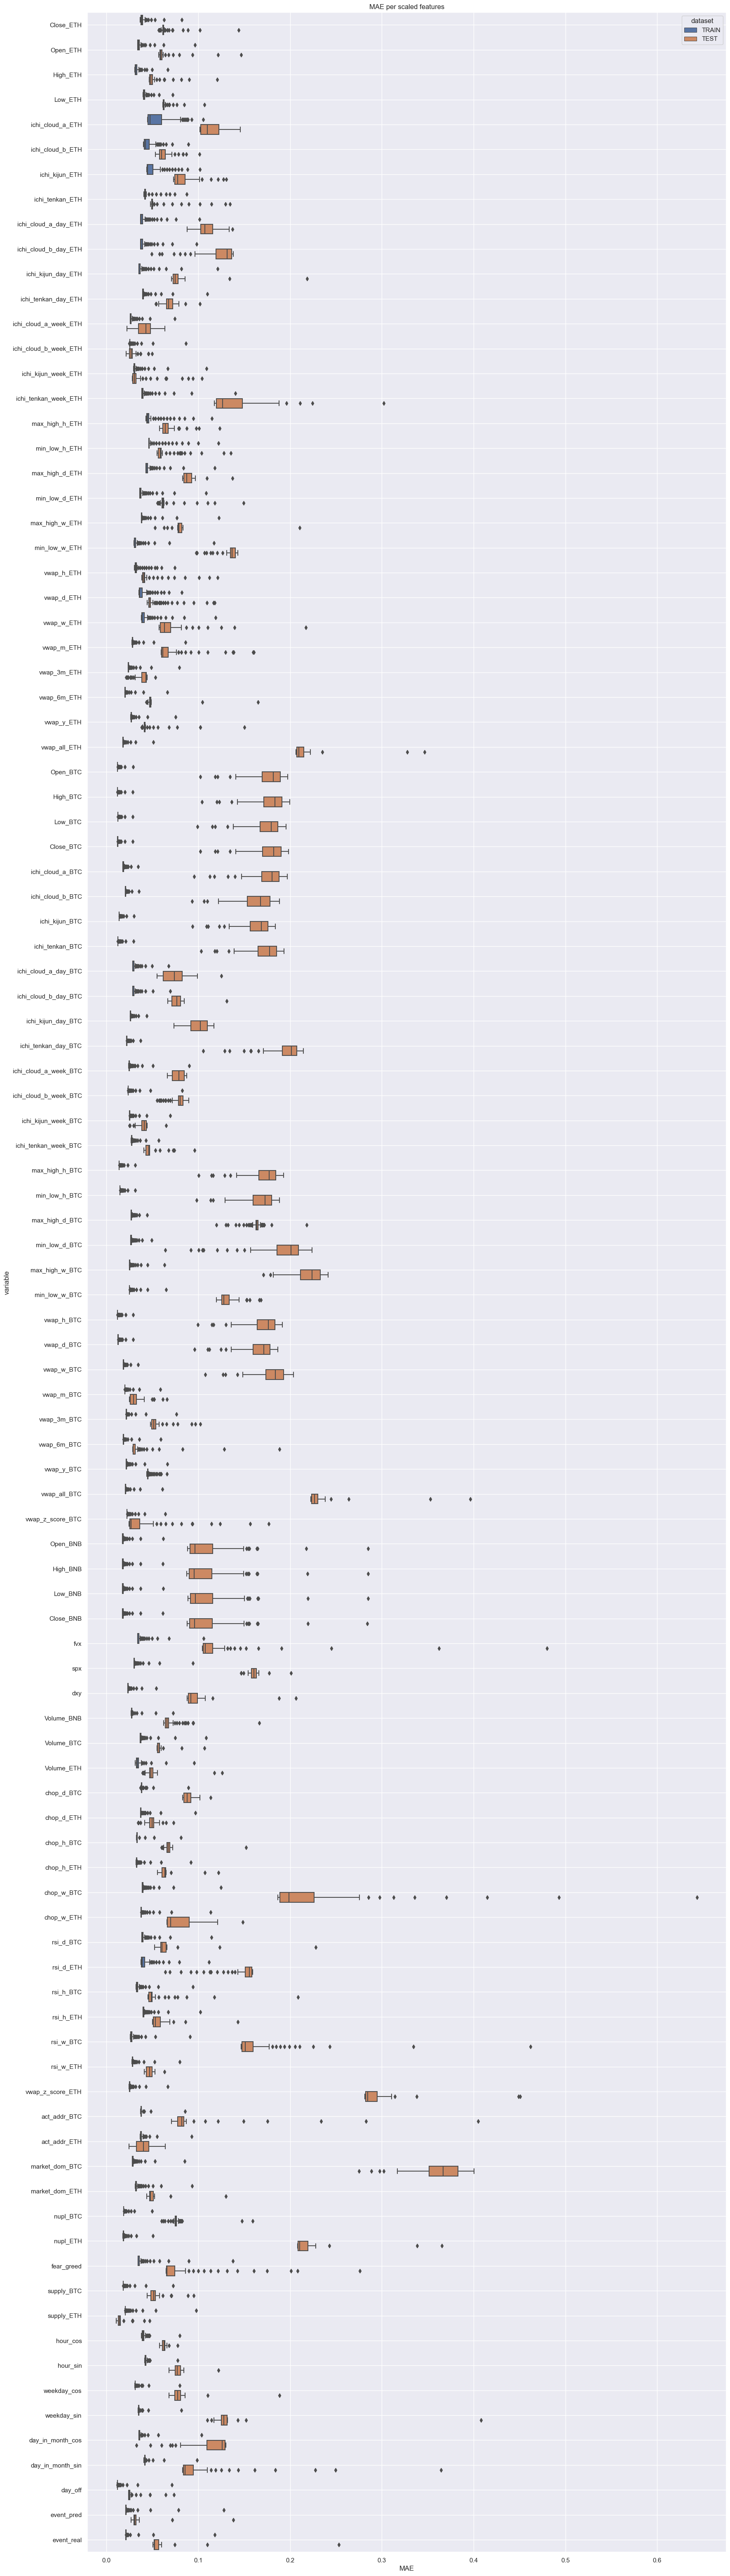

In [122]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="MAE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MAE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MAE - {name_plt}.jpg")
)

#### MSE  per features

In [123]:
# values per feat.
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)
mse_ae_train = np.mean(np.square(X_train_sca_pred - X_train_sca), 0)
print(mse_ae_train.shape)
df_mse_ae_train = pd.DataFrame(mse_ae_train, columns=list_col_select)
df_mse_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_train.index))]

print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mse_ae_test = np.mean(np.square(X_test_sca_pred - X_test_sca), 0)
print(mse_ae_test.shape)
df_mse_ae_test = pd.DataFrame(mse_ae_test, columns=list_col_select)
df_mse_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_test.index))]

# mean per feat.
mse_ae_train_feat = np.mean(mse_ae_train, 0)[np.newaxis,:]
print(mse_ae_train_feat.shape)
df_mse_ae_train_feat = pd.DataFrame(mse_ae_train_feat, columns=list_col_select)

mse_ae_test_feat = np.mean(mse_ae_test, 0)[np.newaxis,:]
print(mse_ae_test_feat.shape)
df_mse_ae_test_feat = pd.DataFrame(mse_ae_test_feat, columns=list_col_select)

# comp train/test
df_mse_ae_test["dataset"] = "TEST"
df_mse_ae_train["dataset"] = "TRAIN"
df_mse_ae_comp = pd.concat([df_mse_ae_train, df_mse_ae_test], ignore_index=False)

df_mse_ae_test_feat["dataset"] = "TEST"
df_mse_ae_train_feat["dataset"] = "TRAIN"
df_mse_ae_comp_feat = pd.concat([df_mse_ae_train_feat, df_mse_ae_test_feat], ignore_index=False)

df_mse_ae_comp = df_mse_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MSE")



(97342, 72, 102)
(97342, 72, 102)
(72, 102)
(402, 72, 102)
(402, 72, 102)
(72, 102)
(1, 102)
(1, 102)


In [124]:
df_mse_ae_comp_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.003380  0.003048  0.002703  0.003989          0.006275   
0   0.006546  0.006388  0.004408  0.006679          0.018651   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.004263        0.005615         0.004617              0.003005   
0          0.006134        0.011242         0.005128              0.015345   

   ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  weekday_cos  weekday_sin  \
0              0.002994  ...  0.002812  0.003018     0.002155     0.002471   
0              0.019743  ...  0.006254  0.008975     0.009669     0.020577   

   day_in_month_cos  day_in_month_sin   day_off  event_pred  event_real  \
0          0.002481          0.003043  0.001449    0.001962    0.001752   
0          0.019966          0.014814  0.001224    0.001936    0.006606   

   dataset  
0    TRAIN  
0     TEST  

[2 rows x 103 columns]

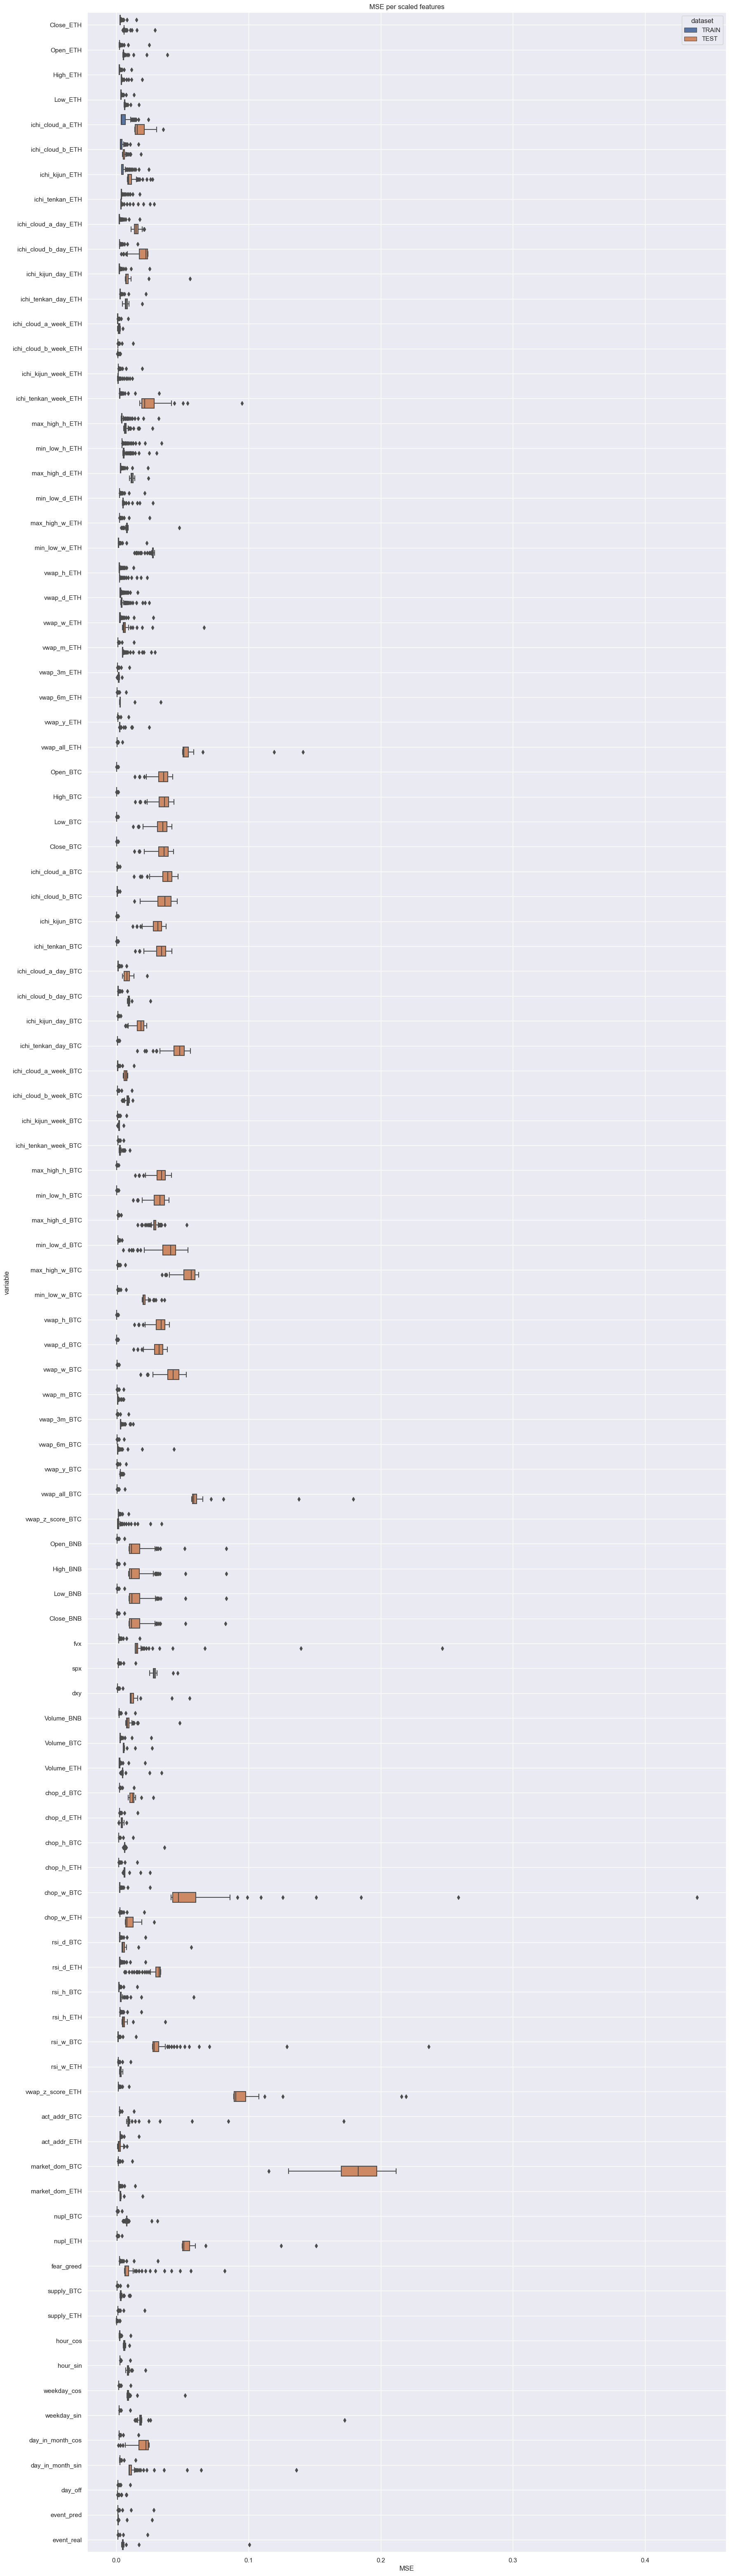

In [125]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_mse_ae_comp, x="MSE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MSE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MSE - {name_plt}.jpg")
)

Text(0.5, 1.0, 'MSE per feature on TRAIN')

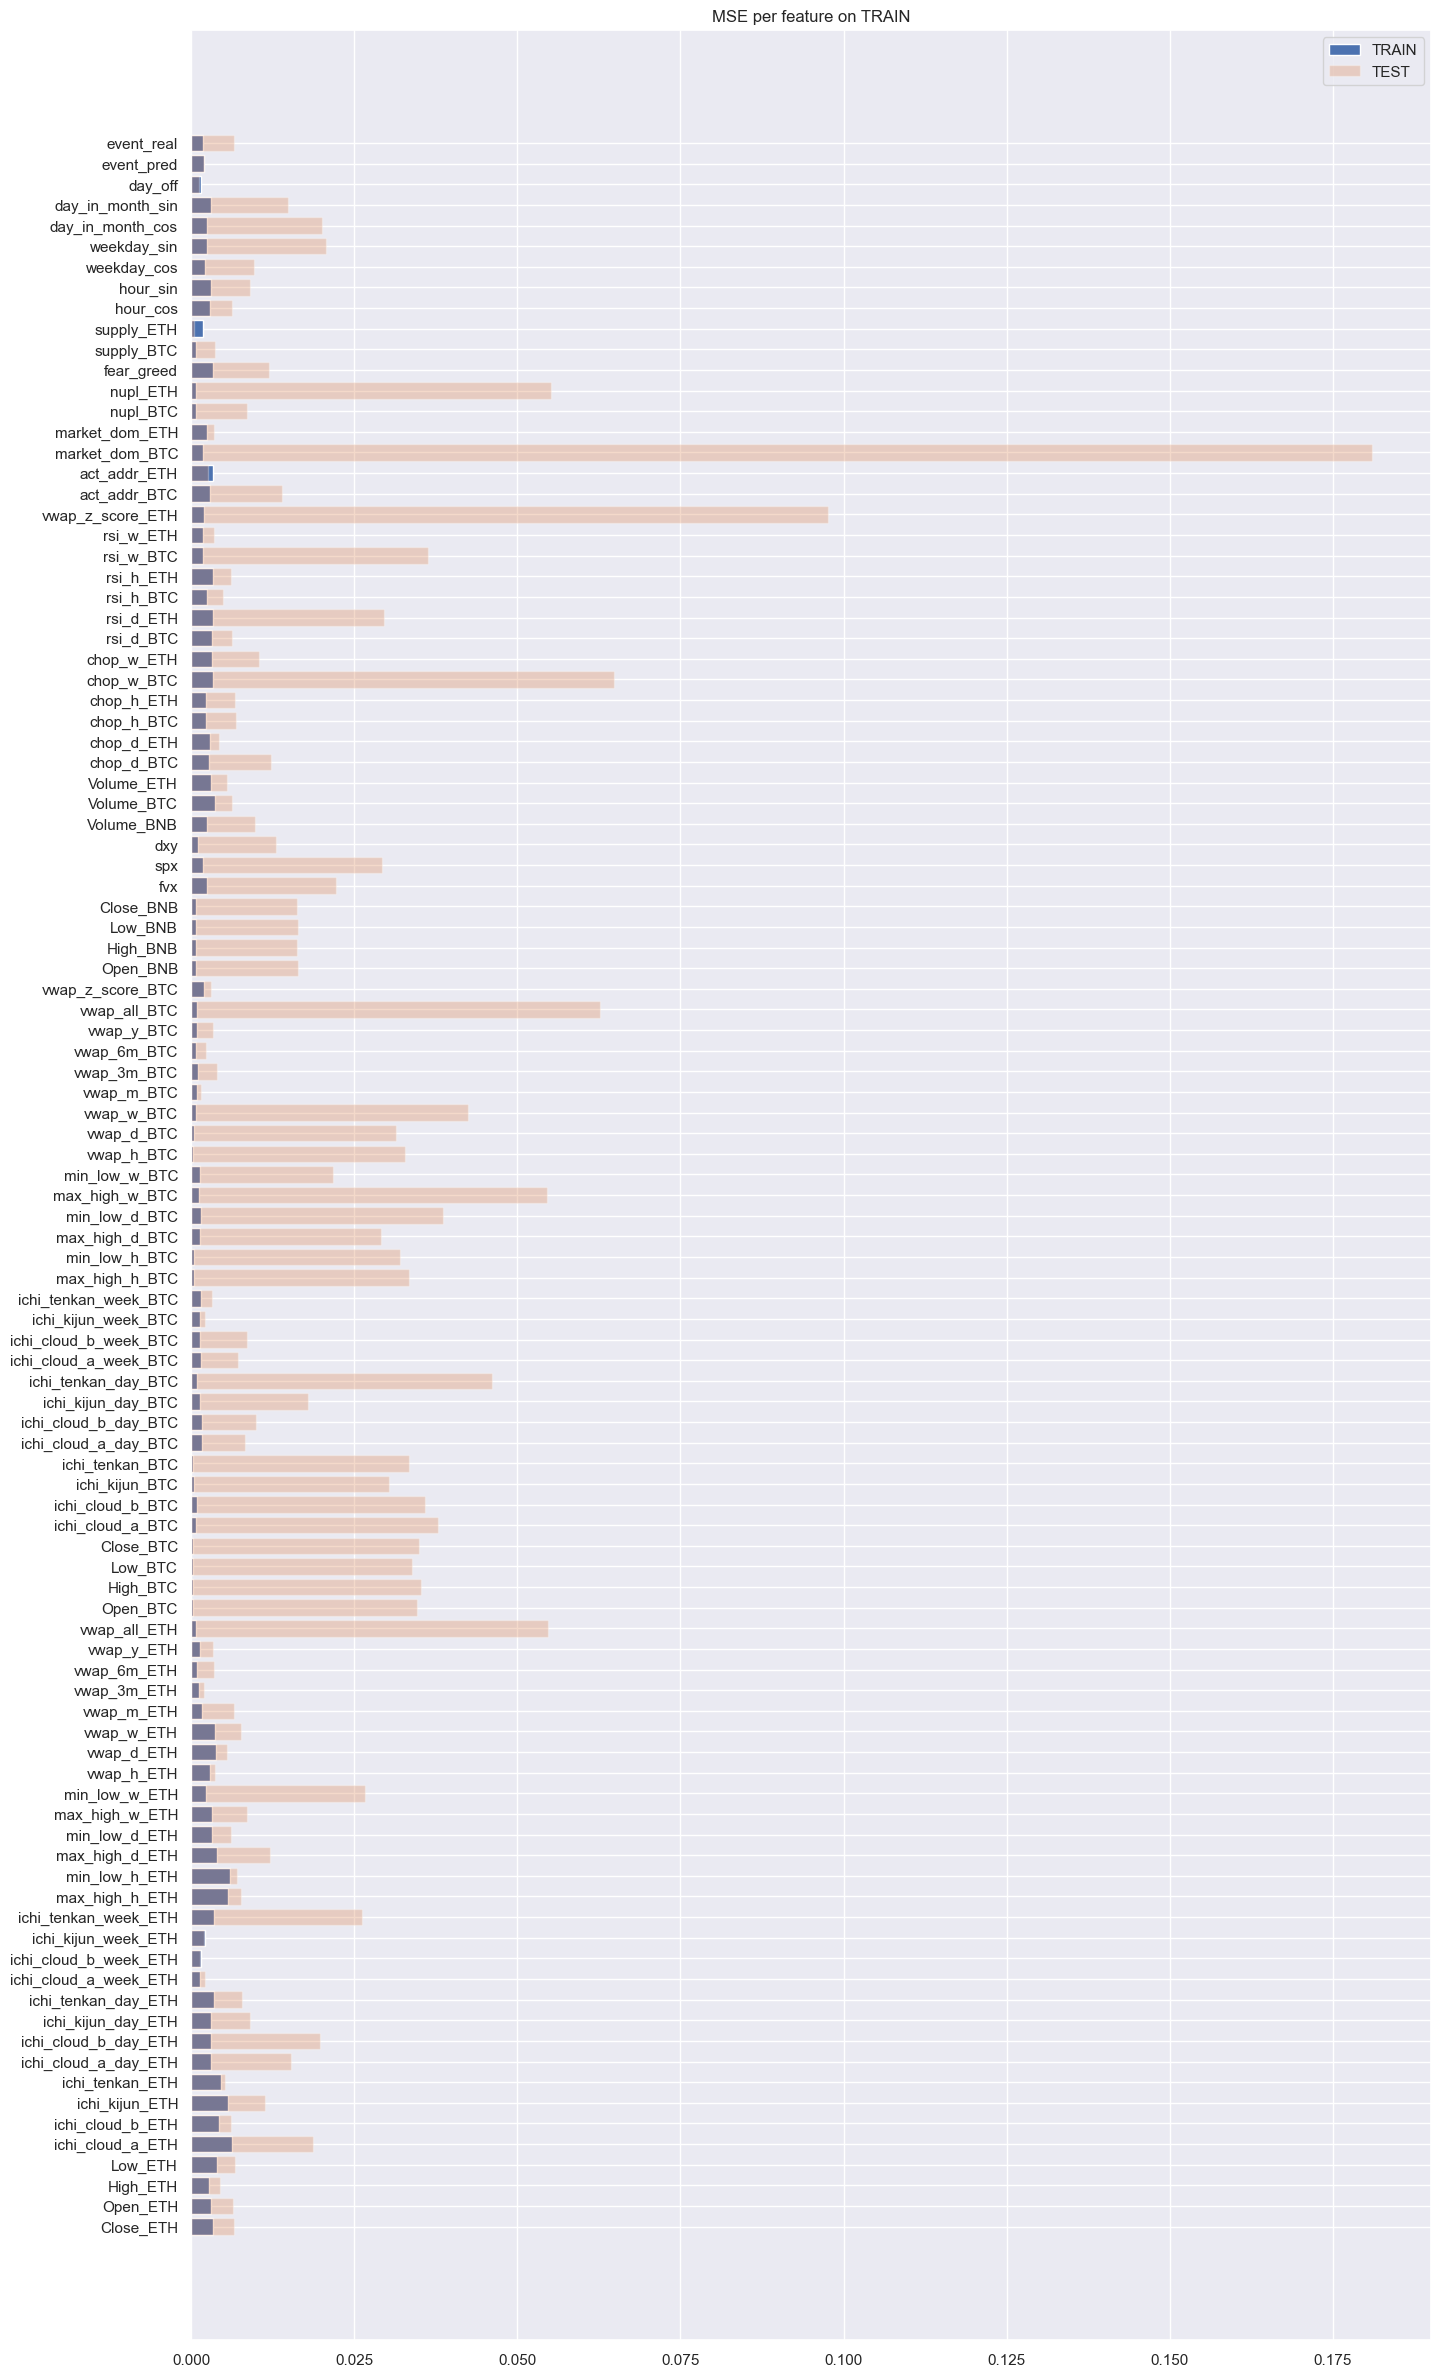

In [126]:
plt.figure(figsize=(16, 30))
plt.barh(list_col_select, df_mse_ae_train_feat.values[0,:-1], label="TRAIN")
plt.barh(list_col_select, df_mse_ae_test_feat.values[0,:-1], label="TEST", alpha=0.3)
plt.legend(loc='upper right')
#plt.barh(df_mse_ae_test_feat.columns, df_mse_ae_test_feat.values[0])
plt.title("MSE per feature on TRAIN")

In [127]:
encoder_model.layers[3].get_weights()

[array([[ 0.00053234, -0.04353296, -0.02628182, ..., -0.00514806,
          0.00351642,  0.10003421],
        [-0.06403609, -0.02413547, -0.2192831 , ...,  0.11087847,
         -0.06741723, -0.03343868],
        [ 0.26542607, -0.02118787,  0.03321024, ...,  0.11800081,
         -0.13254148, -0.10108465],
        ...,
        [ 0.00960744,  0.21695207, -0.02417747, ..., -0.12270685,
          0.04812601,  0.114755  ],
        [ 0.22492383,  0.1308405 ,  0.15608422, ..., -0.17821448,
         -0.08990412,  0.00337272],
        [ 0.13943595,  0.16769047, -0.27300924, ..., -0.060806  ,
         -0.0719245 ,  0.3342821 ]], dtype=float32),
 array([-0.04776729, -0.0844863 , -0.02471129, -0.0995928 ,  0.1101679 ,
         0.01371977, -0.12015314, -0.00378196,  0.15378638,  0.24564129,
         0.35727668, -0.00841207, -0.0277287 ,  0.03105268, -0.08998014,
         0.01840191,  0.05703553,  0.00167904,  0.08424944, -0.05864909,
        -0.08825567,  0.05401867, -0.05435894, -0.09784779, -0.088

## Prediction Models

### LSTM all features

In [128]:
X_train_sca.shape

(97342, 72, 102)

In [129]:
X_train_sca.shape[-1]

102

In [130]:
X_train_sca.shape[-2:]

(72, 102)

In [131]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
if MODE_TRAIN_LSTM:
    EPOCHS = 5
    PATIENCE_PRED = 0
    dropout_rate = 0.05
    n_units = 128
    seed = 0
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    optim = tf.optimizers.Adam()

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    verbose=1, patience=PATIENCE_PRED,
                                    restore_best_weights=True)
    # create model
    multi_step_model_1 = tf.keras.models.Sequential()
    multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                        return_sequences=False,
                        input_shape=X_train_sca.shape[-2:],
                        dropout=dropout_rate))
    multi_step_model_1.add(tf.keras.layers.LayerNormalization())
    multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model_1.compile(optimizer=optim, loss='mse')
    # fitting
    if PATIENCE_PRED == 0:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1
        )
    else:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])

    # eval
    mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
    print("mse_curr_1 = ", mse_curr_1)
    # plot mse
    plot_train_history(multi_step_history_1,
                        'Multi Step Training and validation loss', "data")
    # save mdl
    multi_step_model_1.save(path_mdl_predict_lstm)
    # results
    # _train_sca -> unscaler -> _train -> multiply by  Close price last lag
    y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
    y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
    y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

    y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
    y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
    y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TRAIN data : Close Price at 6th lag")
    plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_train_raw[:1000, 5], label="TRAIN")
    plt.legend(loc='upper right')
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TEST data : Close Price at 6th lag")
    plt.plot(y_test_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_test_raw[:1000, 5], label="TEST")
    plt.legend(loc='upper right')


### Autoencoder + LSTM reduced features

In [132]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

Concatenate 

In [133]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

3042/3042 [==============================] - 35s 11ms/step


(97342, 72, 32)

In [134]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

 1/13 [=>............................] - ETA: 0s

13/13 [==============================] - 0s 18ms/step


(402, 72, 32)

In [135]:
if MODE_TRAIN_AE:
    scaler_enc = StandardScaler()
    X_train_encoded_sca = scaler_enc.fit_transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)

    joblib.dump(scaler_enc, path_scaler_enc)
    
else:
    print("reloading scaler_enc...")
    scaler_enc = joblib.load(path_scaler_enc)
    X_train_encoded_sca = scaler_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)    



reloading scaler_enc...


In [136]:
"""path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
joblib.dump(scaler_enc, path_scaler_enc)
sc_enc = joblib.load(path_scaler_enc)
sc_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)"""

'path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")\njoblib.dump(scaler_enc, path_scaler_enc)\nsc_enc = joblib.load(path_scaler_enc)\nsc_enc.transform(\n        X_train_encoded.reshape(\n            -1, \n            X_train_encoded.shape[-1]\n        )\n    ).reshape(X_train_encoded.shape)'

In [137]:
"""# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)"""

'# scale encoded data\nscaler_enc = StandardScaler()\nX_train_encoded_sca = scaler_enc.fit_transform(\n    X_train_encoded.reshape(\n        -1, \n        X_train_encoded.shape[-1]\n    )\n).reshape(X_train_encoded.shape)\n\nX_test_encoded_sca = scaler_enc.transform(\n    X_test_encoded.reshape(\n        -1, \n        X_test_encoded.shape[-1]\n    )\n).reshape(X_test_encoded.shape)'

In [138]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((97342, 72, 36), (402, 72, 36))

#### Correlations

In [139]:
list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

list_corr = []
for i_lag in range(X_train_.shape[1]):

    df = pd.DataFrame(np.hstack((X_train_[:,i_lag,:], y_train)), 
        columns=list_col_corr)
    # Calculer la matrice de corrélation
    corr_matrix = df.corr()
    if len(list_corr) > 0:
        corr_matrix_min = list_corr[-1].combine(corr_matrix, np.minimum)
        corr_matrix_max = list_corr[-1].combine(corr_matrix, np.maximum)
    
    list_corr.append(corr_matrix)



KeyboardInterrupt: 

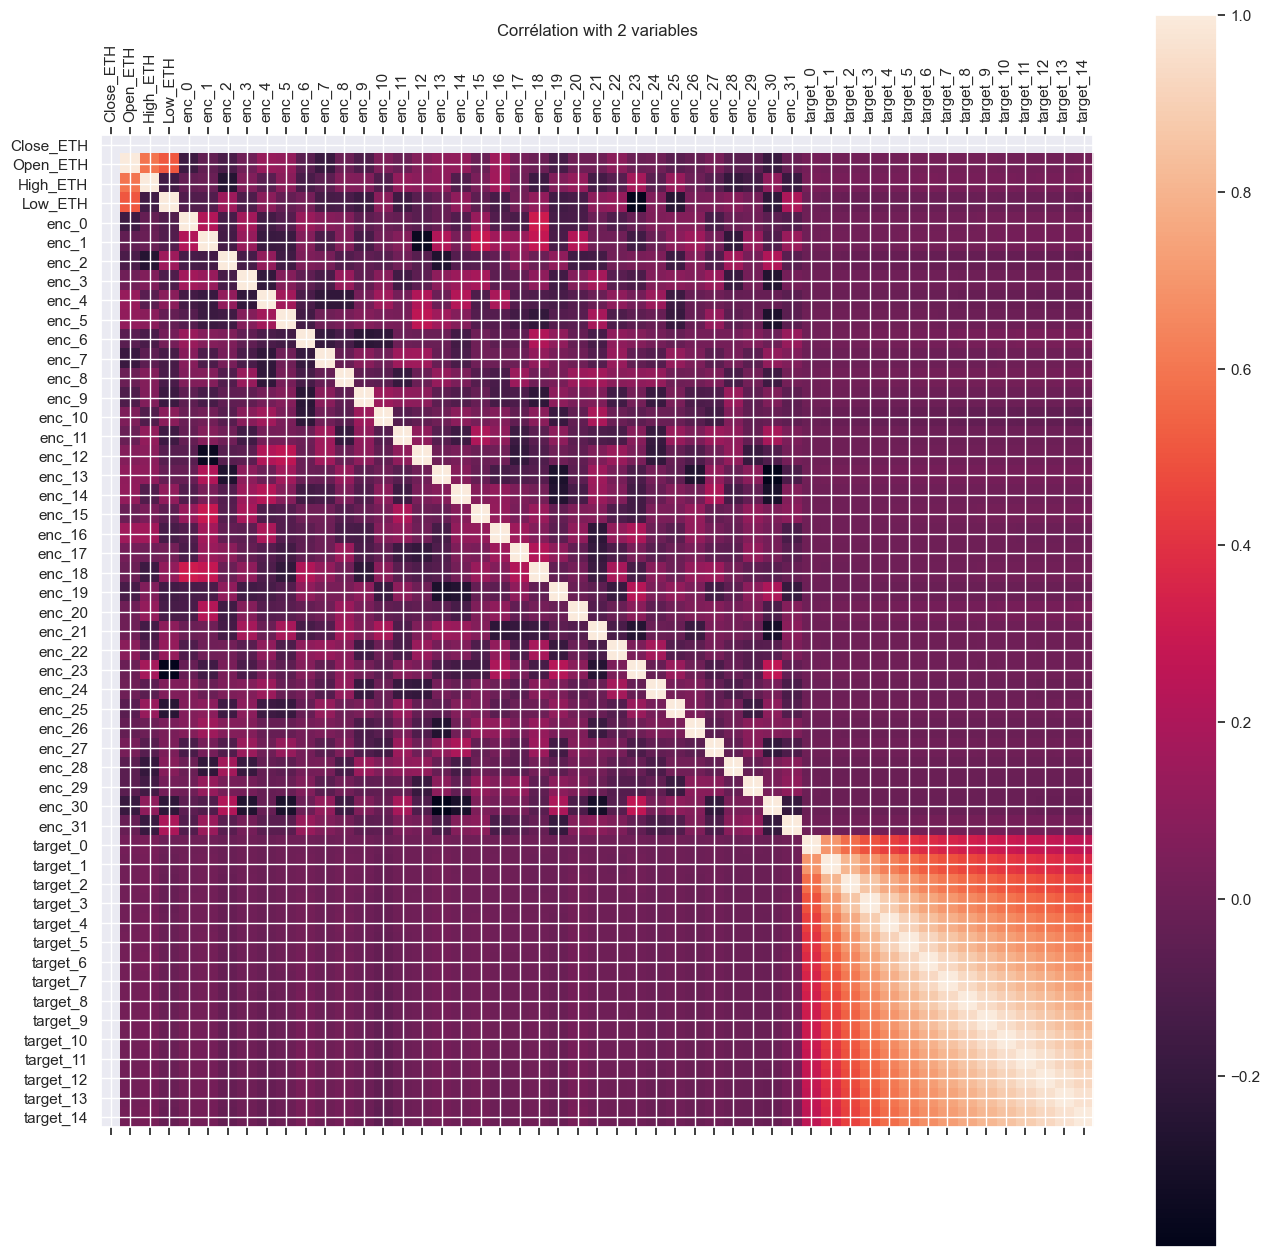

In [ ]:
fig = plot_corr(corr_matrix_min)

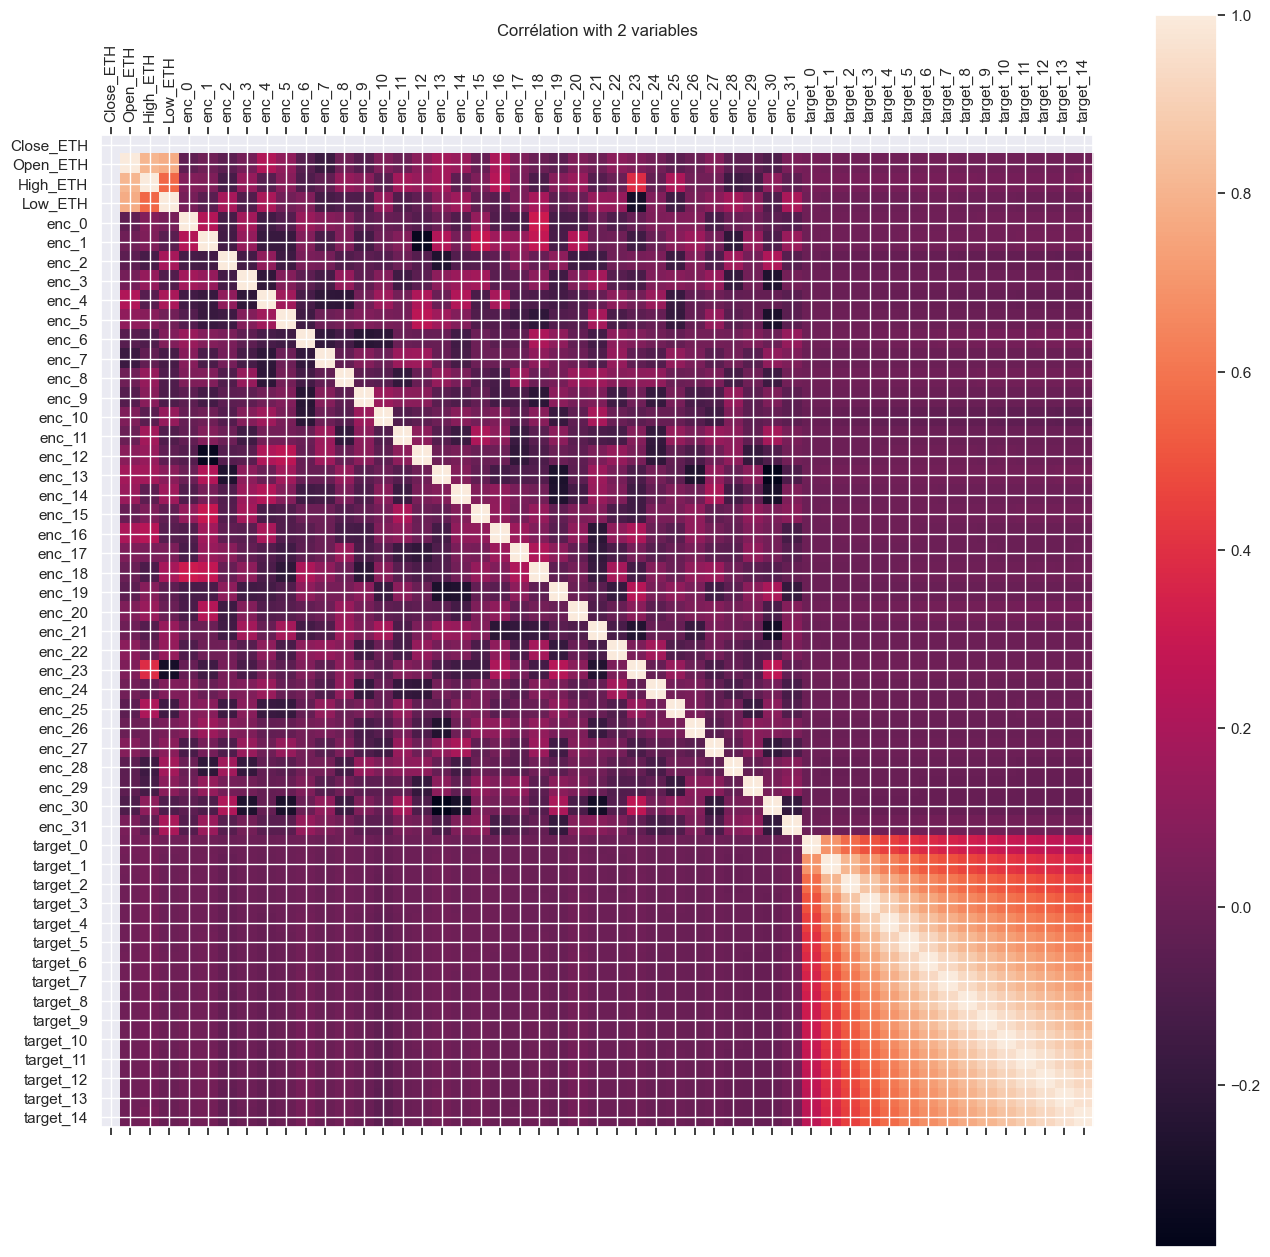

In [ ]:
fig = plot_corr(corr_matrix_max) 

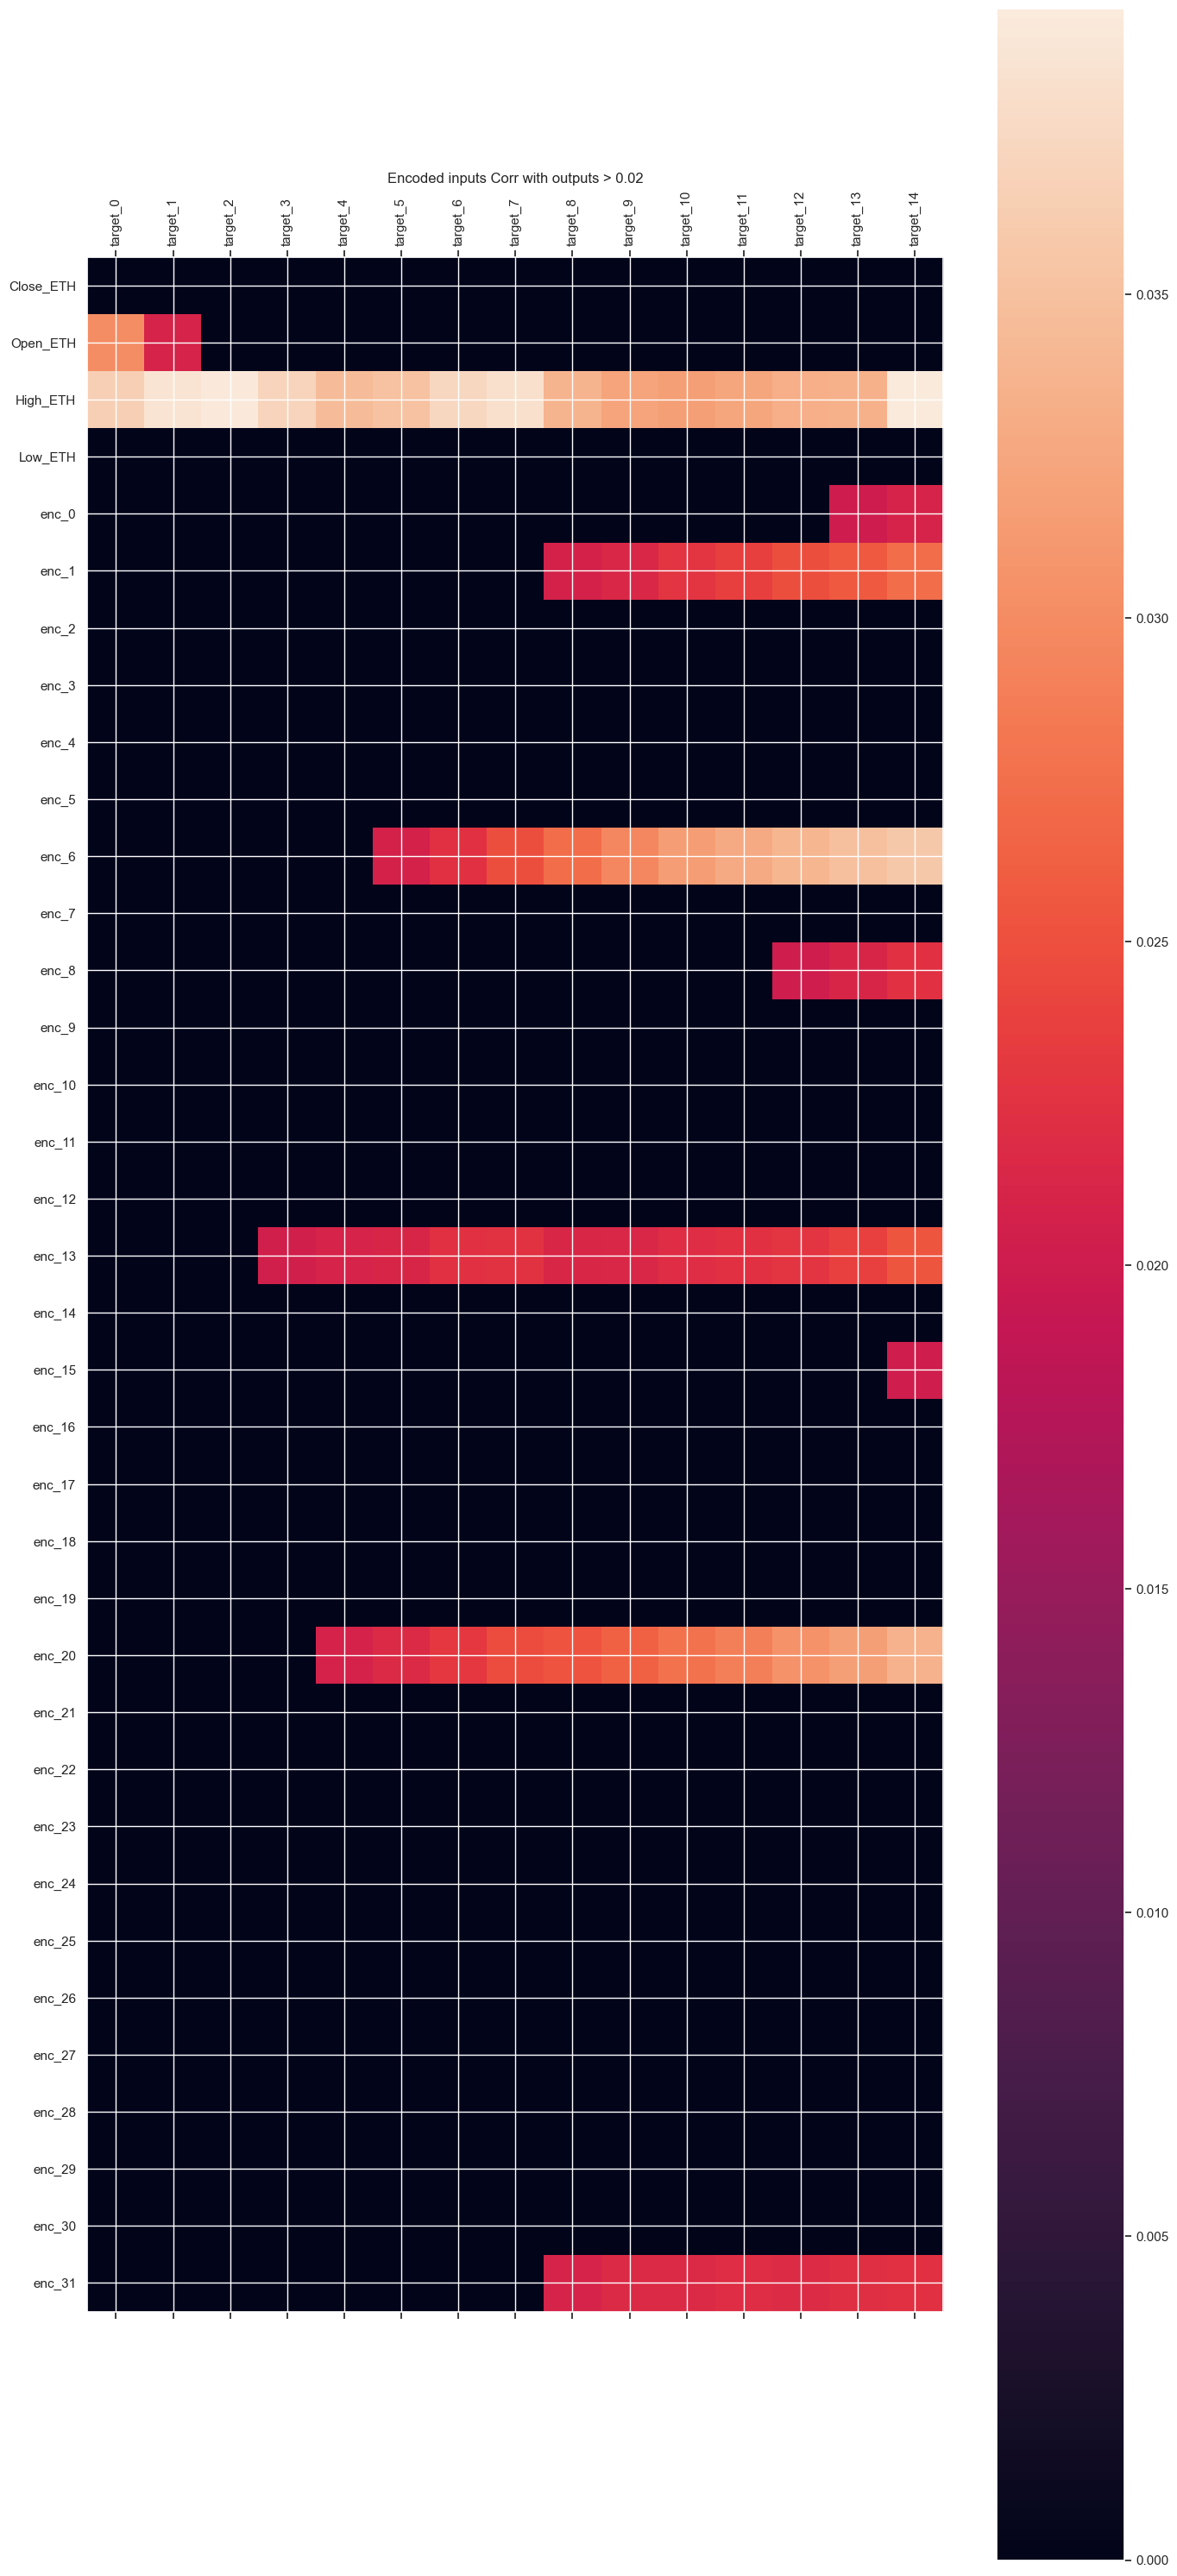

In [ ]:
corr_matrix_targets_max = corr_matrix_max.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_max.where(corr_matrix_targets_max>0.02, 0), "Encoded inputs Corr with outputs > 0.02")

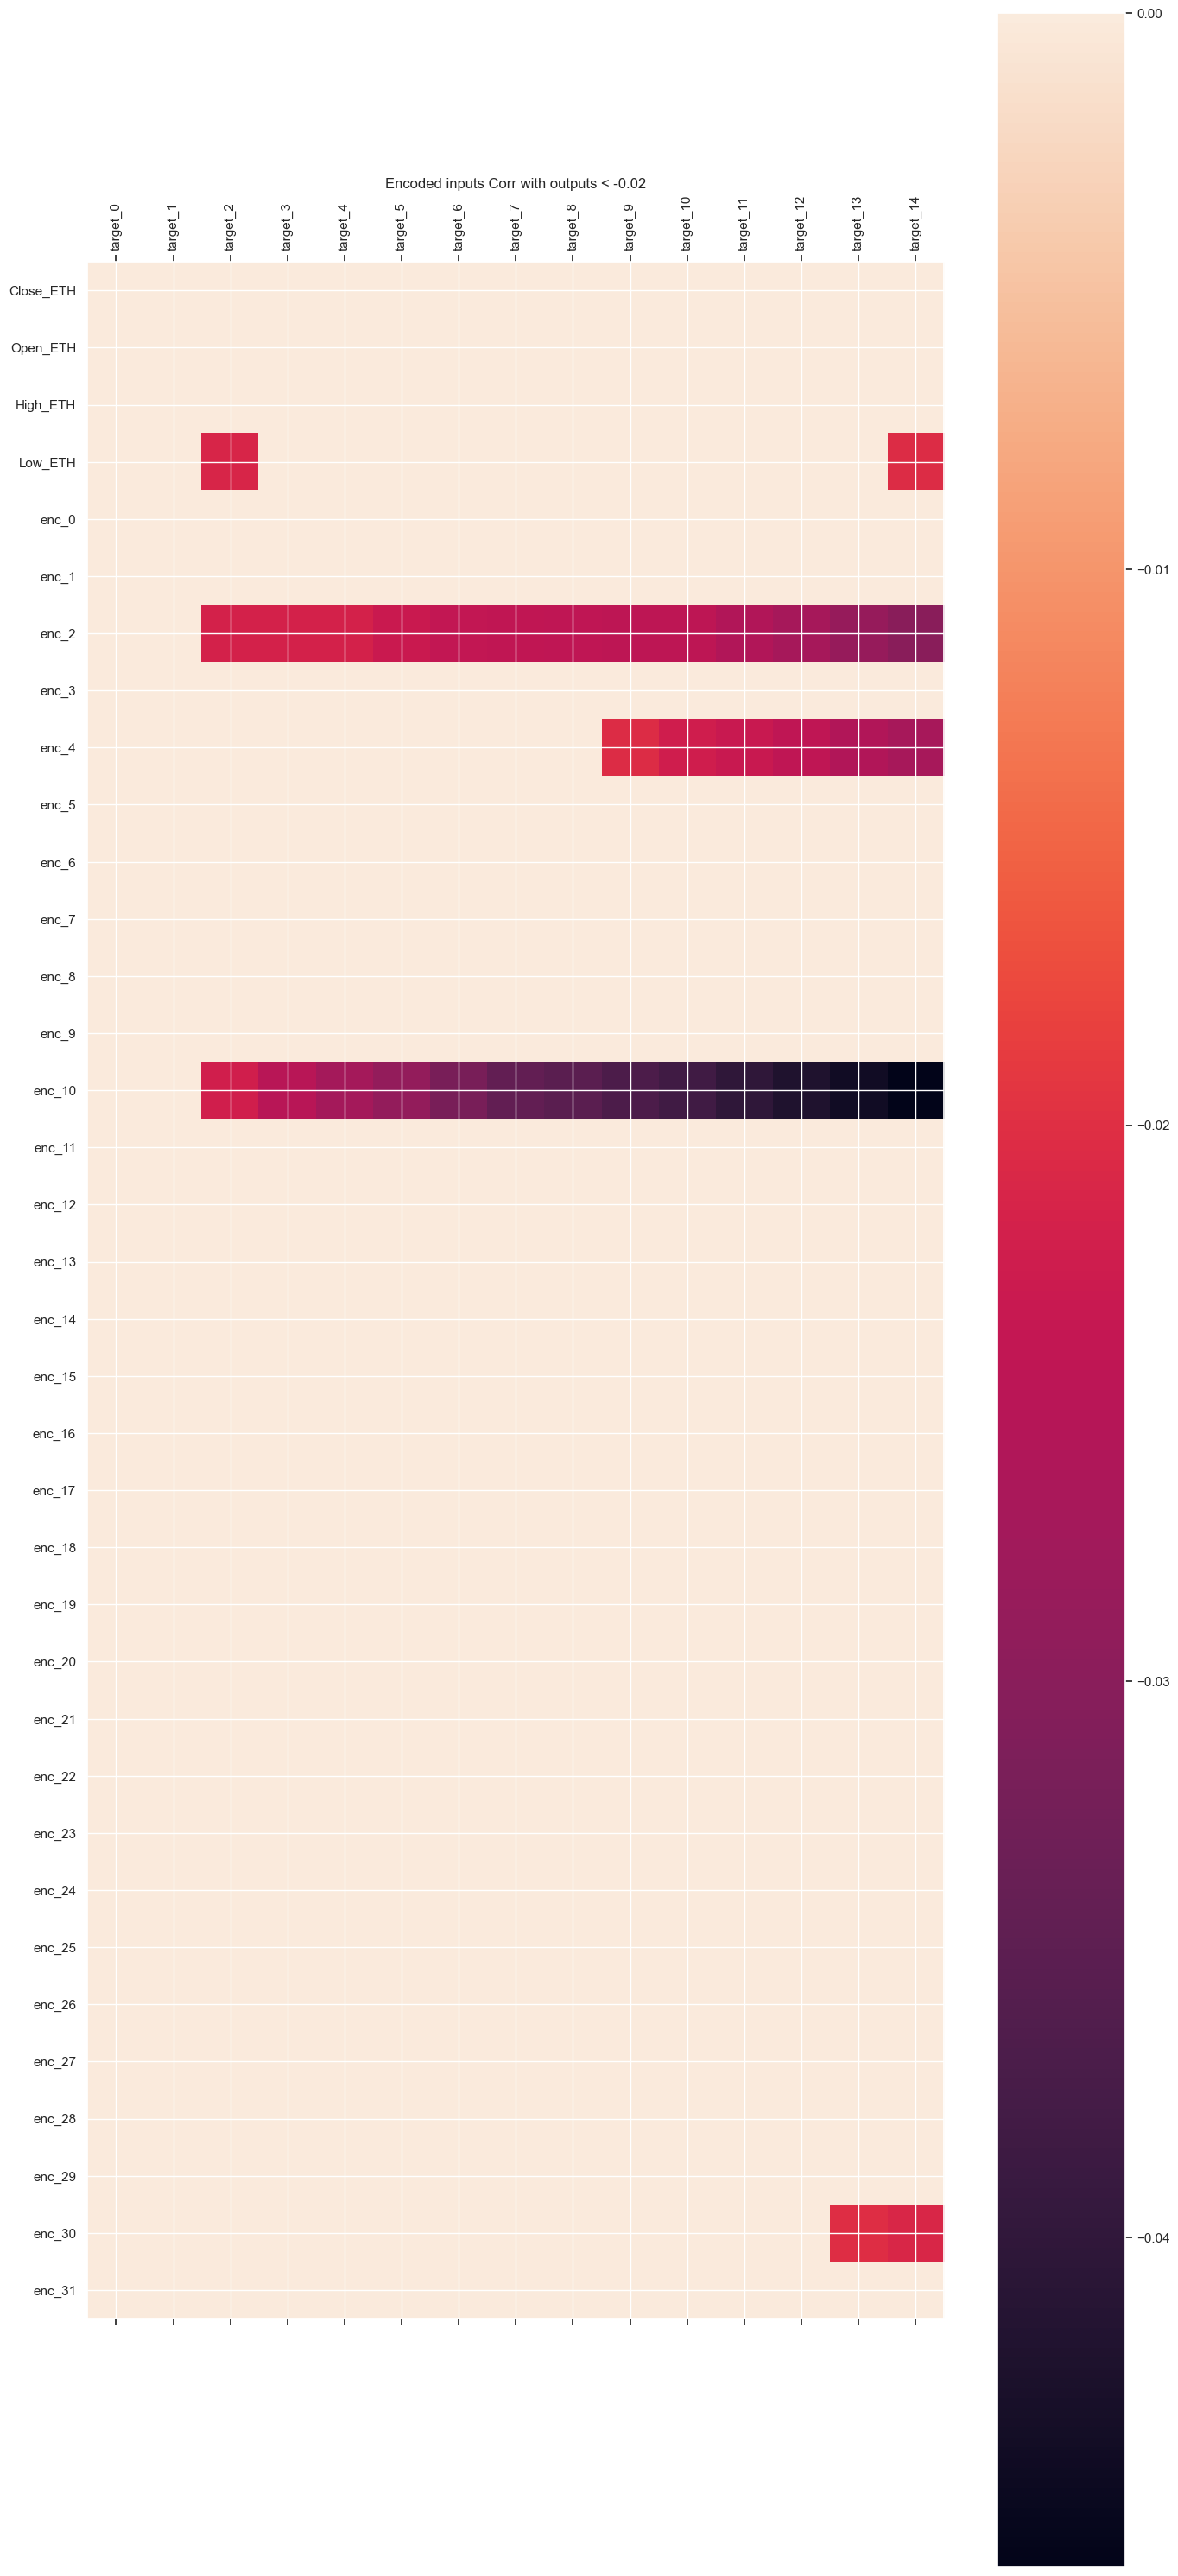

In [ ]:
corr_matrix_targets_min = corr_matrix_min.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_min.where(corr_matrix_targets_min < -0.02, 0), "Encoded inputs Corr with outputs < -0.02")

In [ ]:
"""list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)"""

'list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]\nlist_col_ae = list_col_select[:4] + list_col_enc\nnb_plot = len(list_col_ae)\nlist_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]\nlist_col_corr = list_col_ae + list_col_targets\n\n# Créer un DataFrame pandas à partir des données d\'entrée X et de la variable à prédire y\n#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), \n#    columns=list_col_select[:nb_plot] + [\'target\'])\ndf = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), \n    columns=list_col_corr)\n# Calculer la matrice de corrélation\ncorr_matrix = df.corr()\n\nfig = plot_corr(corr_matrix)'

In [ ]:
"""corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")"""


'corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]\nfig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")'

In [ ]:
"""fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),
    "Encoded inputs Corr with outputs < -0.02",
)"""

'fig = plot_corr(\n    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),\n    "Encoded inputs Corr with outputs < -0.02",\n)'

#### Auto select features 

In [ ]:
MODE_AUTO_SELECT

0

In [ ]:
# select corr var [1, 2, 5, 7, 10, 11, 16, 19, 23, 24, 27, 28, 31]
def unique_list(list1):
    x = np.array(list1)
    return list(np.unique(x))

if MODE_AUTO_SELECT == 1:
    #list_col_enc_select = []
    list_i_enc_select = []
    for i_enc , col_enc in enumerate(list_col_enc):
        if (np.any(corr_matrix_targets_min.loc[col_enc].values <  -0.02) |
            np.any(corr_matrix_targets_max.loc[col_enc].values >  0.02)
            ):
            #list_col_enc_select.append(col_enc)
            list_i_enc_select.append(i_enc)
    list_i_enc_select = unique_list(list_i_enc_select)
    # save list
    save_list(list_i_enc_select, path_save_auto_select)

elif MODE_AUTO_SELECT == 2:
    list_i_enc_select = load_list(path_save_auto_select)
else:
    list_i_enc_select = list(range(X_train_encoded_sca.shape[-1]))


print(list_i_enc_select)
print("nb encoded features: ", len(list_i_enc_select))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
nb encoded features:  32


In [ ]:
X_train_.shape

(97334, 72, 36)

In [ ]:
np.array(list(range(4)) + list(4+ np.array(list_i_enc_select)))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [ ]:
X_train_ = X_train_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]
X_test_ = X_test_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]

In [ ]:
X_train_.shape

(97334, 72, 36)

#### Train

In [140]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

#dropout_rate = 0.25#0.1
#n_units = 128#32
#reg = L1L2(l1=0.0001, l2=0.0001)

mse_curr_min = None
if MODE_TRAIN_PREDICTOR:
    for n_units in LIST_UNITS_PRED: #[32, 64, 128]: #[128]: #
        for dropout_rate in  LIST_DROPOUT_PRED: #[0.05, 0.15, 0.25]: #[0.1]:
            for seed in LIST_SEEDS:
                tf.keras.backend.clear_session()
                np.random.seed(seed)
                random.seed(seed)
                tf.random.set_seed(seed)
                optim = tf.keras.optimizers.legacy.Adam()
                #optim = tf.keras.optimizers.AdamW()
                if PATIENCE_PRED is not None:
                    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                                    verbose=1, patience=PATIENCE_PRED,
                                                    restore_best_weights=True)
                # create model
                multi_step_model = tf.keras.models.Sequential()
                multi_step_model.add(
                    tf.keras.layers.LSTM(
                        n_units,
                        return_sequences=False,
                        input_shape=X_train_.shape[-2:],
                        #kernel_regularizer=reg,
                        #bias_regularizer=reg,
                    )
                )
                multi_step_model.add(tf.keras.layers.LayerNormalization())
                multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
                #multi_step_model.add(tf.keras.layers.BatchNormalization())
                multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
                # compile
                multi_step_model.compile(optimizer=optim, loss='mse')
                # fitting
                if PATIENCE_PRED == 0:
                    multi_step_history = multi_step_model.fit(
                        X_train_, y_train_sca, epochs=EPOCHS_PRED,
                        batch_size=BATCH_SIZE, 
                        validation_data=(X_test_, y_test_sca), 
                        verbose=1,
                    )
                else:
                    multi_step_history = multi_step_model.fit(
                        X_train_, y_train_sca, epochs=EPOCHS_PRED,
                        batch_size=BATCH_SIZE, 
                        validation_data=(X_test_, y_test_sca), 
                        verbose=1, 
                        callbacks=[es],
                    )
                # eval
                if PATIENCE_PRED !=0:
                    # mode min val loss
                    i_epoch = np.argmin(multi_step_history.history['val_loss'])
                    mse_curr_train = multi_step_history.history['loss'][i_epoch]
                    mse_curr = multi_step_history.history['val_loss'][i_epoch]
                else:
                    # mode last
                    mse_curr_train = multi_step_history.history['loss'][-1]
                    mse_curr = multi_step_history.history['val_loss'][-1]

                print("MSE TRAIN : ", mse_curr_train)
                print("MSE TEST : ", mse_curr)
                    
                # plot MSE
                name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                plot_train_history(
                    multi_step_history,
                    f"AE_LSTM MSE - units {n_units} - drop {dropout_rate} -\n AE {name_plt} \n MSE_TEST={mse_curr:2f}",
                    saveFolder="data",
                )

                # save the best
                if mse_curr_min == None:
                    mse_curr_min = mse_curr
                    n_units_min = n_units
                    dropout_rate_min = dropout_rate

                    print("Save model: ", path_mdl_predict_autoenc_lstm)
                    multi_step_model.save(path_mdl_predict_autoenc_lstm)
                else:
                    if mse_curr < mse_curr_min:
                        mse_curr_min = mse_curr
                        n_units_min = n_units
                        dropout_rate_min = dropout_rate
                        print("Save model: ", path_mdl_predict_autoenc_lstm)
                        multi_step_model.save(path_mdl_predict_autoenc_lstm)
    
    n_units = n_units_min#32
    dropout_rate = dropout_rate_min #0.25
    mse_curr = mse_curr_min

    
print("Load model: ", path_mdl_predict_autoenc_lstm)
multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
n_units = multi_step_model.layers[0].units#32
dropout_rate = multi_step_model.layers[2].rate#0.25
print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")
print(multi_step_model.summary())

Load model:  data/mdl_predict_autoenc_lstm
Best model: n_units=256 / dropout= 0.1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               300032    
                                                                 
 layer_normalization (Layer  (None, 256)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 15)                3855      
                                                                 
Total params: 304399 (1.16 MB)
Trainable params: 304399 (1.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None

In [141]:
print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")

Best model: n_units=256 / dropout= 0.1


In [142]:
np.min(y_train)

0.8990060972444147

In [143]:
np.max(y_train)

1.087790104524251

#### Results

##### Save mdl

In [144]:
X_train_.shape

(97342, 72, 36)

##### Predict

In [145]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

13/13 [==============================] - 0s 17ms/step


##### Plots

In [146]:
print(y_train_raw[0::FUTURE_TARGET,:].ravel().shape)
print(y_train_pred_raw[0::FUTURE_TARGET,:].ravel().shape)

(97350,)
(97350,)


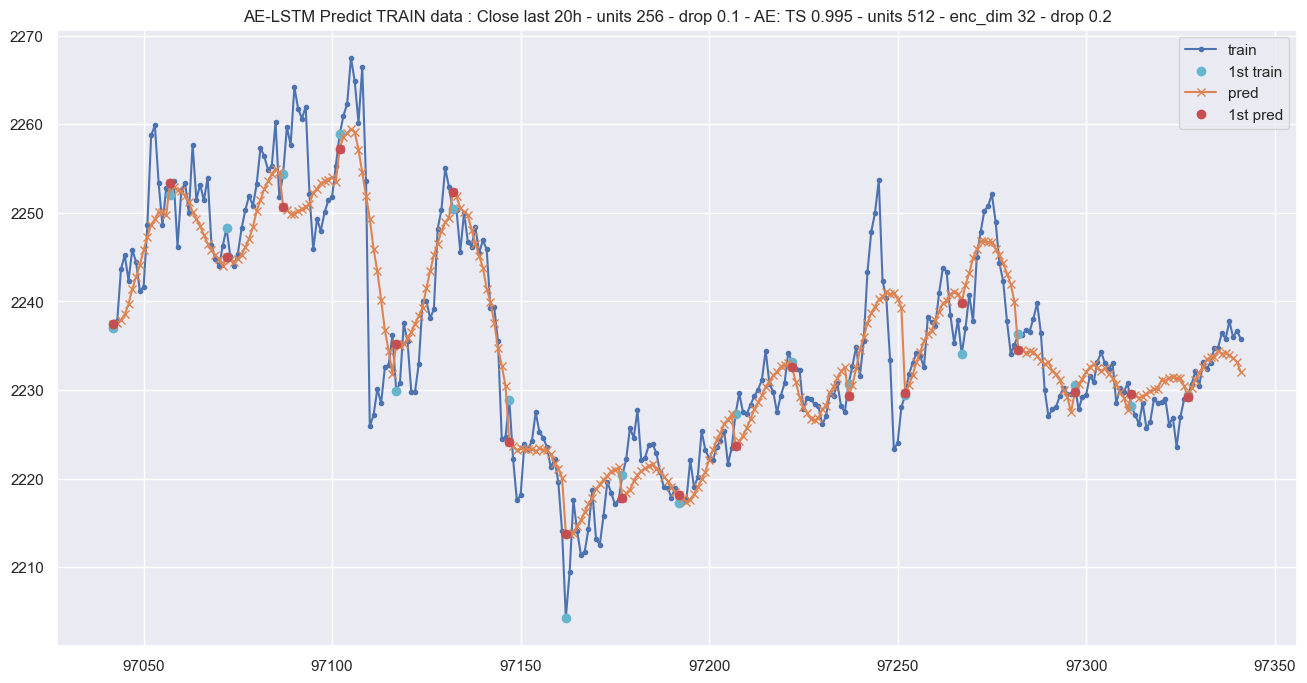

In [147]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TRAIN data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_train_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_train_pred_raw_1 = y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'oc', label ='1st train')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_train_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TRAIN - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

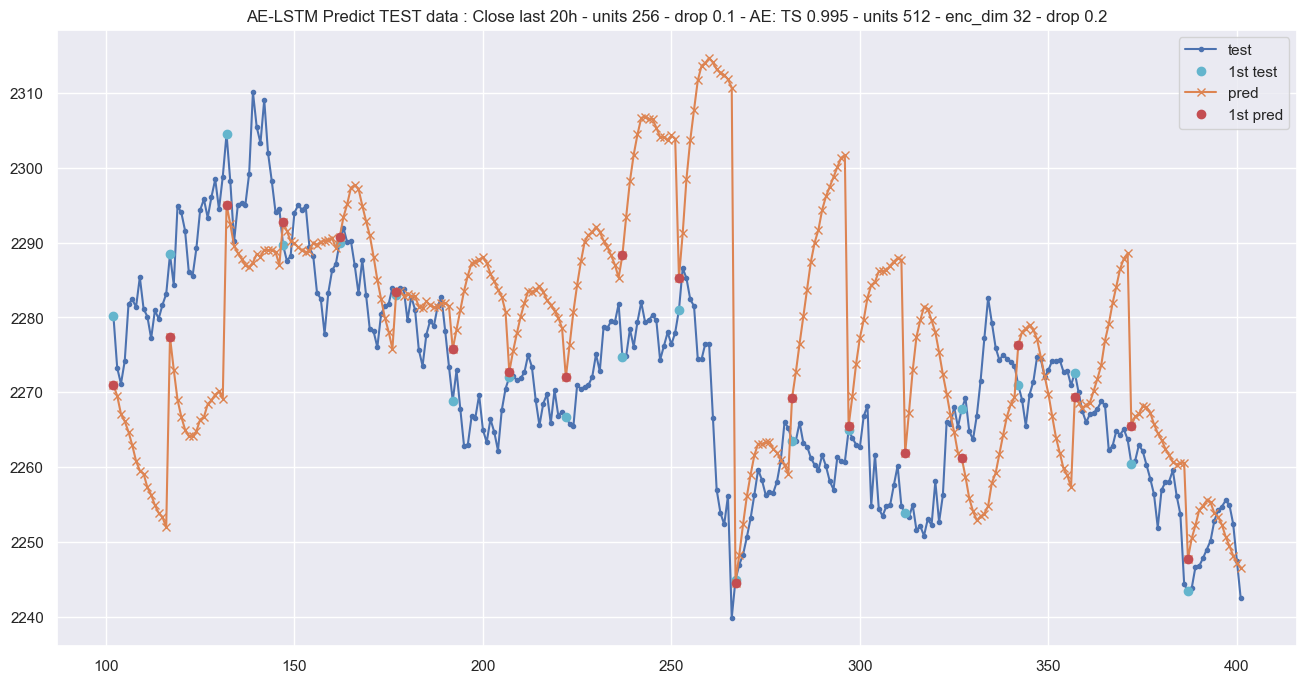

In [148]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TEST data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_test_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_test_pred_raw_1 = y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="test")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'oc', label ='1st test')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_test_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TEST - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

In [149]:
arr_mse_train = np.zeros((y_train_raw.shape[0]))
for i_date in range(y_train_raw.shape[0]):
    arr_mse_train[i_date] = mean_squared_error(
        y_train_raw[i_date], 
        y_train_pred_raw[i_date], 
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on TRAIN data")
plt.plot(arr_mse_train, label="mse")

Error in callback <function flush_figures at 0x2b7da9a20> (for post_execute):


KeyboardInterrupt: 

Text(0.5, 1.0, 'Distrib. RMSE on TRAIN')

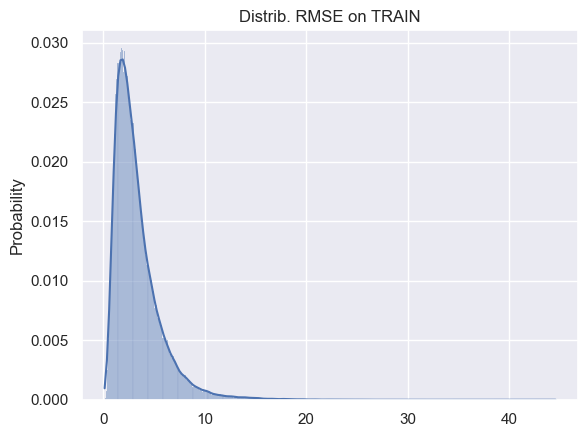

In [ ]:
sns.histplot(x=arr_mse_train, stat="probability", kde=True)
fig = plt.gcf()
plt.title("Distrib. RMSE on TRAIN")

Text(0.5, 1.0, 'RMSE on TRAIN: mean= 3.32')

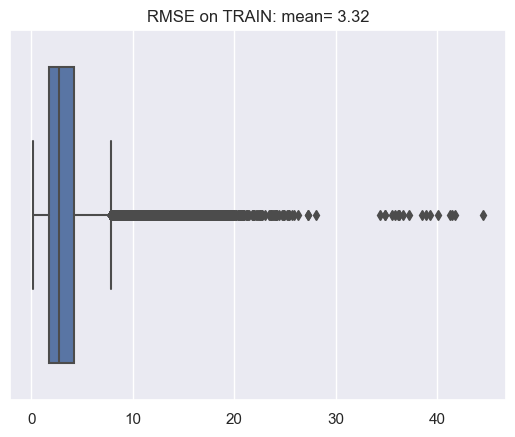

In [ ]:

sns.boxplot(x=arr_mse_train)
fig = plt.gcf()
plt.title(f"RMSE on TRAIN: mean= {np.mean(arr_mse_train):.2f}")

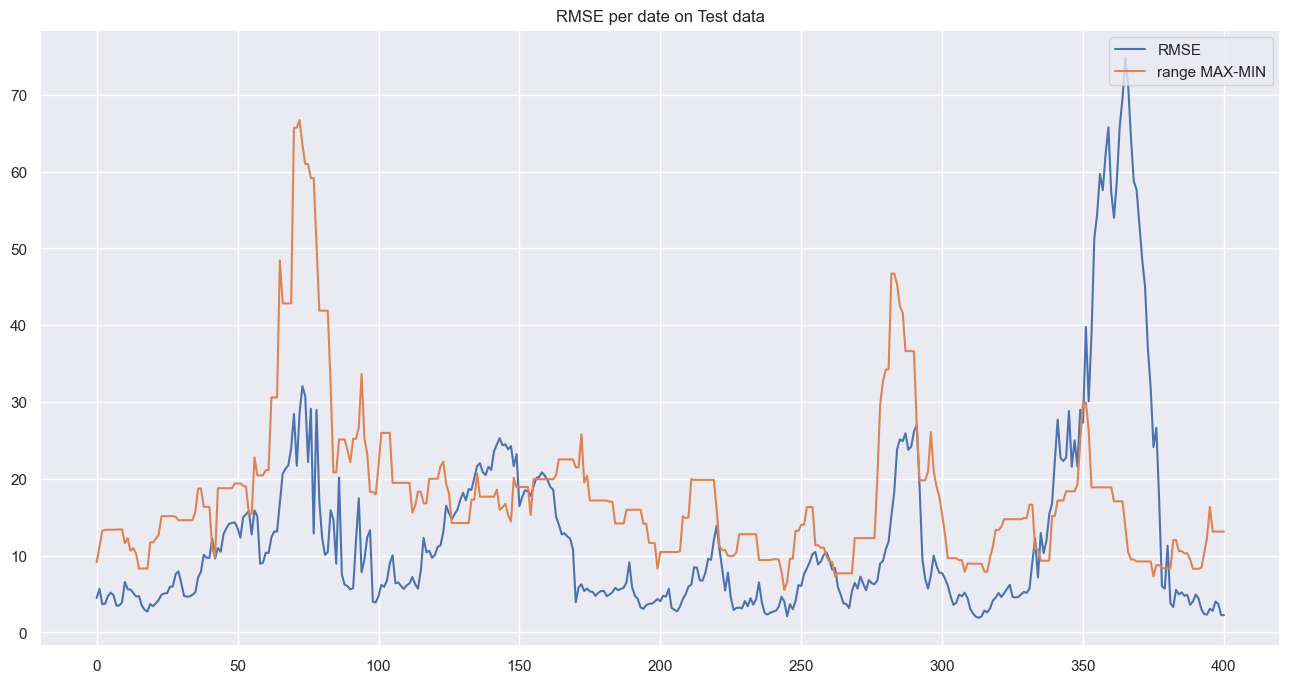

In [ ]:
arr_mse = np.zeros((y_test_raw.shape[0]))
arr_range = np.zeros((y_test_raw.shape[0]))
for i_date in range(y_test_raw.shape[0]):
    arr_mse[i_date] = mean_squared_error(
        y_test_raw[i_date], 
        y_test_pred_raw[i_date],
        squared=False,
    )
    arr_range[i_date] = np.max(y_test_raw[i_date]) - np.min(y_test_raw[i_date])
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on Test data")
plt.plot(arr_mse, label="RMSE")
plt.plot(arr_range, label="range MAX-MIN")
plt.legend(loc='upper right')

In [ ]:
np.mean(arr_range)

17.84401496259347

<Axes: ylabel='Probability'>

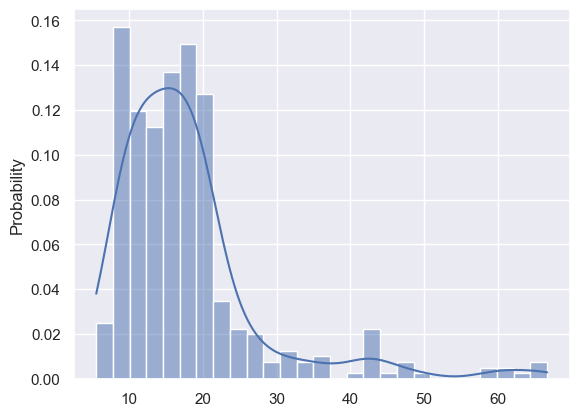

In [ ]:
sns.histplot(x=arr_range,  stat="probability", kde=True)

In [ ]:
np.mean(3*np.sqrt(np.var(y_test_raw, axis=1)))

15.662198798300432

<Axes: ylabel='Probability'>

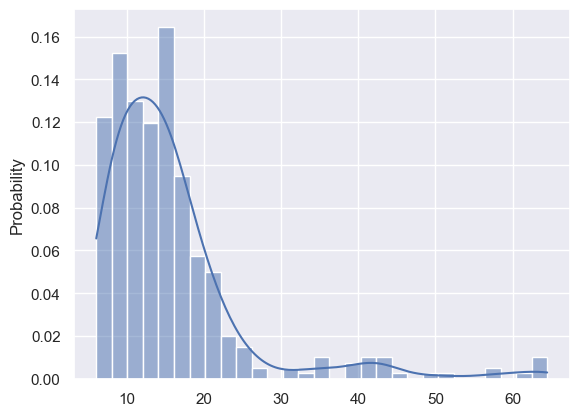

In [ ]:
sns.histplot(x=3*np.sqrt(np.var(y_test_raw, axis=1)),  stat="probability", kde=True)

Text(0.5, 1.0, 'probability of RSME on each sequence')

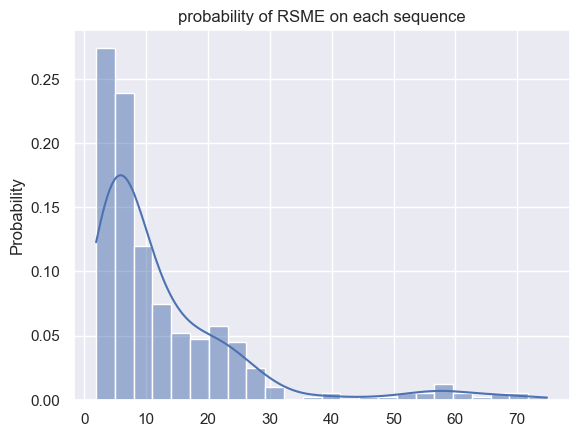

In [ ]:
sns.histplot(x=arr_mse,  stat="probability", kde=True)
plt.title("probability of RSME on each sequence")

(0.0, 89.22007481296734)

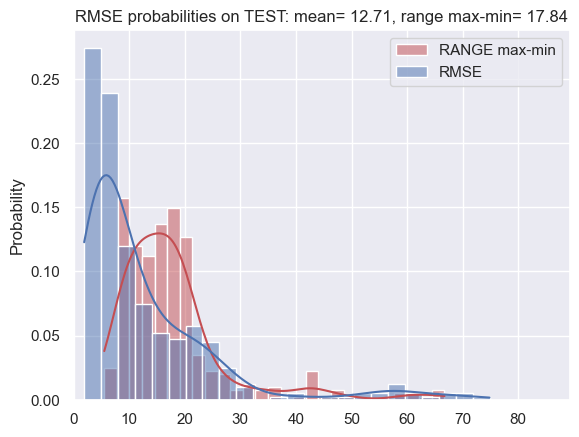

In [ ]:
ax = sns.histplot(x=arr_range,  stat="probability", kde=True, label="RANGE max-min", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="RMSE", ax=ax)
plt.title(f"RMSE probabilities on TEST: mean= {np.mean(arr_mse):.2f}, range max-min= {np.mean(arr_range):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_range)*5])

(0.0, 63.538443376128406)

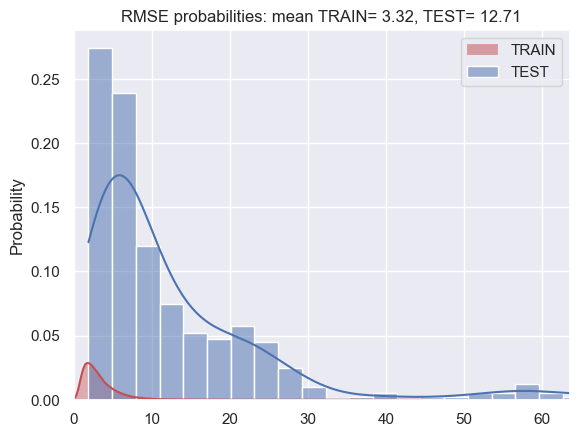

In [ ]:
ax = sns.histplot(x=arr_mse_train,  stat="probability", kde=True, label="TRAIN", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="TEST", ax=ax)
plt.title(f"RMSE probabilities: mean TRAIN= {np.mean(arr_mse_train):.2f}, TEST= {np.mean(arr_mse):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_mse)*5])

Text(0.5, 1.0, 'RMSE on TEST: mean= 12.71')

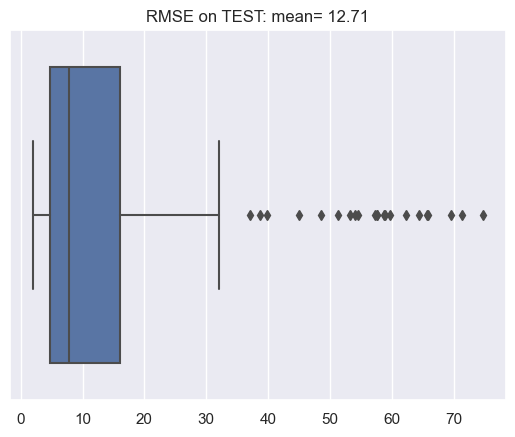

In [ ]:
sns.boxplot(x=arr_mse)
fig = plt.gcf()
plt.title(f"RMSE on TEST: mean= {np.mean(arr_mse):.2f}")

In [ ]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[2264.85 2264.33 2265.07 2263.72 2260.49 2260.86 2262.97 2262.17 2260.35
 2258.48 2256.38 2251.94 2256.93 2258.   2258.08]
[2261.80153229 2260.92013469 2260.11507542 2259.16017182 2258.14484494
 2257.27693467 2256.8008316  2256.36802289 2256.04945195 2255.9427671
 2255.86184306 2255.98161063 2255.89286394 2256.15033724 2256.46459224]


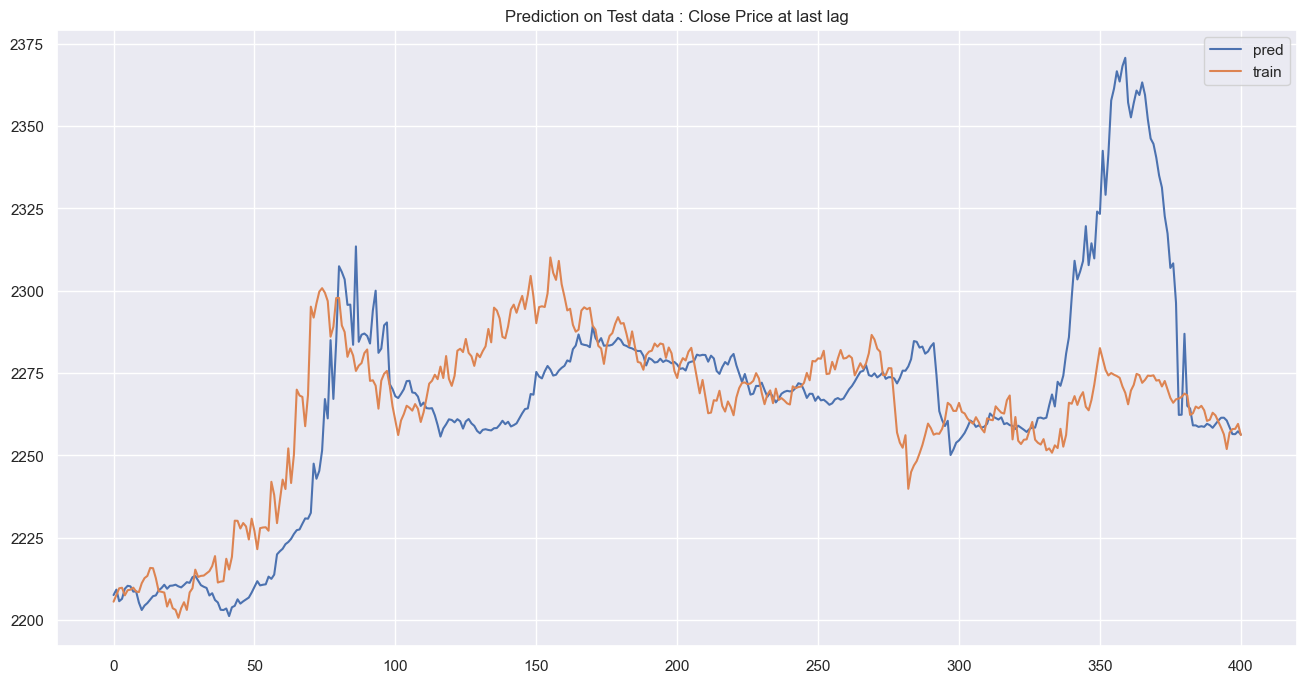

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

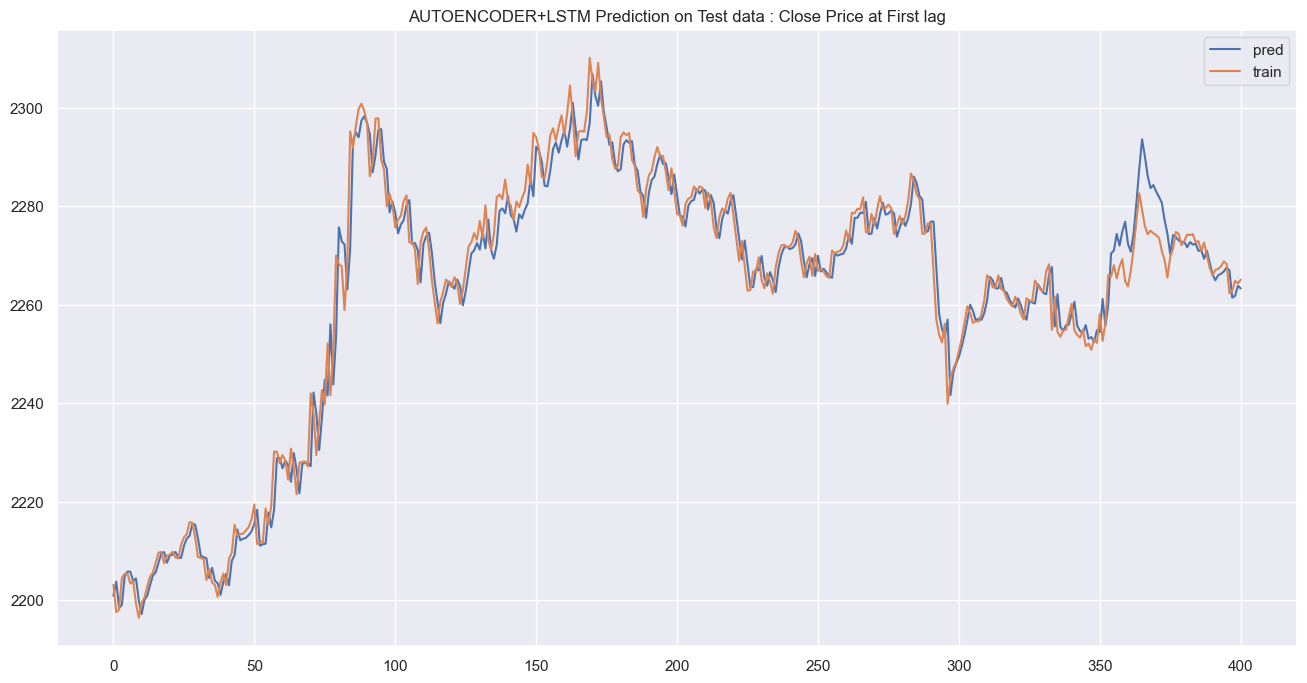

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

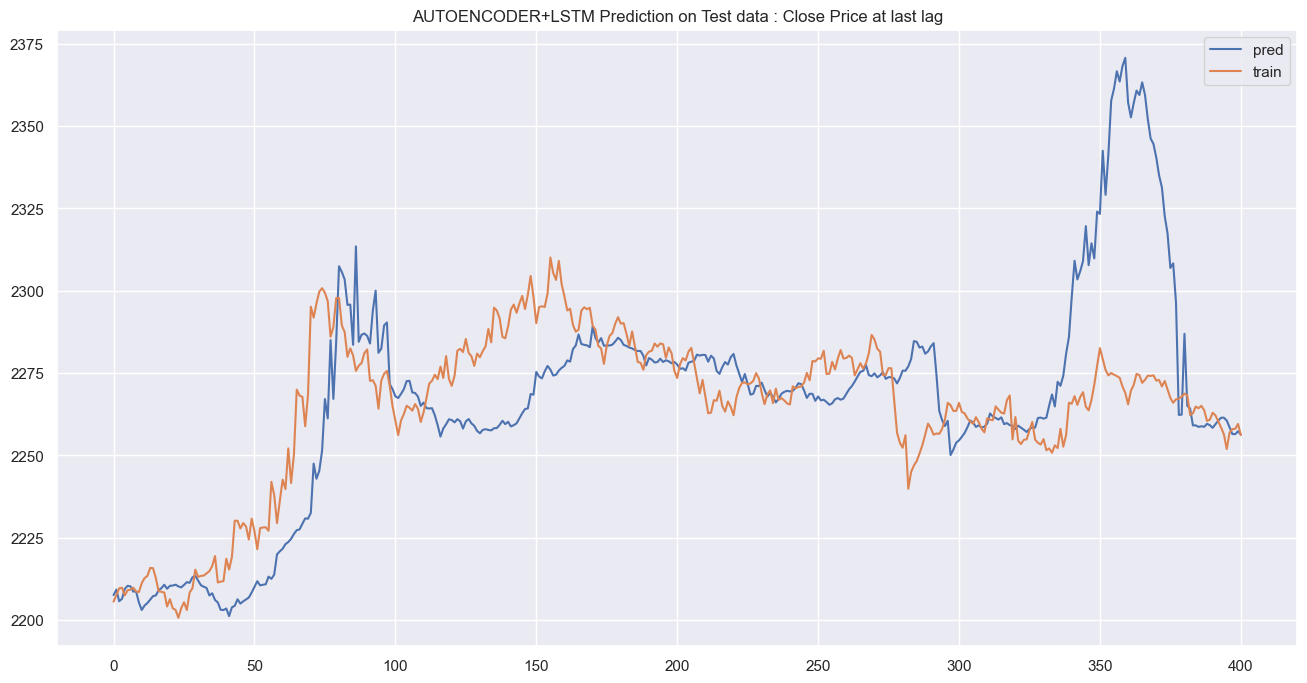

In [ ]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

## Predict last prediction

In [150]:
X_test_sca.shape

(402, 72, 102)

In [151]:
df_feat["Close_ETH"].iloc[-1]

2235.04

In [152]:
df_feat["Close_ETH"].iloc[-1]

2235.04

In [153]:
len(list_i_enc_select)

NameError: name 'list_i_enc_select' is not defined

In [154]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale by ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate (auto selected encoded features)
X_last_ = np.concatenate([
        X_last_sca[:,:,0:4], 
        X_last_encoded_sca[:, :, np.array(list_i_enc_select)]
    ],
    axis=-1,
)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))


[batch, lags, features]
X_last[0,:,0]:
[2270.95 2269.01 2265.53 2269.7  2271.43 2274.77 2274.39 2272.06 2272.96
 2274.24 2274.15 2274.33 2272.74 2272.9  2270.95 2272.61 2269.99 2267.47
 2266.   2267.06 2267.28 2267.79 2268.78 2268.27 2262.31 2262.8  2264.85
 2264.33 2265.07 2263.72 2260.49 2260.86 2262.97 2262.17 2260.35 2258.48
 2256.38 2251.94 2256.93 2258.   2258.08 2259.58 2256.2  2253.7  2244.41
 2243.4  2243.83 2246.69 2246.8  2247.85 2249.   2250.17 2252.82 2254.24
 2254.73 2255.55 2254.98 2252.43 2247.43 2242.49 2225.46 2233.79 2231.96
 2228.   2228.36 2227.12 2230.77 2229.26 2232.9  2232.48 2233.89 2235.04]
X_last[0,:,0] after divide by price:
[1.01606683 1.01519883 1.01364181 1.01550755 1.01628159 1.01777597
 1.01760595 1.01656346 1.01696614 1.01753884 1.01749857 1.0175791
 1.01686771 1.01693929 1.01606683 1.01680954 1.0156373  1.01450981
 1.0138521  1.01432637 1.0144248  1.01465298 1.01509593 1.01486774
 1.01220112 1.01242036 1.01333757 1.01310491 1.013436   1.01283199
 1.01

NameError: name 'list_i_enc_select' is not defined

In [ ]:
X_last_encoded_sca.shape

(1, 72, 32)

In [ ]:
list_i_enc_select

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31]

In [ ]:
X_last_encoded_sca[:,:, np.array(list_i_enc_select)].shape

(1, 72, 32)

In [ ]:
X_last_sca[:,:,0:4].shape

(1, 72, 4)

In [ ]:
X_train_.shape

(97315, 72, 36)

In [ ]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
97885  1701896700000   2256.94   2261.40  2256.94    2258.00    645.1782   
97886  1701897000000   2258.01   2260.12  2257.55    2258.08   1015.6812   
97887  1701897300000   2258.07   2259.60  2256.34    2259.58    811.7002   
97888  1701897600000   2259.58   2259.75  2256.20    2256.20    569.7546   
97889  1701897900000   2256.21   2256.99  2253.98    2256.99    307.7813   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1757.367889       1756.908847   
1      2023-01-01 00:05:00       1757.367889       1756.908847   
2      2023-01-01 00:10:00       1757.367889       1756.908847   
3      2023-01-01 00:15:00       1757.367889       1756.908847   
4      2023-01-01 00:20:00       1757.367889       1756.908847   
...                    ...               ...               ...   
97885  2023-12-06 21:05:00       2272.732500       2266.025000   
97886  2023-12-06 21:10:00       2272.810000       2266.025000   
97887  2023-12-06 21:15:00       2273.747500       2266.025000   
97888  2023-12-06 21:20:00       2273.647500       2266.025000   
97889  2023-12-06 21:25:00       2273.107500       2266.025000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
97885        2262.525  ...         NaN            NaN           NaN   
97886        2262.170  ...         NaN            NaN           NaN   
97887        2261.955  ...         NaN            NaN           NaN   
97888        2260.650  ...         NaN            NaN           NaN   
97889        2260.550  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
97885               NaN         0.0               NaN         0.0      0.0   
97886               NaN         0.0               NaN         0.0      0.0   
97887               NaN         0.0               NaN         0.0      0.0   
97888               NaN         0.0               NaN         0.0      0.0   
97889               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
97885                  NaN  False  
97886                  NaN  False  
97887                  NaN  False  
97888                  NaN  False  
97889                  NaN  False  

[97890 rows x 136 columns]

In [ ]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

In [ ]:
y_last_pred_unscaled

array([[0.9996168 , 0.9991973 , 0.99891317, 0.99861723, 0.99819   ,
        0.99787927, 0.9976918 , 0.9974779 , 0.99726105, 0.99700236,
        0.99674666, 0.99661803, 0.99636126, 0.9963288 , 0.9961863 ]],
      dtype=float32)

In [ ]:
df_feat["Close_ETH"].iloc[-1]

2256.99

In [ ]:
y_last_pred_raw

array([[2256.125 , 2255.1782, 2254.537 , 2253.8691, 2252.9048, 2252.2036,
        2251.7805, 2251.2976, 2250.808 , 2250.2244, 2249.6472, 2249.357 ,
        2248.7773, 2248.704 , 2248.3826]], dtype=float32)

In [ ]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [ ]:
list_pred

[2253.8691,
 2252.9048,
 2252.2036,
 2251.7805,
 2251.2976,
 2250.808,
 2250.2244,
 2249.6472,
 2249.357,
 2248.7773,
 2248.704,
 2248.3826]

In [ ]:
save_list(list_pred, path_save_pred_vals)

In [ ]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [ ]:
list_pred_reload

[2253.8691,
 2252.9048,
 2252.2036,
 2251.7805,
 2251.2976,
 2250.808,
 2250.2244,
 2249.6472,
 2249.357,
 2248.7773,
 2248.704,
 2248.3826]